# Graph RAG テスト


こちらを参考にGraph RAGを構築TEST：

* エンジニアのためのGraphRAG入門: 知識グラフ活用の第一歩
    https://zenn.dev/fukurou_labo/articles/f0c233eb5aebb7



### Azure OpenAI Integration

This notebook has been modified to use Azure OpenAI instead of OpenAI API. Follow the steps below to set up:

1) Sign in to Azure OpenAI and obtain the following credentials:
    - API Key
    - Endpoint URL
    - API Version

2) Set environment variables as follows:
    - `AZURE_OPENAI_API_KEY`: Your Azure API key
    - `AZURE_OPENAI_ENDPOINT`: The endpoint URL for your Azure OpenAI instance
    - `AZURE_OPENAI_API_VERSION`: API version, e.g., "2023-03-15-preview"

3) Install required Python libraries:
    ```bash
    pip install openai langchain neo4j
    ```

4) Update the following environment variables in your script or runtime:
    ```python
    import os

    os.environ["AZURE_OPENAI_API_KEY"] = "<your-api-key>"
    os.environ["AZURE_OPENAI_ENDPOINT"] = "<your-endpoint>"
    os.environ["AZURE_OPENAI_API_VERSION"] = "2023-03-15-preview"
    ```


### Langchainとneo4jを用いてGraphを構築

[前準備]
1) Langchainを介してOpenAIのAPIを使用するため、OpenAI PlatformにサインインしてAPIキーを取得：

    https://platform.openai.com/docs/overview

1) Neo4j のインストール：
    
    https://neo4j.com/deployment-center/

    参考；
    https://qiita.com/ogi_kimura/items/799555236f522a190ae8

2) 環境変数を設定

    * ["OPENAI_API_KEY"] = 1) で取得したAPIキー

    * ["NEO4J_URI"] = bolt://neo4j:7687
    * ["NEO4J_USERNAME"] = neo4j
    * ["NEO4J_PASSWORD"] = <任意のpassword>

2) ライブラリ群をインストール:

        pip install -U langchain langchain-openai　langchain-community　langchain-experimental
        (requirements.txtを参照)

#### 本コードで使用されているライブラリ・クラスについて

[Langchain関連]

1) **langchain_community.graphs.Neo4jGraph**

    LangChainライブラリのNeo4jグラフインターフェースを提供するクラスで、データをNeo4jグラフデータベースに保存・操作します。

2) **langchain.document_loaders.TextLoader**

    テキストデータを読み込むためのクラス。ドキュメントのテキストファイルをロードし、解析のために取り込む際に利用します。

3) **langchain.text_splitter.TokenTextSplitter / CharacterTextSplitter**

    テキストを指定されたトークンまたは文字数で分割するクラス。大きなテキストを小さなチャンクに分割し、後続の処理（例：LLMによる処理）を効率的に行えるようにします。

4) **langchain_openai.ChatOpenAI**

    OpenAIのチャットモデルを呼び出すためのクラスで、ユーザーが指定したモデル（この場合、GPT-4）を使った回答生成に使用されます。

5) **langchain_experimental.graph_transformers.LLMGraphTransformer**

    LMの出力をグラフ構造に変換するクラス。テキストをLLMで解析し、グラフドキュメントとしてNeo4jに保存できる形式に変換します。

6) **langchain_core.runnables**

    LangChainライブラリの「ランナブル」機能を提供するモジュールで、処理の実行フローを管理します。

    主なクラス:

    RunnableBranch: 条件に基づき異なる処理を分岐させるランナブル。
    -- RunnableLambda: 関数のようなランダムなロジックを実行するためのランナブル。
    -- RunnableParallel: 並列に複数の処理を実行するランナブル。
    -- RunnablePassthrough: データを通過させるだけのパイプライン内のユーティリティランナブル。

7) **langchain_core.prompts.ChatPromptTemplate**

    チャットプロンプト用のテンプレートで、対話型プロンプトの作成に使用されます。

8) **langchain_core.prompts.prompt.PromptTemplate**

    一般的なプロンプトテンプレートで、LLMへの入力文をフォーマットするために使われます。

9) **langchain_core.messages**

    LangChainのメッセージング用モジュールで、AIや人間のメッセージの型を定義します。

    主なクラス:

    - AIMessage: AIからのメッセージを表現するクラス。
    - HumanMessage: ユーザーからのメッセージを表現するクラス。

10) **langchain_core.output_parsers.StrOutputParser**

    出力を文字列として解析するためのパーサーで、LLMの出力をテキストとして処理するために使用されます。

11) **langchain_community.vectorstores.Neo4jVector**

    Neo4jをベースとしたベクトルストアで、ベクトル検索や埋め込みデータの保存に使用されます。

12) **langchain_openai.OpenAIEmbeddings**

    OpenAIの埋め込みモデルを使用して、テキストをベクトル化するためのクラスです。

13) **langchain_community.vectorstores.neo4j_vector.remove_lucene_chars**

    Luceneの検索エンジンで無効な文字を削除するための関数。Neo4jにデータを保存する際、特定の特殊文字を処理するために使用されます。


<補足>
* neo4j.GraphDatabase

    Neo4jのPythonドライバで、データベースの接続やクエリの実行に使用されます。(※今回はグラフ可視化スクリプトでのみ使用)

* yfiles_jupyter_graphs.GraphWidget

    Jupyterノートブック内でグラフを視覚化するウィジェット。Cypherクエリで取得したデータをグラフとして表示します。



#### モジュールインポート


In [80]:
import os
from langchain_community.graphs import Neo4jGraph
from langchain.document_loaders import TextLoader
from langchain.text_splitter import TokenTextSplitter
from langchain_openai import ChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget
from langchain.text_splitter import CharacterTextSplitter
import pprint

In [81]:
os.environ["NEO4J_URI"] = "bolt://neo4j:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "Ilovejk@3816"

print(os.environ["NEO4J_URI"], os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"])

bolt://neo4j:7687 neo4j Ilovejk@3816


#### テキスト分割

(後でグラフを生成する際に用いられる、ベクトル化するためのチャンク作成)

In [82]:
from langchain.text_splitter import CharacterTextSplitter

# raw_documents = TextLoader('./data/manufacturing_company_dummy_v2.txt').load()
raw_documents = TextLoader('./data/wikipage_1-5.txt').load()
# print(raw_documents)

text_splitter = CharacterTextSplitter(
    separator="。",
    chunk_size=1400, 
    chunk_overlap=0
    )
documents = text_splitter.split_documents(raw_documents)

print(f"{len(documents)} chunks")
# documents

Created a chunk of size 2248, which is longer than the specified 1400


75 chunks


#### 入力されたドキュメントを解析し、グラフのノードとエッジを生成

In [83]:
# グラフ作成に使用するLLMを設定
import time

llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
llm_transformer = LLMGraphTransformer(llm=llm)


graph = Neo4jGraph()

#グラフ初期化
graph.query("MATCH (n) DETACH DELETE n")

start = time.time()

# グラフ作成を実行
graph_documents = llm_transformer.convert_to_graph_documents(documents)
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

end = time.time()
elapsed_time = end - start

hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = elapsed_time % 60

print(f"実行時間: {hours}時間{minutes}分{seconds:.2f}秒")

# cypherでqueryできるか確認
pprint.pprint(graph.query("MATCH p=()-[:!MENTIONS]->() RETURN p LIMIT 25"))

実行時間: 0時間21分14.45秒
[{'p': [{'id': 'Peach'}, 'CREATED_BY', {'id': 'Nintendo'}]},
 {'p': [{'id': 'Peach'}, 'APPEARS_IN', {'id': 'Mario Series'}]},
 {'p': [{'id': 'Peach'}, 'KIDNAPPED_BY', {'id': 'Bowser'}]},
 {'p': [{'id': 'Peach'}, 'ASSOCIATED_WITH', {'id': 'Toadsworth'}]},
 {'p': [{'id': 'Peach'}, 'APPEARS_IN', {'id': 'Super Mario Sunshine'}]},
 {'p': [{'id': 'Peach'}, 'APPEARS_IN', {'id': 'Super Mario Bros'}]},
 {'p': [{'id': 'Peach'}, 'APPEARS_IN', {'id': 'Super Mario Bros 2'}]},
 {'p': [{'id': 'Peach'}, 'APPEARS_IN', {'id': 'Super Mario Rpg'}]},
 {'p': [{'id': 'Peach'}, 'MAIN_CHARACTER', {'id': 'Super Princess Peach'}]},
 {'p': [{'id': 'Peach'}, 'MAIN_CHARACTER', {'id': 'Princess Peach Showtime!'}]},
 {'p': [{'id': 'Peach'}, 'APPEARS_IN', {'id': 'Cat Mario Time'}]},
 {'p': [{'id': 'Peach'}, 'APPEARS_IN', {'id': 'Super Mario 3D World'}]},
 {'p': [{'id': 'Peach'}, 'APPEARS_IN', {'id': 'Super Smash Bros'}]},
 {'p': [{'id': 'Peach'}, 'APPEARS_IN', {'id': 'Dr._Mario'}]},
 {'p': [{'id': '

In [ ]:
# !!!GraphCypherQAChainのテスト
# https://python.langchain.com/v0.2/api_reference/community/chains/langchain_community.chains.graph_qa.cypher.GraphCypherQAChain.html
#https://zenn.dev/yumefuku/articles/llm-neo4j-hybrid

from langchain.chains import GraphCypherQAChain
from langchain.chat_models import ChatOpenAI
from langchain import PromptTemplate
from langchain.graphs import Neo4jGraph

CYPHER_GENERATION_PROMPT = """
Task: グラフデータベースに問い合わせるCypher文を生成する。

指示:
schemaで提供されている関係タイプとプロパティのみを使用してください。
提供されていない他の関係タイプやプロパティは使用しないでください。

schema:
{schema}

注意: 回答に説明や謝罪は含めないでください。
Cypher ステートメントを作成すること以外を問うような質問には回答しないでください。
「```cypher」など、生成された Cypher ステートメント以外のテキストは絶対に回答に含めないでください。

[誤った出力例]
 ```cypher
MATCH (p:Person) WHERE p.id="A" RETURN p
```

[正しい出力例]
MATCH (p:Person) WHERE p.id="A" RETURN p

質問: {question}"""

# Create a PromptTemplate object
cypher_prompt_template = PromptTemplate(
    input_variables=["question","schema"],
    template=CYPHER_GENERATION_PROMPT
)


# Initialize the graph connection
graph = Neo4jGraph()

# Initialize the language model
llm = ChatOpenAI(temperature=0,  model_name="gpt-4o-mini")

# Create the GraphCypherQAChain
chain_cy = GraphCypherQAChain.from_llm(
    llm=llm,
    graph=graph,
    return_intermediate_steps=True,
    allow_dangerous_requests=True,
    cypher_prompt=cypher_prompt_template,
    verbose=True
)

# Define your question
question = "マリオとクッパはどういった関係ですか?すべてのパターンを回答してください。"

# Generate the Cypher query without executing the QA chain
cypher_query = chain_cy.cypher_generation_chain.invoke({
    'question': question,
    'schema': chain.graph_schema
})

print("Generated Cypher Query:\n", cypher_query['text'])

# cypher_query


#### 生成されたグラフを表示

In [ ]:
default_cypher = "MATCH (s)-[r:!MENTIONS]->(t) RETURN s,r,t"
# default_cypher = 'MATCH (c:キャラクター {id: "クッパ"})-[r:HAS]->(f) RETURN c,r,f' #"MATCH (s)-[r:!MENTIONS]->(t) RETURN s,r,t"
# default_cypher = 'MATCH (p:Person)-[r]->(c) WHERE c.id CONTAINS "Python" RETURN p,r,c'
# cypher_query = default_cypher
# default_cypher = 'MATCH (k:Character {id: "クッパ"})-[r:FRIENDLY]->(f:Character) RETURN k,r,f'

def showGraph(cypher: str = default_cypher):
    driver = GraphDatabase.driver(
        uri = os.environ["NEO4J_URI"],
        auth = (
            os.environ["NEO4J_USERNAME"],
            os.environ["NEO4J_PASSWORD"]
        )
    )
    session = driver.session()
    widget = GraphWidget(graph = session.run(cypher).graph())
    widget.node_label_mapping = 'id'
    return widget

showGraph()

#### **[グラフ可視化例]**

#### Analitics_Dummmy
[グラフ全体]

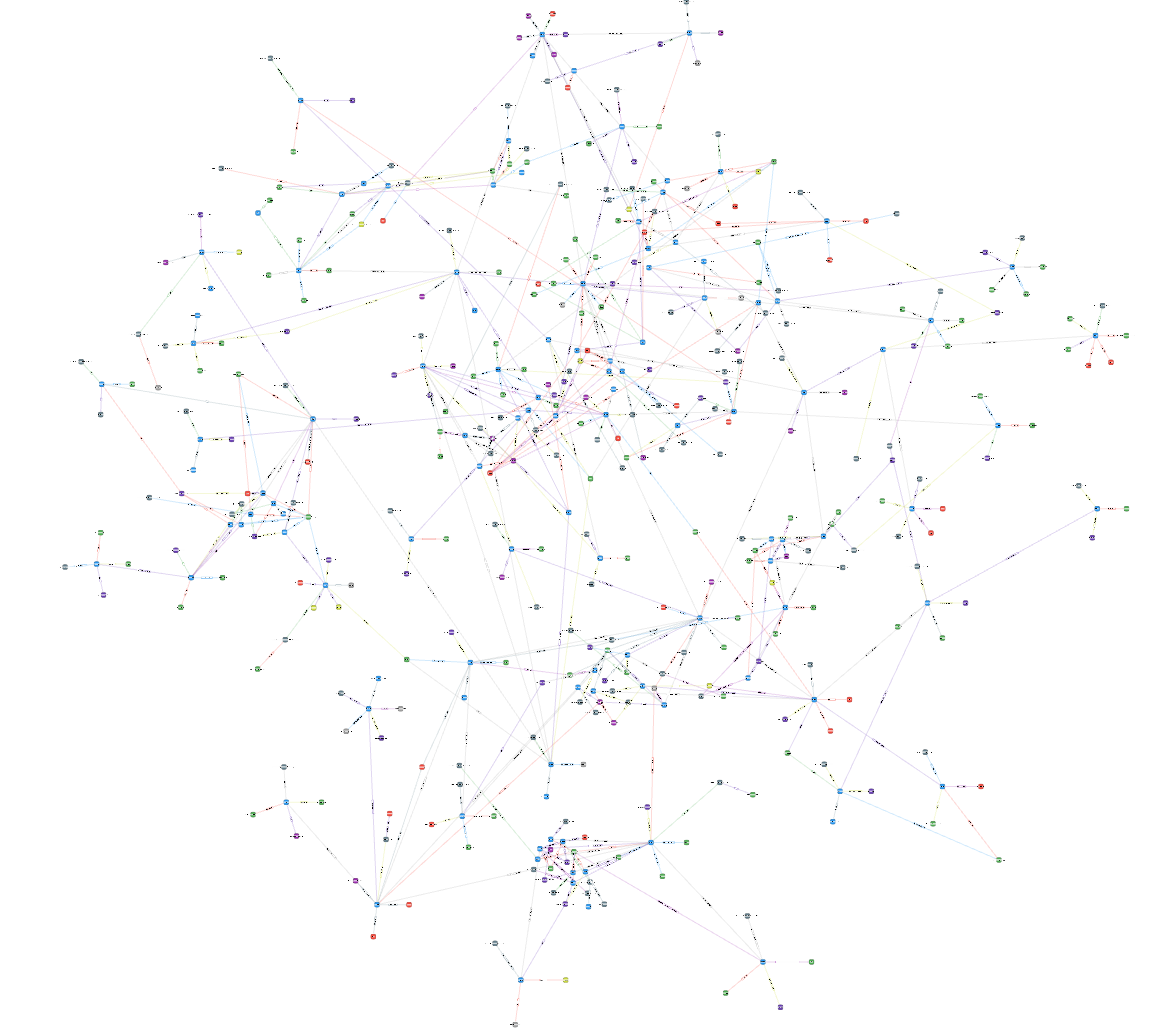



["Python"という単語を含むノードにつながるノードを全て抽出]

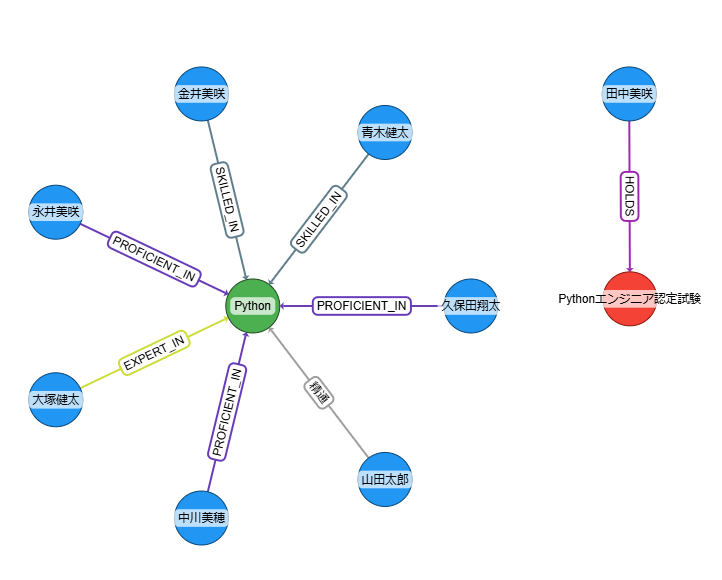

---

#### wikipage_1-16.txt (文字数:211,891)

<チャンク文字数閾値:3000, 総チャンク数:74, 総ノード数:1,917>

* 全体

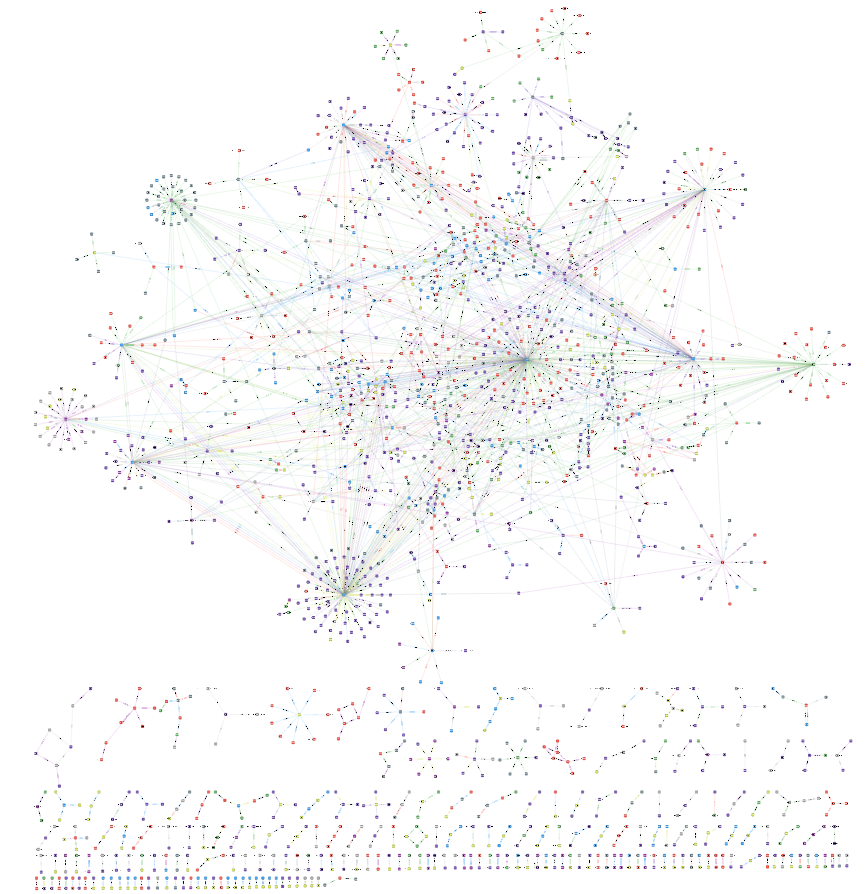

* question = "クッパはどういった特徴を持っていますか" -> 'MATCH (c:キャラクター {id: "クッパ"})-[r:HAS]->(f) RETURN c,r,f'

**!結果なし!**

<チャンク文字数閾値:100, 総チャンク数:2,394, 総ノード数:8,530>

* 全体

  
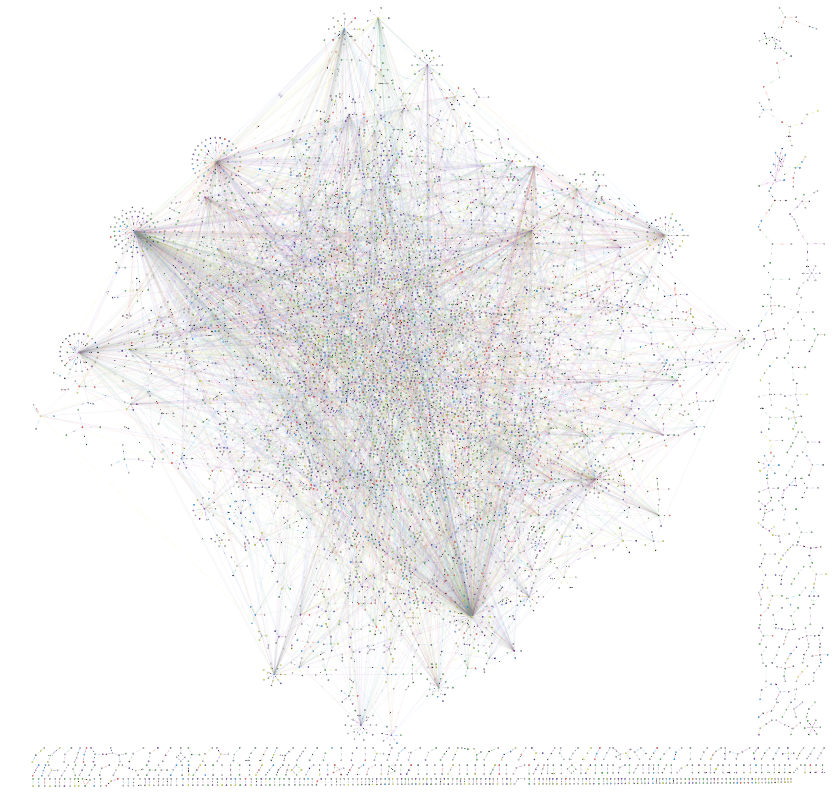

* question = "クッパはどういった特徴を持っていますか" -> 'MATCH (c:キャラクター {id: "クッパ"})-[r:HAS]->(f) RETURN c,r,f'

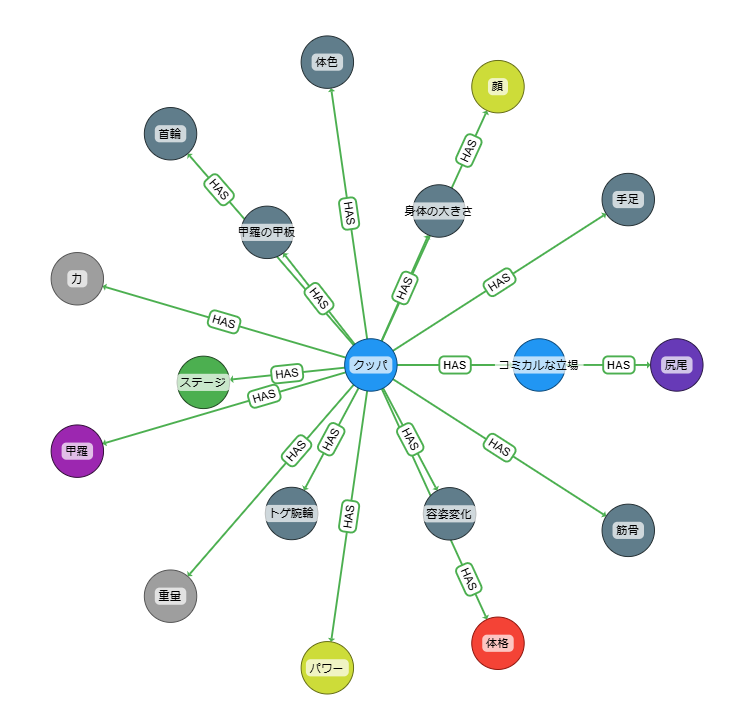

#### 5)　グラフデータを参照して回答生成

In [ ]:
import os
from typing import Tuple, List
from langchain_core.runnables import (
    RunnableBranch,
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate
from pydantic import BaseModel, Field
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_community.graphs import Neo4jGraph
from langchain_openai import ChatOpenAI
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars


チャットでの会話を成り立たせるために、ユーザーのオリジナルの質問とは別に、会話履歴も加味して改めて独立した質問文を作成する処理:

In [ ]:
_template = """Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question,
in its original language.
Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:"""
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

def _format_chat_history(chat_history: List[Tuple[str, str]]) -> List:
    buffer = []
    for human, ai in chat_history:
        buffer.append(HumanMessage(content=human))
        buffer.append(AIMessage(content=ai))
    return buffer

_search_query = RunnableBranch(
    (
        RunnableLambda(lambda x: bool(x.get("chat_history"))).with_config(
            run_name = "HasChatHistoryCheck"
        ),
        RunnablePassthrough.assign(
            chat_history=lambda x: _format_chat_history(x["chat_history"])
        )
        | CONDENSE_QUESTION_PROMPT
        | ChatOpenAI(temperature=0)
        | StrOutputParser(),
    ),
    RunnableLambda(lambda x : x["question"]),
)

#### グラフデータ（構造化データ）とベクトルデータ（非構造化データ）を組み合わせて、質問に対する回答を生成するためのRetrieverを定義

In [ ]:
import re

graph = Neo4jGraph()
graph.query(
    "CREATE FULLTEXT INDEX entity IF NOT EXISTS FOR (e:__Entity__) ON EACH [e.id]"
)

class Entities(BaseModel):
    names: List[str] = Field(
        ...,
        # description="All the persons, organizations, business entities, and material things that appear in the text",
        # 改良案
        description="A list of entities extracted from the text, including names of people, organizations, "
                    "businesses, and tangible objects. This class is used to structure and manage entity data "
                    "for further analysis or processing.",
        #　日本語版
        # description="文章の中に登場する、人物、各人物間の関係、各人物が所属する組織、各人物間の職業、各人物のスキルや資格",
        
    )

def generate_full_text_query(input: str) -> str:
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    for word in words[:-1]:
        full_text_query += f" {word} AND"
    full_text_query += f" {words[-1]}"
    return full_text_query.strip()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are extracting object entities from the text.",
        ),
        (
            "human",
            "Use the given format to extract object entities from the following input: {question}",
        ),
    ]
)
llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini") #gpt-4oだとなぜかエンティティが抽出されないのでgpt-4o-miniを設定
llm_2 = ChatOpenAI(temperature=0, model_name="gpt-4o-mini") 
entity_chain = prompt | llm.with_structured_output(Entities)






############# TEST：questionからCypherクエリ全体を生成させてみる
import ast
# グラフデータベースのメタデータ取得関数
def get_db_metadata():
    labels = [record['label'] for record in graph.query("CALL db.labels() YIELD label")]
    relationship_types = [record['relationshipType'] for record in graph.query("CALL db.relationshipTypes() YIELD relationshipType")]
    property_keys = [record['propertyKey'] for record in graph.query("CALL db.propertyKeys() YIELD propertyKey")]
    return labels, relationship_types, property_keys

labels, relationship_types, property_keys = get_db_metadata()
graph_structure_ = graph.query("MATCH (p)-[r:!MENTIONS]->(s) RETURN p.id + ' - ' + type(r) + ' -> ' + s.id As node_relation")
graph_structure = ", ".join([item['node_relation'] for item in graph_structure_]) #str化


# データベースに合わせて、LLMでクエリを自動生成
def generate_cypher_queries(question: str, labels, relationship_types, property_keys, graph_structure) -> List[str]:
    prompt_template = ChatPromptTemplate.from_template(
        """
        あなたは優秀なナレッジグラフ用のCypherクエリ生成AIです。
        ユーザからの以下の質問に対して関連する情報をナレッジグラフから取得できるCypherクエリを2つ生成してください。
        質問: 「{question}」

        クエリは必ず以下の[データベースの構造]に基づいて作成してください。
        プロパティキーとしては「id」のみ必ず使用し、ノード.idのように記述してください。.textは絶対に使用しないでください。
       
        クエリの作成においては、クエリ内でリレーションシップタイプを「(p1:A)-[:B]->(s:C)」のBのように明示的に指定するようにしてください。
        ただし、リレーションシップタイプが不要なケースについてはこの限りではないです。

            
        [注意事項]を全て守って正しい表記のクエリのみを作成してください。
    
        [データベースの構造]
        ・ラベル:
        {labels}
        ・リレーションシップタイプ:
        {relationship_types}
        ・プロパティキー:
        {property_keys}
        ・データ全体のナレッジグラフのノード間のリレーションシップ：
        {graph_structure}

        [注意事項]    
        1) RETURNは最後のoutput時以外、クエリの途中などで絶対に使用しないこと
        2) クエリの結果の行数を制限するLIMITを使う場合は、必ずAS outputの後にAS output LIMITのように配置すること
        3) RETURNの後ろでは、ASはAS outputの際に1つだけ使用し、1つ以上は絶対に使用してはならない
        3) WITHの後に記述する要素を区切る際には必ずコンマ(,)を記述すること（例えばWITH A,B, C COUNT(C) AS D ではC, COUNT(C) AS Dのように、CとCOUNT(C)の間にコンマが必要）
        4) クエリ中のCOLLECTで集計されたノード要素にはNode.idのように.idを必ず付け、.textは絶対に付けないこと    
        5) Cypherクエリの出力は必ずAS outputとして出力し、Outputは以下の[例1]のように必ず口語表現のstr形式に整形し、出力内容の意味がしっかりわかるような文章にすること。
        [例1]
        RETURN A + ' は ' + B + ' と ' +  C + ' という要素が共通しています。' AS output
        6)「YYであるXXはいくつ存在しますか？」のような特定の性質YYを持つ要素XXをカウントするような質問に対しては、以下の[例2]のようなCONTAINSを必ず含むクエリを作成すること。
        [例2]
        MATCH (p:XX) WHERE p.id CONTAINS YY WITH COUNT(p.id) AS Count RETURN 'YYであるXXは ' + Count + ' 件存在します。' AS output
        7)「YYとXXの関係について教えて下さい」のような2要素間の関係性を問うタイプの質問に対しては、必ず以下の[例3]のようなクエリを作成すること。
        [例3]
        MATCH (p1)-[s]-(p2) WHERE p1.id = "XX" AND p2.id = "YY" RETURN p1.id + ' と ' + p2.id + ' の関係は ' + type(s) + ' です。' AS output

        生成したクエリの出力形式は、str形式のCypherクエリのみの1つのList形式のみとしてください。
        出力に際しては余分な装飾（例えば ``` や '''python や```jsonなど）は一切含めず、文字列の配列のみを返してください。
        """
    )
    
    # プロンプトの作成と送信
    prompt = prompt_template.format(
        question = question, 
        labels = labels,
        relationship_types = relationship_types,
        property_keys = property_keys,
        graph_structure = graph_structure
    )
    response = llm.invoke(prompt)
    res_str = response.content
    # print("gencypherのresponse.content:")
    # print(res_str)
    
    # response.contentをリスト形式に変換
    try:
        # 最初の [ と最後の ] の間を抽出
        match = re.search(r"\[(.*)\]", res_str, re.DOTALL)
        queries_ = match.group(0) 
        queries = ast.literal_eval(queries_)  # 文字列形式のリストをPythonリストオブジェクトに変換
    except (SyntaxError, ValueError) as e:
        print("自動生成クエリ一覧のリスト形式の変換に失敗しました:", e)
        queries = []  # 変換に失敗した場合は空のリストを返す    

    return queries

# 自動生成クエリでretreive
def structured_retriever_gencypher(question: str, labels, relationship_types, property_keys, graph_structure) -> str:
    result = ""
    res_list= []
    # クエリ生成関数で複数のCypherクエリを生成
    cypher_queries = generate_cypher_queries(question, labels, relationship_types, property_keys, graph_structure)
    
    # 生成されたクエリを順に実行
    for query in cypher_queries:
        print("QUERY:",query)
        try:
            response = graph.query(
                query,  # 生成されたクエリをそのまま実行
                {"query": question}
            )
            # ヒットした情報を result に追加
            print("RESPONSE:",response)
            result += "\n".join(
                ["\n".join(el['output']) if isinstance(el['output'], list) else el['output'] for el in response]
            )
        except Exception as e:
            # エラーが発生した場合のメッセージ出力
            print(f"エラーが発生しました。\nエラーメッセージ: {str(e)}")        
            
    return result
############

def structured_retriever(question: str) -> str:
    result = ""
    entities = entity_chain.invoke({"question": question})
    for entity in entities.names:
        print(f"entity: {entity}")
        response = graph.query(
            """CALL db.index.fulltext.queryNodes('entity', $query, {limit:2})
            YIELD node,score
            CALL {
              WITH node
              MATCH (node)-[r:!MENTIONS]->(neighbor)
              RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output
              UNION ALL
              WITH node
              MATCH (node)<-[r:!MENTIONS]-(neighbor)
              RETURN neighbor.id + ' - ' + type(r) + ' -> ' +  node.id AS output
            }
            RETURN output
            """,
            {"query": generate_full_text_query(entity)},
        )
        # print(f"query: {generate_full_text_query(entity)}")
        result += "\n".join([el['output'] for el in response])
    return result

vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)

def retriever(question: str):
    print(f"Search query: {question}")
    
    # 一般的に使われている、質問文から抽出したエンティティ名から定型的なCypherクエリを作成するretreiver
    structured_data_1 = structured_retriever(question)
    # 今回試験的に導入した、質問文からCypherクエリをLLMに自動生成させるretreiver
    structured_data_2 = structured_retriever_gencypher(question, labels, relationship_types, property_keys, graph_structure)
    
    # テキストチャンクのベクトル（キーワード）検索
    unstructured_data = [el.page_content for el in vector_index.similarity_search(question, k=10)] #チャンク数kはここで調整
    
    #!!! Graphのみか、Vector+GraphのHybridかを選択
    use_vector = True
    use_graph = True
    
    print(f"Retreiver MODE: Vector:{use_vector} / Graph:{use_graph}")
    if use_vector and use_graph:
        final_data = f"""Structured data:
                    {structured_data_1}\n
                    {structured_data_2}
                    Unstructured data:
                    {"#Document ". join(unstructured_data)}
                    """
    #use_vector=True
    elif use_vector:
        final_data = f"""Unstructured data:
                    {"#Document ". join(unstructured_data)}
                    """
    #use_graph=True
    else:
        final_data = f"""Structured data:
                    {structured_data_1}\n
                    {structured_data_2}
                    """
    print(f"{final_data}")
    return final_data

template = """Answer the Question using only the following context:
{context}

Question: {question}
Use natural and polite language, and be concise in your answer.
Use the same language as the question.
Answer:"""
prompt = ChatPromptTemplate.from_template(template)
chain = (
    RunnableParallel(
        {
            "context": _search_query | retriever,
            "question": RunnablePassthrough(),
        }
    )
    | prompt
    | llm_2
    | StrOutputParser()
)

#### ***質問をして動作を確認***

In [ ]:
# 質問を入力してください:


# <定量的質問new>
# question = "データ分析または機械学習、AIの知見や経験、スキルのある社員を全員リストアップしてください。" #Q1
# question = "プロジェクト参加経験を持つ社員とそのプロジェクト名を全てリストアップしてください。" #Q2
# question = "統計検定1級を保有している社員は誰か？" #Q3
# question = "Pythonの使用経験や資格を持つ社員は誰で、この企業に何名いますか？" #Q4
# question = "データ関連のプロジェクトはいくつ存在しますか？" #Q5


# <定性的質問new>
# question = "社内で使用されている技術を全て調べ、全件の内容から他にどういった技術が社内にあるべきかを提案してください。" #Q6
# question = "山田太郎さんと佐藤花子さんの関係について詳細に教えてください"
# question = "社員の持つ資格(Qualfication, Certification)のうち、社員間で共通している件数が多い資格を挙げてください"
# question = """
#             この企業内で新規プロジェクトを企画することになりました。プロジェクトを成功させることができる、以下の{#スキル・知識}のどれかを持つ社員を
#             全社員に関する情報を基にぴったり20人探し出し、{#スキル・知識}ごとに整理し、それぞれの社員のプロジェクトにおける役割を明確にせよ。
#             回答の際は社員名の前に1から20の通し番号を付けること。
#             {#スキル・知識}
#             1. 音声認識
#             2. データ分析
#             3. クラウド
#             4. 自然言語処理
#             5. データ可視化
#             """   

# question = "どういうジャンルのプロジェクトが主に企画されてますか？" #Q10




question = "ピーチが登場するものを全て挙げて下さい" 

   
result = chain.invoke({"question": question})

result

#### Analytics_Dummy.txtでの検証結果memo (2024/10/28)




**Q0 "社員が取得している資格で多いのは何ですか？"**

* Vector
  
<取得情報>
entity: プロジェクト
entity: 社員

text: 名前：石井美智子

石井美智子は、データ教育の専門家であり、社内外向けのデータリテラシー研修を担当。「データリテラシー向上プロジェクト」で教育プログラムを開発した。教育学修士号を持つ。橋本大輔と協力して、社員のデータ活用スキル向上に努めた#Document 
text: 名前：清水舞

清水舞は、プロジェクトマネージャーとして多くのデータプロジェクトをリード。「サプライチェーン最適化プロジェクト」でチームを統括し、効率的なプロジェクト進行を実現した。PMP資格を持ち、チーム内のコミュニケーションを円滑にする能力に長けている。山田太郎や佐藤花子と協力し、プロジェクトの成功に導いた#Document 
text: 名前：宮崎大輔

宮崎大輔は、データセキュリティの専門家で、「セキュリティ監査プロジェクト」で社内のセキュリティ体制を評価。情報セキュリティスペシャリスト資格を持つ。池田恵と協力して、改善策を提案。

名前：平田彩

平田彩は、データサイエンスの教育担当で、「データ分析研修プログラム」で社員教育を担当。教育学博士号を持つ。坂本彩と協力して、教育プログラムを開発#Document 
text: 名前：石川紗季

石川紗季は、データ品質管理のエキスパートで、「データ標準化プロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ管理プロセスを最適化。

名前：松井大輔

松井大輔は、ディープラーニングのエンジニアで、「音声認識システム開発プロジェクト」でモデル構築を担当。PyTorchに精通。西村亮太と共同で音声認識モデルの性能を向上#Document 
text: 名前：佐藤花子

佐藤花子は、統計学の博士号を持つデータアナリストであり、統計的手法によるデータ解析に強みを持つ。彼女は「金融リスク評価プロジェクト」で統計モデルの構築と評価を担当し、リスク管理の効率化に貢献した。資格として統計検定1級を取得しており、山田太郎とは長年の同僚で、彼のプログラミングスキルと彼女の統計知識を組み合わせて多くのプロジェクトを成功させている#Document 
text: 名前：三浦拓也

三浦拓也は、ネットワーク分析の専門家で、「ソーシャルネットワーク分析プロジェクト」で人間関係の可視化を行った。ネットワーク分析士資格を持つ。中島徹と協力し、組織内コミュニケーションの改善に貢献#Document 
text: 名前：岡田真由美

岡田真由美は、データストーリーテリングの専門家で、「経営報告資料作成プロジェクト」でデータを分かりやすく伝える役割を担った。ビジネスコミュニケーション資格を持つ。加藤愛と協力して、視覚的な資料作成に貢献#Document 
text: 名前：岩田美咲

岩田美咲は、データサイエンスの教育者で、「データリテラシー研修プロジェクト」で社員教育を担当。教育学学士号を持つ。斉藤真由と協力して、教育プログラムを開発。

名前：石原大輔

石原大輔は、データセキュリティの専門家で、「データ漏洩防止プロジェクト」でセキュリティ体制を強化。情報セキュリティマネジメント資格を持つ。池田恵と協業し、セキュリティ強化を推進#Document 
text: 名前：山田美咲

山田美咲は、データガバナンスの専門家で、「データポリシー策定プロジェクト」で社内規定を整備。データガバナンス資格を持つ。菊地愛美と協力し、データ管理体制を強化#Document 
text: 名前：伊藤美咲

伊藤美咲は、データ品質管理のエキスパートで、「データ標準化プロジェクト」でデータの一貫性と信頼性を確保。データ品質管理士資格を持ち、データのクレンジングや統合に精通している。佐久間美穂と協業し、データ品質向上のプロセスを最適化。過去には「医療データ管理プロジェクト」でデータの精度向上に貢献した


[回答]

「社員が取得している資格で多いのは、データ品質管理士資格と情報セキュリティ関連の資格です。」

-> 正解
(データ品質管理士資格3名、情報セキュリティ関連の資格6名)


* Graph
* <取得情報>
entity: 社員
entity: 資格

社員 - HAS -> データ活用スキル
石井美智子 - IMPROVED_SKILLS_OF -> 社員
石井美智子 - CONTRIBUTE -> 社員のスキルアップ片山健太 - HOLDS_QUALIFICATION -> データベーススペシャリスト資格
上田和也 - HOLDS -> データベーススペシャリスト資格
村田彩 - HAS_QUALIFICATION -> ビジネスアナリシス資格
橋本大輔 - HAS_QUALIFICATION -> ビジネスアナリシス資格

[回答]
'社員が取得している資格で多いのは、ビジネスアナリシス資格です。'
(2名)
-> 不正解

* ***Graph（クエリ生成新方式）***

<取得情報>
(自動生成されたクエリ)
QUERY: MATCH (p:Person)-[:HAS_CERTIFICATION]->(c:Certification) WITH c, COUNT(p) AS count ORDER BY count DESC LIMIT 1 RETURN '社員が最も取得している資格は ' + c.id + ' で、取得者数は ' + count + ' 人です。' AS output
RESPONSE: 社員が最も取得している資格は Google Cloud認定資格 で、取得者数は 1 人です。
QUERY: MATCH (p:Person)-[]->(c:Certification) WITH c, COUNT(p) AS count ORDER BY count DESC LIMIT 1 RETURN '社員が最も取得している資格は ' + c.id + ' で、取得者数は ' + count + ' 人です。' AS output
RESPONSE: 社員が最も取得している資格は 統計検定1級 で、取得者数は 5 人です。
QUERY: MATCH (p:Person)-[:HAS_CERTIFICATION]->(c) WITH c, COUNT(p) AS count RETURN c.id, count ORDER BY count DESC LIMIT 1 RETURN '社員が最も取得している資格は ' + c.id + ' で、取得者数は ' + count + ' 人です。' AS output
エラーが発生しました。
エラーメッセージ: {code: Neo.ClientError.Statement.SyntaxError} {message: Variable `c` not defined (line 1, column 144 (offset: 143))
"MATCH (p:Person)-[:HAS_CERTIFICATION]->(c) WITH c, COUNT(p) AS count RETURN c.id, count ORDER BY count DESC LIMIT 1 RETURN '社員が最も取得している資格は ' + c.id + ' で、取得者数は ' + count + ' 人です。' AS output"
                                                                                                                                                ^}
QUERY: MATCH (p:Person)-[]->(c) WITH c, COUNT(p) AS count RETURN c.id, count ORDER BY count DESC LIMIT 1 RETURN '社員が最も取得している資格は ' + c.id + ' で、取得者数は ' + count + ' 人です。' AS output
エラーが発生しました。
エラーメッセージ: {code: Neo.ClientError.Statement.SyntaxError} {message: Variable `c` not defined (line 1, column 126 (offset: 125))
"MATCH (p:Person)-[]->(c) WITH c, COUNT(p) AS count RETURN c.id, count ORDER BY count DESC LIMIT 1 RETURN '社員が最も取得している資格は ' + c.id + ' で、取得者数は ' + count + ' 人です。' AS output"
                                                                                                                              ^}
Structured data:
                    社員が最も取得している資格は Google Cloud認定資格 で、取得者数は 1 人です。社員が最も取得している資格は 統計検定1級 で、取得者数は 5 人です。


[回答]
「社員が取得している資格で最も多いのは、統計検定1級で、取得者数は5人です」

→正解!

 （単体の資格では統計検定1級が最も多い)

* Vector+Graph

<取得情報>

QUERY: MATCH (p:Person)-[:HAS_CERTIFICATION]->(c:Certification) WITH c, COUNT(p) AS count ORDER BY count DESC LIMIT 1 RETURN '社員が最も取得している資格は ' + c.id + ' で、取得者数は ' + count + ' 人です。' AS output
RESPONSE: 社員が最も取得している資格は Google Cloud認定資格 で、取得者数は 1 人です。
QUERY: MATCH (p:Person)-[:HAS_CERTIFICATION]->(c) WITH c, COUNT(p) AS count ORDER BY count DESC LIMIT 1 RETURN '社員が最も取得している資格は ' + c.id + ' で、取得者数は ' + count + ' 人です。' AS output
RESPONSE: 社員が最も取得している資格は Google Cloud認定資格 で、取得者数は 1 人です。
QUERY: MATCH (p:Person)-[]->(c:Certification) WITH c, COUNT(p) AS count ORDER BY count DESC LIMIT 1 RETURN '社員が最も取得している資格は ' + c.id + ' で、取得者数は ' + count + ' 人です。' AS output
RESPONSE: 社員が最も取得している資格は 統計検定1級 で、取得者数は 5 人です。
QUERY: MATCH (p:Person)-[]->(c) WITH c, COUNT(p) AS count ORDER BY count DESC LIMIT 1 RETURN '社員が最も取得している資格は ' + c.id + ' で、取得者数は ' + count + ' 人です。' AS output
RESPONSE: 社員が最も取得している資格は Python で、取得者数は 7 人です。
Structured data:
                    社員が最も取得している資格は Google Cloud認定資格 で、取得者数は 1 人です。社員が最も取得している資格は Google Cloud認定資格 で、取得者数は 1 人です。社員が最も取得している資格は 統計検定1級 で、取得者数は 5 人です。社員が最も取得している資格は Python で、取得者数は 7 人です。
                    Unstructured data:
                    
text: 名前：石井美智子

石井美智子は、データ教育の専門家であり、社内外向けのデータリテラシー研修を担当。「データリテラシー向上プロジェクト」で教育プログラムを開発した。教育学修士号を持つ。橋本大輔と協力して、社員のデータ活用スキル向上に努めた#Document 
text: 名前：清水舞

清水舞は、プロジェクトマネージャーとして多くのデータプロジェクトをリード。「サプライチェーン最適化プロジェクト」でチームを統括し、効率的なプロジェクト進行を実現した。PMP資格を持ち、チーム内のコミュニケーションを円滑にする能力に長けている。山田太郎や佐藤花子と協力し、プロジェクトの成功に導いた#Document 
text: 名前：宮崎大輔

宮崎大輔は、データセキュリティの専門家で、「セキュリティ監査プロジェクト」で社内のセキュリティ体制を評価。情報セキュリティスペシャリスト資格を持つ。池田恵と協力して、改善策を提案。

名前：平田彩

平田彩は、データサイエンスの教育担当で、「データ分析研修プログラム」で社員教育を担当。教育学博士号を持つ。坂本彩と協力して、教育プログラムを開発#Document 
text: 名前：石川紗季

石川紗季は、データ品質管理のエキスパートで、「データ標準化プロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ管理プロセスを最適化。

名前：松井大輔

松井大輔は、ディープラーニングのエンジニアで、「音声認識システム開発プロジェクト」でモデル構築を担当。PyTorchに精通。西村亮太と共同で音声認識モデルの性能を向上#Document 
text: 名前：佐藤花子

佐藤花子は、統計学の博士号を持つデータアナリストであり、統計的手法によるデータ解析に強みを持つ。彼女は「金融リスク評価プロジェクト」で統計モデルの構築と評価を担当し、リスク管理の効率化に貢献した。資格として統計検定1級を取得しており、山田太郎とは長年の同僚で、彼のプログラミングスキルと彼女の統計知識を組み合わせて多くのプロジェクトを成功させている#Document 
text: 名前：三浦拓也

三浦拓也は、ネットワーク分析の専門家で、「ソーシャルネットワーク分析プロジェクト」で人間関係の可視化を行った。ネットワーク分析士資格を持つ。中島徹と協力し、組織内コミュニケーションの改善に貢献#Document 
text: 名前：岡田真由美

岡田真由美は、データストーリーテリングの専門家で、「経営報告資料作成プロジェクト」でデータを分かりやすく伝える役割を担った。ビジネスコミュニケーション資格を持つ。加藤愛と協力して、視覚的な資料作成に貢献#Document 
text: 名前：岩田美咲

岩田美咲は、データサイエンスの教育者で、「データリテラシー研修プロジェクト」で社員教育を担当。教育学学士号を持つ。斉藤真由と協力して、教育プログラムを開発。

名前：石原大輔

石原大輔は、データセキュリティの専門家で、「データ漏洩防止プロジェクト」でセキュリティ体制を強化。情報セキュリティマネジメント資格を持つ。池田恵と協業し、セキュリティ強化を推進#Document 
text: 名前：山田美咲

山田美咲は、データガバナンスの専門家で、「データポリシー策定プロジェクト」で社内規定を整備。データガバナンス資格を持つ。菊地愛美と協力し、データ管理体制を強化#Document 
text: 名前：伊藤美咲

伊藤美咲は、データ品質管理のエキスパートで、「データ標準化プロジェクト」でデータの一貫性と信頼性を確保。データ品質管理士資格を持ち、データのクレンジングや統合に精通している。佐久間美穂と協業し、データ品質向上のプロセスを最適化。過去には「医療データ管理プロジェクト」でデータの精度向上に貢献した
                    
[回答]

'社員が最も取得している資格は「統計検定1級」で、取得者数は5人です。'

→正解!

 （Graphの取得得情を採用、単体の資格では統計検定1級が最も多い)

-----

**Q1 データ分析または機械学習、AIの知見や経験、スキルのある社員を全員リストアップしてください。**


Vector

<取得情報>

entity: データ分析
entity: 機械学習
entity: AI
entity: 知見
entity: 経験
entity: スキル
entity: 社員

Unstructured data:
                    
text: 名前：伊藤亮

伊藤亮は、機械学習エンジニアとしてモデルの最適化とチューニングを専門としている。「需要予測モデル改善プロジェクト」でアルゴリズムの改良を行い、予測精度を大幅に向上させた。資格としてAzure AIエンジニア認定を持つ。高橋健太と協力して、モデルのデプロイメントとスケーラビリティの向上に努めた。彼らのチームワークは社内でも高く評価されている#Document 
text: 名前：川口健太郎

川口健太郎は、機械学習の自動化に取り組み、「AutoML導入プロジェクト」でモデル開発の効率化を実現。機械学習エンジニア資格を持つ。伊藤亮と協業し、モデル開発プロセスの最適化を推進#Document 
text: 名前：久保田翔太

久保田翔太は、機械学習のエンジニアで、「推薦システム開発プロジェクト」でパーソナライズドモデルを構築。PythonとScikit-learnに精通。伊藤亮と協力して、モデルの性能を高めた。

名前：佐久間美穂

佐久間美穂は、データ品質管理のエキスパートで、「データクレンジングプロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ品質を向上#Document 
text: 名前：石川紗季

石川紗季は、データ品質管理のエキスパートで、「データ標準化プロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ管理プロセスを最適化。

名前：松井大輔

松井大輔は、ディープラーニングのエンジニアで、「音声認識システム開発プロジェクト」でモデル構築を担当。PyTorchに精通。西村亮太と共同で音声認識モデルの性能を向上#Document 
text: 名前：菊地愛美

菊地愛美は、データガバナンスの専門家で、「データ管理体制強化プロジェクト」でポリシーの策定を担当。データガバナンス資格を持つ。池田恵と協業し、セキュリティとガバナンスの統合を推進。

名前：村上亮介

村上亮介は、クラスタリング分析に強みを持ち、「顧客セグメンテーションプロジェクト」で新たな顧客層を発見。統計検定2級を取得。福田真由と協力し、マーケティング戦略の立案に寄与#Document 
text: 名前：鈴木一郎

鈴木一郎は、AIエンジニアとしてディープラーニングを専門とし、特に画像認識分野での経験が豊富である。「製造業向け不良品検知プロジェクト」では、CNNを用いたモデルの開発と導入をリードした。彼はG検定を取得しており、最新のAI技術にも精通している。彼は佐藤花子と共同でデータ前処理とモデル評価を行い、プロジェクトの精度向上に寄与した#Document 
text: 名前：田中美咲

田中美咲は、自然言語処理（NLP）の専門家であり、テキストデータの分析とモデル構築に強みを持つ。彼女は「顧客レビューの感情分析プロジェクト」で主導的な役割を果たし、顧客満足度の向上に貢献した。資格としてPythonエンジニア認定試験を取得。鈴木一郎と協力して、モデルの精度向上と最適化を行った。彼との協業で新しいアルゴリズムの導入にも成功している#Document 
text: 名前：片山健太

片山健太は、データエンジニアで、「ETLプロセス最適化プロジェクト」でデータ処理効率を向上。データベーススペシャリスト資格を持つ。上田和也と協力し、データパイプラインを最適化。

名前：本間彩

本間彩は、統計解析の専門家で、「アンケートデータ分析プロジェクト」で顧客の声を解析。統計検定1級を取得。佐藤花子と協業し、統計モデルの精度を向上#Document 
text: 名前：佐々木亮介

佐々木亮介は、IoTデータの解析に強みを持つデータサイエンティスト。「スマートシティデータ分析プロジェクト」でセンサーデータの解析を担当した。IoT検定の資格を持つ。森田翔と協力して、大量のセンサーデータの効率的な処理を実現した#Document 
text: 名前：安藤翔太

安藤翔太は、データインフラのエンジニアとして、「データレイク構築プロジェクト」でクラウドベースのデータストレージを設計。AWSソリューションアーキテクト資格を保有。高橋健太と協力して、データ基盤の強化を行った
                    

[回答]
'以下の社員がデータ分析または機械学習、AIの知見や経験、スキルを持っています。
1. 伊藤亮 - 機械学習エンジニア
2. 川口健太郎 - 機械学習エンジニア
3. 久保田翔太 - 機械学習エンジニア
4. 松井大輔 - ディープラーニングエンジニア
5. 鈴木一郎 - AIエンジニア\n6. 田中美咲 - 自然言語処理専門家\n7. 佐々木亮介 - データサイエンティスト\n\n以上の社員が該当します。'



Hybrid

<取得情報>

entity: データ分析
entity: 機械学習
entity: AI
entity: 知見
entity: 経験
entity: スキル
entity: 社員
QUERY: MATCH (p:Person)-[:HAS_SKILL]->(s:Skill) WHERE s.id CONTAINS 'データ分析' OR s.id CONTAINS '機械学習' OR s.id CONTAINS 'AI' RETURN COLLECT(p.id) AS output
RESPONSE: [{'output': []}]
QUERY: MATCH (p:Person)-[:HAS_SKILL]->(s) WHERE s.id CONTAINS 'データ分析' OR s.id CONTAINS '機械学習' OR s.id CONTAINS 'AI' RETURN COLLECT(p.id) AS output
RESPONSE: [{'output': []}]
QUERY: MATCH (p:Person)-[:HAS_OCCUPATION]->(o:Occupation)-[:SPECIALIST_IN]->(t:Technology) WHERE t.id CONTAINS 'データ分析' OR t.id CONTAINS '機械学習' OR t.id CONTAINS 'AI' RETURN COLLECT(p.id) AS output
RESPONSE: [{'output': []}]
QUERY: MATCH (p:Person)-[:HAS_OCCUPATION]->(o:Occupation)-[]->(t) WHERE t.id CONTAINS 'データ分析' OR t.id CONTAINS '機械学習' OR t.id CONTAINS 'AI' RETURN COLLECT(p.id) AS output
RESPONSE: [{'output': []}]
QUERY: MATCH (p:Person)-[:HAS_CERTIFICATION]->(c:Certification) WHERE c.id CONTAINS 'データ分析' OR c.id CONTAINS '機械学習' OR c.id CONTAINS 'AI' RETURN COLLECT(p.id) AS output
RESPONSE: [{'output': []}]
QUERY: MATCH (p:Person)-[:HAS_CERTIFICATION]->(c) WHERE c.id CONTAINS 'データ分析' OR c.id CONTAINS '機械学習' OR c.id CONTAINS 'AI' RETURN COLLECT(p.id) AS output
RESPONSE: [{'output': []}]
Structured data:
中村優子 - PERFORMED -> データ分析
平田彩 - RESPONSIBLE_FOR -> データ分析研修プログラム本田拓也 - KNOWLEDGEABLE_IN -> 機械学習
岡崎翔太 - EXPERT_IN -> 機械学習
久保田翔太 - EXPERT_IN -> 機械学習
長谷川翔太 - ENGINEER_IN -> 機械学習
山口真由美 - RESEARCH_DEVELOPMENT -> 機械学習
伊藤亮 - SPECIALIZES_IN -> 機械学習エンジニア吉田健太郎 - HAS_ROLE -> Aiプロダクトマネージャー
鈴木一郎 - SPECIALIZES_IN -> Aiエンジニア田村翔 - PROVIDE_INSIGHT -> パターン発見プロジェクト
佐藤花子 - HAS_SKILL -> 統計知識視覚的なレポート - FOR -> 経営層
田中美咲 - HOLDS -> Pythonエンジニア認定試験社員 - HAS -> データ活用スキル社員 - HAS -> データ活用スキル
石井美智子 - IMPROVED_SKILLS_OF -> 社員
石井美智子 - CONTRIBUTE -> 社員のスキルアップ

                    
Unstructured data:
                    
text: 名前：伊藤亮

伊藤亮は、機械学習エンジニアとしてモデルの最適化とチューニングを専門としている。「需要予測モデル改善プロジェクト」でアルゴリズムの改良を行い、予測精度を大幅に向上させた。資格としてAzure AIエンジニア認定を持つ。高橋健太と協力して、モデルのデプロイメントとスケーラビリティの向上に努めた。彼らのチームワークは社内でも高く評価されている#Document 
text: 名前：川口健太郎

川口健太郎は、機械学習の自動化に取り組み、「AutoML導入プロジェクト」でモデル開発の効率化を実現。機械学習エンジニア資格を持つ。伊藤亮と協業し、モデル開発プロセスの最適化を推進#Document 
text: 名前：久保田翔太

久保田翔太は、機械学習のエンジニアで、「推薦システム開発プロジェクト」でパーソナライズドモデルを構築。PythonとScikit-learnに精通。伊藤亮と協力して、モデルの性能を高めた。

名前：佐久間美穂

佐久間美穂は、データ品質管理のエキスパートで、「データクレンジングプロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ品質を向上#Document 
text: 名前：石川紗季

石川紗季は、データ品質管理のエキスパートで、「データ標準化プロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ管理プロセスを最適化。

名前：松井大輔

松井大輔は、ディープラーニングのエンジニアで、「音声認識システム開発プロジェクト」でモデル構築を担当。PyTorchに精通。西村亮太と共同で音声認識モデルの性能を向上#Document 
text: 名前：菊地愛美

菊地愛美は、データガバナンスの専門家で、「データ管理体制強化プロジェクト」でポリシーの策定を担当。データガバナンス資格を持つ。池田恵と協業し、セキュリティとガバナンスの統合を推進。

名前：村上亮介

村上亮介は、クラスタリング分析に強みを持ち、「顧客セグメンテーションプロジェクト」で新たな顧客層を発見。統計検定2級を取得。福田真由と協力し、マーケティング戦略の立案に寄与#Document 
text: 名前：鈴木一郎

鈴木一郎は、AIエンジニアとしてディープラーニングを専門とし、特に画像認識分野での経験が豊富である。「製造業向け不良品検知プロジェクト」では、CNNを用いたモデルの開発と導入をリードした。彼はG検定を取得しており、最新のAI技術にも精通している。彼は佐藤花子と共同でデータ前処理とモデル評価を行い、プロジェクトの精度向上に寄与した#Document 
text: 名前：田中美咲

田中美咲は、自然言語処理（NLP）の専門家であり、テキストデータの分析とモデル構築に強みを持つ。彼女は「顧客レビューの感情分析プロジェクト」で主導的な役割を果たし、顧客満足度の向上に貢献した。資格としてPythonエンジニア認定試験を取得。鈴木一郎と協力して、モデルの精度向上と最適化を行った。彼との協業で新しいアルゴリズムの導入にも成功している#Document 
text: 名前：片山健太

片山健太は、データエンジニアで、「ETLプロセス最適化プロジェクト」でデータ処理効率を向上。データベーススペシャリスト資格を持つ。上田和也と協力し、データパイプラインを最適化。

名前：本間彩

本間彩は、統計解析の専門家で、「アンケートデータ分析プロジェクト」で顧客の声を解析。統計検定1級を取得。佐藤花子と協業し、統計モデルの精度を向上#Document 
text: 名前：佐々木亮介

佐々木亮介は、IoTデータの解析に強みを持つデータサイエンティスト。「スマートシティデータ分析プロジェクト」でセンサーデータの解析を担当した。IoT検定の資格を持つ。森田翔と協力して、大量のセンサーデータの効率的な処理を実現した#Document 
text: 名前：安藤翔太

安藤翔太は、データインフラのエンジニアとして、「データレイク構築プロジェクト」でクラウドベースのデータストレージを設計。AWSソリューションアーキテクト資格を保有。高橋健太と協力して、データ基盤の強化を行った


[回答]
         
'データ分析または機械学習、AIの知見や経験、スキルのある社員は以下の通りです。
1. 中村優子 - データ分析　（Graph）(Vectorで漏れ!)
2. 平田彩 - データ分析研修プログラム （Graph）(Vectorで漏れ!)
3. 本田拓也 - 機械学習 （Graph）(Vectorで漏れ!)
4. 岡崎翔太 - 機械学習 （Graph）(Vectorで漏れ!)
5. 久保田翔太 - 機械学習（Vector, Graph）
6. 長谷川翔太 - 機械学習 （Graph）(Vectorで漏れ!)
7. 山口真由美 - 機械学習 （Graph）(Vectorで漏れ!)
8. 伊藤亮 - 機械学習エンジニア（Vector, Graph）
9. 吉田健太郎 - Aiプロダクトマネージャー （Graph）(Vectorで漏れ!)
10. 鈴木一郎 - Aiエンジニア（Vector, Graph）
11. 田村翔 - パターン発見プロジェクト（Graph）(Vectorで漏れ!)
12. 佐藤花子 - 統計知識（Graph）(Vectorで漏れ!)
13. 田中美咲 - データ活用スキル（Vector）

以上の社員が該当します。'

[参考：Vector回答]
'以下の社員がデータ分析または機械学習、AIの知見や経験、スキルを持っています。
1. 伊藤亮 - 機械学習エンジニア
2. 川口健太郎 - 機械学習エンジニア (Hybridで漏れ!)
3. 久保田翔太 - 機械学習エンジニア
4. 松井大輔 - ディープラーニングエンジニア (Hybridで漏れ!)
5. 鈴木一郎 - AIエンジニア
6. 田中美咲 - 自然言語処理専門家
7. 佐々木亮介 - データサイエンティスト(Hybridで漏れ!)

以上の社員が該当します。'

---

**Q2 プロジェクト参加経験を持つ社員を全員リストアップしてください。**

* Vector

<取得情報>
text: 名前：木村紗英

木村紗英は、アジャイル開発のプロジェクトマネージャーで、「データプラットフォーム刷新プロジェクト」をリード。スクラムマスター資格を持つ。清水舞と協力して、プロジェクトの迅速な進行を実現。

名前：松田裕

松田裕は、GISデータの専門家で、「店舗立地最適化プロジェクト」で地理空間データの分析を担当。GIS検定資格を持つ。佐々木亮介と協力して、空間データの効率的な活用を推進#Document 
text: 名前：橋本大輔

橋本大輔は、データストラテジストとして企業のデータ活用戦略を策定。「データドリブン経営推進プロジェクト」で全社的なデータ活用の指針を作成した。ビジネスアナリシス資格を持ち、中村優子と協業して経営戦略にデータを活用する取り組みを推進した#Document 
text: 名前：岡田真由美

岡田真由美は、データストーリーテリングの専門家で、「経営報告資料作成プロジェクト」でデータを分かりやすく伝える役割を担った。ビジネスコミュニケーション資格を持つ。加藤愛と協力して、視覚的な資料作成に貢献#Document 
text: 名前：中村彩

中村彩は、データアナリティクスのコンサルタントで、「ビジネスデータ活用戦略プロジェクト」で企業のデータ活用を支援。MBAを取得。橋本大輔と協力し、データ戦略の策定に寄与。

名前：林健太郎

林健太郎は、クラウドネイティブの専門家で、「クラウド最適化プロジェクト」でシステムのクラウド移行を担当。Google Cloud認定資格を持つ。渡辺翔太と協業し、クラウド環境の最適化を実現#Document 
text: 名前：安藤翔太

安藤翔太は、データインフラのエンジニアとして、「データレイク構築プロジェクト」でクラウドベースのデータストレージを設計。AWSソリューションアーキテクト資格を保有。高橋健太と協力して、データ基盤の強化を行った#Document 
text: 名前：岩田美咲

岩田美咲は、データサイエンスの教育者で、「データリテラシー研修プロジェクト」で社員教育を担当。教育学学士号を持つ。斉藤真由と協力して、教育プログラムを開発。

名前：石原大輔

石原大輔は、データセキュリティの専門家で、「データ漏洩防止プロジェクト」でセキュリティ体制を強化。情報セキュリティマネジメント資格を持つ。池田恵と協業し、セキュリティ強化を推進#Document 
text: 名前：佐藤大輔

佐藤大輔は、データ品質保証のスペシャリストで、「データ検証プロジェクト」でデータの正確性を確保。品質管理検定を取得。石田美穂と協力して、データ品質の向上に努めた。

名前：高田健太

高田健太は、データエンジニアリングのリーダーで、「データウェアハウス構築プロジェクト」を指揮。AWS認定ビッグデータ資格を持つ。高橋健太と協業し、データ基盤を強化#Document 
text: 名前：石川紗季

石川紗季は、データ品質管理のエキスパートで、「データ標準化プロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ管理プロセスを最適化。

名前：松井大輔

松井大輔は、ディープラーニングのエンジニアで、「音声認識システム開発プロジェクト」でモデル構築を担当。PyTorchに精通。西村亮太と共同で音声認識モデルの性能を向上#Document 
text: 名前：遠藤美穂

遠藤美穂は、ビジネスインテリジェンスの専門家で、「経営指標分析プロジェクト」で経営層へのデータ提供を担当。BIスペシャリスト資格を持つ。岡田真由美と協力し、経営判断を支援。

名前：長谷川翔太

長谷川翔太は、機械学習のエンジニアで、「画像認識モデル最適化プロジェクト」でモデルの高速化を実現。TensorFlowに精通。鈴木一郎と協業し、モデルのパフォーマンスを向上#Document 
text: 名前：久保田翔太

久保田翔太は、機械学習のエンジニアで、「推薦システム開発プロジェクト」でパーソナライズドモデルを構築。PythonとScikit-learnに精通。伊藤亮と協力して、モデルの性能を高めた。

名前：佐久間美穂

佐久間美穂は、データ品質管理のエキスパートで、「データクレンジングプロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ品質を向上

[回答]

'以下の社員がプロジェクト参加経験を持っています。
1. 木村紗英 - データプラットフォーム刷新プロジェクト
2. 松田裕 - 店舗立地最適化プロジェクト
3. 橋本大輔 - データドリブン経営推進プロジェクト
4. 岡田真由美 - 経営報告資料作成プロジェクト
5. 中村彩 - ビジネスデータ活用戦略プロジェクト
6. 林健太郎 - クラウド最適化プロジェクト
7. 安藤翔太 - データレイク構築プロジェクト
8. 岩田美咲 - データリテラシー研修プロジェクト
9. 石原大輔 - データ漏洩防止プロジェクト
10. 佐藤大輔 - データ検証プロジェクト
11. 高田健太 - データウェアハウス構築プロジェクト
12. 石川紗季 - データ標準化プロジェクト
13. 松井大輔 - 音声認識システム開発プロジェクト
14. 遠藤美穂 - 経営指標分析プロジェクト
15. 長谷川翔太 - 画像認識モデル最適化プロジェクト
16. 久保田翔太 - 推薦システム開発プロジェクト
17. 佐久間美穂 - データクレンジングプロジェクト'



* Hybrid

<取得情報>
entity: プロジェクト
entity: 社員

QUERY: MATCH (p:Person)-[:PARTICIPATES_IN]->(proj:Project) WITH p.id AS employeeId, proj.id AS projectId RETURN employeeId + ' はプロジェクト ' + projectId + ' に参加しています。' AS output

Structured data:
森田翔 - WORKED_ON -> リアルタイムデータ分析プロジェクト
クラウド移行プロジェクト - MIGRATED_TO -> Aws
クラウド移行プロジェクト - MIGRATED_FROM -> オンプレミス
渡辺翔太 - PARTICIPATED_IN -> クラウド移行プロジェクト社員 - HAS -> データ活用スキル
石井美智子 - IMPROVED_SKILLS_OF -> 社員
石井美智子 - CONTRIBUTE -> 社員のスキルアップ

橋本大輔 はプロジェクト データドリブン経営推進プロジェクト に参加しています。柴田翔 はプロジェクト 最適化アルゴリズム開発プロジェクト に参加しています。
坂本彩 はプロジェクト 社内データサイエンス研修プロジェクト に参加しています。
青木健太 はプロジェクト チャットボット開発プロジェクト に参加しています。
山下美穂 はプロジェクト 経営報告ダッシュボード作成プロジェクト に参加しています。
安藤翔太 はプロジェクト データレイク構築プロジェクト に参加しています。
大野真由 はプロジェクト 多言語データ分析プロジェクト に参加しています。
中山大輔 はプロジェクト データプライバシー保護プロジェクト に参加しています。
竹内美咲 はプロジェクト スマートアプリ開発プロジェクト に参加しています。
金子亮 はプロジェクト 金融市場予測プロジェクト に参加しています。
伊藤美咲 はプロジェクト データ標準化プロジェクト に参加しています。
石川紗季 はプロジェクト データ標準化プロジェクト に参加しています。
松井大輔 はプロジェクト 音声認識システム開発プロジェクト に参加しています。
中村彩 はプロジェクト ビジネスデータ活用戦略プロジェクト に参加しています。
林健太郎 はプロジェクト クラウド最適化プロジェクト に参加しています。
原田美穂 はプロジェクト 口コミ分析プロジェクト に参加しています。
藤田翔 はプロジェクト サイバーセキュリティ強化プロジェクト に参加しています。
佐野彩乃 はプロジェクト 市場動向分析プロジェクト に参加しています。
小川健太 はプロジェクト 画像解析プロジェクト に参加しています。
山田美咲 はプロジェクト データポリシー策定プロジェクト に参加しています。
鈴木亮 はプロジェクト モデル運用最適化プロジェクト に参加しています。
斉藤真由 はプロジェクト 新人研修プログラム開発プロジェクト に参加しています。
松本翔太 はプロジェクト Hadoopクラスター最適化プロジェクト に参加しています。
中島美穂 はプロジェクト 臨床試験データ分析プロジェクト に参加しています。
吉田健太郎 はプロジェクト Aiソリューション開発プロジェクト に参加しています。
岡本彩 はプロジェクト インタラクティブレポート作成プロジェクト に参加しています。
田村翔 はプロジェクト パターン発見プロジェクト に参加しています。
金井美咲 はプロジェクト 文章要約モデル開発プロジェクト に参加しています。
佐藤大輔 はプロジェクト データ検証プロジェクト に参加しています。
高田健太 はプロジェクト データウェアハウス構築プロジェクト に参加しています。
遠藤美穂 はプロジェクト 経営指標分析プロジェクト に参加しています。
長谷川翔太 はプロジェクト 画像認識モデル最適化プロジェクト に参加しています。
村田彩 はプロジェクト データ活用促進プロジェクト に参加しています。
近藤健太郎 はプロジェクト センサーデータ解析プロジェクト に参加しています。
岩田美咲 はプロジェクト データリテラシー研修プロジェクト に参加しています。
石原大輔 はプロジェクト データ漏洩防止プロジェクト に参加しています。
三田村美穂 はプロジェクト データストーリーテリングプロジェクト に参加しています。
相川美穂 はプロジェクト データストーリーテリングプロジェクト に参加しています。
片山健太 はプロジェクト Etlプロセス最適化プロジェクト に参加しています。
本間彩 はプロジェクト アンケートデータ分析プロジェクト に参加しています。
久保田翔太 はプロジェクト 推薦システム開発プロジェクト に参加しています。
高木大輔 はプロジェクト ビッグデータ活用戦略プロジェクト に参加しています。
中井彩 はプロジェクト データダッシュボード作成プロジェクト に参加しています。
武田健太郎 はプロジェクト クラウドデータパイプライン構築プロジェクト に参加しています。
永井美咲 はプロジェクト チャットボット改良プロジェクト に参加しています。
宮崎大輔 はプロジェクト セキュリティ監査プロジェクト に参加しています。
大塚健太 はプロジェクト 異常検知モデル開発プロジェクト に参加しています。
松下翔太 はプロジェクト ビッグデータ処理基盤構築プロジェクト に参加しています。
吉村美咲 はプロジェクト 市場調査データ分析プロジェクト に参加しています。
石井健太 はプロジェクト データ保護プロジェクト に参加しています。
岡崎翔太 はプロジェクト 画像認識モデル開発プロジェクト に参加しています。
西田健太郎 はプロジェクト クラウドデータベース構築プロジェクト に参加しています。
中川美穂 はプロジェクト テキスト分析プロジェクト に参加しています。
高野翔太 はプロジェクト データ暗号化プロジェクト に参加しています。
本田拓也 はプロジェクト 顧客セグメンテーション最適化プロジェクト に参加しています。
山崎健太郎 はプロジェクト ディープラーニングモデル高速化プロジェクト に参加しています。
渡辺彩 はプロジェクト インタラクティブダッシュボード開発プロジェクト に参加しています。
山田太郎 はプロジェクト 小売業の売上予測プロジェクト に参加しています。
佐藤花子 はプロジェクト 金融リスク評価プロジェクト に参加しています。
鈴木一郎 はプロジェクト 製造業向け不良品検知プロジェクト に参加しています。
田中美咲 はプロジェクト 顧客レビューの感情分析プロジェクト に参加しています。
高橋健太 はプロジェクト Iotデータ活用プロジェクト に参加しています。
伊藤亮 はプロジェクト 需要予測モデル改善プロジェクト に参加しています。
中村優子 はプロジェクト マーケティング最適化プロジェクト に参加しています。
伊藤美咲 はプロジェクト 医療データ管理プロジェクト に参加しています。
小林直樹 はプロジェクト 医療データ管理プロジェクト に参加しています。
加藤愛 はプロジェクト 経営指標ダッシュボード構築プロジェクト に参加しています。
渡辺翔太 はプロジェクト クラウド移行プロジェクト に参加しています。
佐久間美穂 はプロジェクト データクレンジングプロジェクト に参加しています。
松本梨花 はプロジェクト データクレンジングプロジェクト に参加しています。
林健司 はプロジェクト Ai倫理ガイドライン策定プロジェクト に参加しています。
清水舞 はプロジェクト サプライチェーン最適化プロジェクト に参加しています。
森田翔 はプロジェクト リアルタイムデータ分析プロジェクト に参加しています。
松本翔太 はプロジェクト ビッグデータ環境 に参加しています。
森田翔 はプロジェクト ビッグデータ環境 に参加しています。
池田恵 はプロジェクト データセキュリティ強化プロジェクト に参加しています。
橋本大輔 はプロジェクト データドリブン経営推進プロジェクト に参加しています。
山口真由美 はプロジェクト 異常検知アルゴリズム開発プロジェクト に参加しています。
佐々木亮介 はプロジェクト スマートシティデータ分析プロジェクト に参加しています。
斎藤玲奈 はプロジェクト データ可視化ツール改善プロジェクト に参加しています。
藤原拓海 はプロジェクト データコンプライアンス強化プロジェクト に参加しています。
村上美咲 はプロジェクト データリテラシー向上プロジェクト に参加しています。
石井美智子 はプロジェクト データリテラシー向上プロジェクト に参加しています。
上田和也 はプロジェクト データベース最適化プロジェクト に参加しています。
原田彩 はプロジェクト ブランド評判分析プロジェクト に参加しています。
中島徹 はプロジェクト 顧客行動分析プロジェクト に参加しています。
福田真由 はプロジェクト 需要予測プロジェクト に参加しています。
西村亮太 はプロジェクト コールセンター音声分析プロジェクト に参加しています。
木村紗英 はプロジェクト データプラットフォーム刷新プロジェクト に参加しています。
松田裕 はプロジェクト 店舗立地最適化プロジェクト に参加しています。
山本恵美 はプロジェクト 顧客問い合わせ分析プロジェクト に参加しています。
中田雄一 はプロジェクト リアルタイム分析システム構築プロジェクト に参加しています。
菊地愛美 はプロジェクト データ管理体制強化プロジェクト に参加しています。
村上亮介 はプロジェクト 顧客セグメンテーションプロジェクト に参加しています。
本田理沙 はプロジェクト 画像分類モデル開発プロジェクト に参加しています。
三浦拓也 はプロジェクト ソーシャルネットワーク分析プロジェクト に参加しています。
藤本彩乃 はプロジェクト 顧客満足度調査プロジェクト に参加しています。
川口健太郎 はプロジェクト Automl導入プロジェクト に参加しています。
長尾美咲 はプロジェクト 経営報告資料作成プロジェクト に参加しています。
川崎美穂 はプロジェクト 経営報告資料作成プロジェクト に参加しています。
岡田真由美 はプロジェクト 経営報告資料作成プロジェクト に参加しています。
宮本大輔 はプロジェクト ストリーミングデータ分析プロジェクト に参加しています。
石田美穂 はプロジェクト データ品質改善プロジェクト に参加しています。橋本大輔 はプロジェクトに参加しています。坂本彩 はプロジェクトに参加しています。


[回答]

'以下がプロジェクト参加経験を持つ社員のリストです。
1. 森田翔
2. 渡辺翔太
3. 橋本大輔
4. 柴田翔
5. 坂本彩
6. 青木健太
7. 山下美穂
8. 安藤翔太
9. 大野真由\
10. 中山大輔
11. 竹内美咲
12. 金子亮
13. 伊藤美咲
14. 石川紗季
15. 松井大輔\
16. 中村彩
17. 林健太郎
18. 原田美穂
19. 藤田翔
20. 佐野彩乃
21. 小川健太
22. 山田美咲
23. 鈴木亮
24. 斉藤真由
25. 松本翔太
26. 中島美穂
27. 吉田健太郎
28. 岡本彩
29. 田村翔
30. 金井美咲
31. 佐藤大輔
32. 高田健太
33. 遠藤美穂
34. 長谷川翔太
35. 村田彩
36. 近藤健太郎
37. 岩田美咲
38. 石原大輔
39. 三田村美穂]
40. 相川美穂
41. 片山健太
42. 本間彩
43. 久保田翔太
44. 高木大輔
45. 中井彩
46. 武田健太郎
47. 永井美咲
48. 宮崎大輔
49. 大塚健太
50. 松下翔太
51. 吉村美咲
52. 石井健太
53. 岡崎翔太
54. 西田健太郎
55. 中川美穂
56. 高野翔太
57. 本田拓也
58. 山崎健太郎
59. 渡辺彩
60. 山田太郎
61. 佐藤花子
62. 鈴木一郎
63. 田中美咲
64. 高橋健太
65. 伊藤亮
66. 中村優子
67. 伊藤美咲
68. 小林直樹
69. 加藤愛
70. 清水舞
71. 石井美智子
72. 上田和也
73. 原田彩
74. 中島徹
75. 福田真由
76. 西村亮太
77. 木村紗英
78. 松田裕
79. 山本恵美
80. 中田雄一
81. 菊地愛美
82. 村上亮介
83. 本田理沙
84. 三浦拓也
85. 藤本彩乃
86. 川口健太郎
87. 岡田真由美
88. 宮本大輔
89. 石田美穂
90. 柴田翔

以上です。'



---
**Q3 統計検定1級を保有している社員は何名いますか？**



* Vector

<取得情報>

entity: 統計検定1級
entity: 社員
                    
text: 名前：佐藤花子

佐藤花子は、統計学の博士号を持つデータアナリストであり、統計的手法によるデータ解析に強みを持つ。彼女は「金融リスク評価プロジェクト」で統計モデルの構築と評価を担当し、リスク管理の効率化に貢献した。資格として統計検定1級を取得しており、山田太郎とは長年の同僚で、彼のプログラミングスキルと彼女の統計知識を組み合わせて多くのプロジェクトを成功させている#Document 
text: 名前：松本翔太

松本翔太は、データエンジニアとしてビッグデータ環境の構築に従事。「Hadoopクラスター最適化プロジェクト」でパフォーマンスを向上。Cloudera認定資格を持つ。森田翔と協力し、データ処理効率を高めた。

名前：中島美穂

中島美穂は、統計解析の専門家で、「臨床試験データ分析プロジェクト」で統計モデルを構築。統計検定1級を取得。佐藤花子と協力し、高度な統計分析を実施#Document 
text: 名前：片山健太

片山健太は、データエンジニアで、「ETLプロセス最適化プロジェクト」でデータ処理効率を向上。データベーススペシャリスト資格を持つ。上田和也と協力し、データパイプラインを最適化。

名前：本間彩

本間彩は、統計解析の専門家で、「アンケートデータ分析プロジェクト」で顧客の声を解析。統計検定1級を取得。佐藤花子と協業し、統計モデルの精度を向上#Document 
text: 名前：宮崎大輔

宮崎大輔は、データセキュリティの専門家で、「セキュリティ監査プロジェクト」で社内のセキュリティ体制を評価。情報セキュリティスペシャリスト資格を持つ。池田恵と協力して、改善策を提案。

名前：平田彩

平田彩は、データサイエンスの教育担当で、「データ分析研修プログラム」で社員教育を担当。教育学博士号を持つ。坂本彩と協力して、教育プログラムを開発#Document 
text: 名前：石川紗季

石川紗季は、データ品質管理のエキスパートで、「データ標準化プロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ管理プロセスを最適化。

名前：松井大輔

松井大輔は、ディープラーニングのエンジニアで、「音声認識システム開発プロジェクト」でモデル構築を担当。PyTorchに精通。西村亮太と共同で音声認識モデルの性能を向上#Document 
text: 名前：松下翔太

松下翔太は、データエンジニアで、「ビッグデータ処理基盤構築プロジェクト」でデータ処理効率を向上。Cloudera認定資格を持つ。森田翔と協力し、データ処理効率を高めた。

名前：吉村美咲

吉村美咲は、統計解析の専門家で、「市場調査データ分析プロジェクト」で統計モデルを構築。統計検定1級を取得。佐藤花子と協業し、統計分析を強化#Document 
text: 名前：柴田翔

柴田翔は、強化学習の研究に取り組み、「最適化アルゴリズム開発プロジェクト」で新たな手法を開発。博士号を持つ。山口真由美と協力し、学術的な研究をビジネスに応用。

名前：坂本彩

坂本彩は、データサイエンスの教育に情熱を持つトレーナー。「社内データサイエンス研修プロジェクト」で教育プログラムを開発。教育学博士号を取得。石井美智子と協力して、社員のスキルアップに貢献#Document 
text: 名前：岡田真由美

岡田真由美は、データストーリーテリングの専門家で、「経営報告資料作成プロジェクト」でデータを分かりやすく伝える役割を担った。ビジネスコミュニケーション資格を持つ。加藤愛と協力して、視覚的な資料作成に貢献#Document 
text: 名前：佐藤大輔

佐藤大輔は、データ品質保証のスペシャリストで、「データ検証プロジェクト」でデータの正確性を確保。品質管理検定を取得。石田美穂と協力して、データ品質の向上に努めた。

名前：高田健太

高田健太は、データエンジニアリングのリーダーで、「データウェアハウス構築プロジェクト」を指揮。AWS認定ビッグデータ資格を持つ。高橋健太と協業し、データ基盤を強化#Document 
text: 名前：菊地愛美

菊地愛美は、データガバナンスの専門家で、「データ管理体制強化プロジェクト」でポリシーの策定を担当。データガバナンス資格を持つ。池田恵と協業し、セキュリティとガバナンスの統合を推進。

名前：村上亮介

村上亮介は、クラスタリング分析に強みを持ち、「顧客セグメンテーションプロジェクト」で新たな顧客層を発見。統計検定2級を取得。福田真由と協力し、マーケティング戦略の立案に寄与



[回答]

'統計検定1級を保有している社員は4名います。'

→不正解！一人検索漏れ

* Hybrid
<取得情報>
earch query: 
entity: 統計検定1級
entity: 社員

QUERY: MATCH (p:Person)-[:HAS_CERTIFICATION]->(c:Certification) WHERE c.id = '統計検定1級' WITH COUNT(p) AS num RETURN '統計検定1級を保有している社員は ' + num + ' 名です。' AS output
RESPONSE: [{'output': '統計検定1級を保有している社員は 1 名です。'}]
QUERY: MATCH (p:Person)-[]->(c:Certification) WHERE c.id = '統計検定1級' WITH COUNT(p) AS num RETURN '統計検定1級を保有している社員は ' + num + ' 名です。' AS output
RESPONSE: [{'output': '統計検定1級を保有している社員は 5 名です。'}]
QUERY: MATCH (p:Person)-[:HAS_CERTIFICATION]->(c) WHERE c.id = '統計検定1級' WITH COUNT(p) AS num RETURN '統計検定1級を保有している社員は ' + num + ' 名です。' AS output
RESPONSE: [{'output': '統計検定1級を保有している社員は 1 名です。'}]
QUERY: MATCH (p:Person)-[]->(c) WHERE c.id = '統計検定1級' WITH COUNT(p) AS num RETURN '統計検定1級を保有している社員は ' + num + ' 名です。' AS output
RESPONSE: [{'output': '統計検定1級を保有している社員は 5 名です。'}]
Structured data:
吉村美咲 - HAS_CERTIFICATION -> 統計検定1級
本間彩 - HOLDS_QUALIFICATION -> 統計検定1級
中島美穂 - HAS_QUALIFICATION -> 統計検定1級
金子亮 - HAS_QUALIFICATION -> 統計検定1級
佐藤花子 - HAS_QUALIFICATION -> 統計検定1級
福田真由 - HAS_QUALIFICATION -> 統計検定準1級社員 - HAS -> データ活用スキル
石井美智子 - IMPROVED_SKILLS_OF -> 社員
石井美智子 - CONTRIBUTE -> 社員のスキルアップ

統計検定1級を保有している社員は 1 名です。統計検定1級を保有している社員は 5 名です。統計検定1級を保有している社員は 1 名です。統計検定1級を保有している社員は 5 名です。
Unstructured data:
                    
text: 名前：佐藤花子

佐藤花子は、統計学の博士号を持つデータアナリストであり、統計的手法によるデータ解析に強みを持つ。彼女は「金融リスク評価プロジェクト」で統計モデルの構築と評価を担当し、リスク管理の効率化に貢献した。資格として統計検定1級を取得しており、山田太郎とは長年の同僚で、彼のプログラミングスキルと彼女の統計知識を組み合わせて多くのプロジェクトを成功させている#Document 
text: 名前：松本翔太

松本翔太は、データエンジニアとしてビッグデータ環境の構築に従事。「Hadoopクラスター最適化プロジェクト」でパフォーマンスを向上。Cloudera認定資格を持つ。森田翔と協力し、データ処理効率を高めた。

名前：中島美穂

中島美穂は、統計解析の専門家で、「臨床試験データ分析プロジェクト」で統計モデルを構築。統計検定1級を取得。佐藤花子と協力し、高度な統計分析を実施#Document 
text: 名前：片山健太

片山健太は、データエンジニアで、「ETLプロセス最適化プロジェクト」でデータ処理効率を向上。データベーススペシャリスト資格を持つ。上田和也と協力し、データパイプラインを最適化。

名前：本間彩

本間彩は、統計解析の専門家で、「アンケートデータ分析プロジェクト」で顧客の声を解析。統計検定1級を取得。佐藤花子と協業し、統計モデルの精度を向上#Document 
text: 名前：宮崎大輔

宮崎大輔は、データセキュリティの専門家で、「セキュリティ監査プロジェクト」で社内のセキュリティ体制を評価。情報セキュリティスペシャリスト資格を持つ。池田恵と協力して、改善策を提案。

名前：平田彩

平田彩は、データサイエンスの教育担当で、「データ分析研修プログラム」で社員教育を担当。教育学博士号を持つ。坂本彩と協力して、教育プログラムを開発#Document 
text: 名前：石川紗季

石川紗季は、データ品質管理のエキスパートで、「データ標準化プロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ管理プロセスを最適化。

名前：松井大輔

松井大輔は、ディープラーニングのエンジニアで、「音声認識システム開発プロジェクト」でモデル構築を担当。PyTorchに精通。西村亮太と共同で音声認識モデルの性能を向上#Document 
text: 名前：松下翔太

松下翔太は、データエンジニアで、「ビッグデータ処理基盤構築プロジェクト」でデータ処理効率を向上。Cloudera認定資格を持つ。森田翔と協力し、データ処理効率を高めた。

名前：吉村美咲

吉村美咲は、統計解析の専門家で、「市場調査データ分析プロジェクト」で統計モデルを構築。統計検定1級を取得。佐藤花子と協業し、統計分析を強化#Document 
text: 名前：柴田翔

柴田翔は、強化学習の研究に取り組み、「最適化アルゴリズム開発プロジェクト」で新たな手法を開発。博士号を持つ。山口真由美と協力し、学術的な研究をビジネスに応用。

名前：坂本彩

坂本彩は、データサイエンスの教育に情熱を持つトレーナー。「社内データサイエンス研修プロジェクト」で教育プログラムを開発。教育学博士号を取得。石井美智子と協力して、社員のスキルアップに貢献#Document 
text: 名前：岡田真由美

岡田真由美は、データストーリーテリングの専門家で、「経営報告資料作成プロジェクト」でデータを分かりやすく伝える役割を担った。ビジネスコミュニケーション資格を持つ。加藤愛と協力して、視覚的な資料作成に貢献#Document 
text: 名前：佐藤大輔

佐藤大輔は、データ品質保証のスペシャリストで、「データ検証プロジェクト」でデータの正確性を確保。品質管理検定を取得。石田美穂と協力して、データ品質の向上に努めた。

名前：高田健太

高田健太は、データエンジニアリングのリーダーで、「データウェアハウス構築プロジェクト」を指揮。AWS認定ビッグデータ資格を持つ。高橋健太と協業し、データ基盤を強化#Document 
text: 名前：菊地愛美

菊地愛美は、データガバナンスの専門家で、「データ管理体制強化プロジェクト」でポリシーの策定を担当。データガバナンス資格を持つ。池田恵と協業し、セキュリティとガバナンスの統合を推進。

名前：村上亮介

村上亮介は、クラスタリング分析に強みを持ち、「顧客セグメンテーションプロジェクト」で新たな顧客層を発見。統計検定2級を取得。福田真由と協力し、マーケティング戦略の立案に寄与

[回答]
統計検定1級を保有している社員は5名います。

→正解！




---
**Q4 Pythonの使用経験や資格を持つ社員は誰で、この企業に何名いますか？**

* Vector

<取得情報>
entity: Python
entity: 資格
entity: 社員

text: 名前：武田健太郎

武田健太郎は、データエンジニアで、「クラウドデータパイプライン構築プロジェクト」でデータ処理基盤を設計。AWS認定デベロッパーを持つ。渡辺翔太と協力して、クラウド環境を最適化。

名前：永井美咲

永井美咲は、自然言語処理の専門家で、「チャットボット改良プロジェクト」で対話モデルを改善。PythonとNLTKに精通。田中美咲と協業し、モデルの性能を向上#Document 
text: 名前：橋本大輔

橋本大輔は、データストラテジストとして企業のデータ活用戦略を策定。「データドリブン経営推進プロジェクト」で全社的なデータ活用の指針を作成した。ビジネスアナリシス資格を持ち、中村優子と協業して経営戦略にデータを活用する取り組みを推進した#Document 
text: 名前：久保田翔太

久保田翔太は、機械学習のエンジニアで、「推薦システム開発プロジェクト」でパーソナライズドモデルを構築。PythonとScikit-learnに精通。伊藤亮と協力して、モデルの性能を高めた。

名前：佐久間美穂

佐久間美穂は、データ品質管理のエキスパートで、「データクレンジングプロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ品質を向上#Document 
text: 名前：田村翔

田村翔は、データマイニングのエンジニアで、「パターン発見プロジェクト」で新たなビジネスインサイトを提供。データマイニング資格を持つ。中島徹と協力し、データから価値を創出。

名前：金井美咲

金井美咲は、自然言語処理の専門家で、「文章要約モデル開発プロジェクト」で効率的な情報抽出を実現。PythonとNLTKに精通。田中美咲と協業し、モデルの性能を向上#Document 
text: 名前：宮崎大輔

宮崎大輔は、データセキュリティの専門家で、「セキュリティ監査プロジェクト」で社内のセキュリティ体制を評価。情報セキュリティスペシャリスト資格を持つ。池田恵と協力して、改善策を提案。

名前：平田彩

平田彩は、データサイエンスの教育担当で、「データ分析研修プログラム」で社員教育を担当。教育学博士号を持つ。坂本彩と協力して、教育プログラムを開発#Document 
text: 名前：田中美咲

田中美咲は、自然言語処理（NLP）の専門家であり、テキストデータの分析とモデル構築に強みを持つ。彼女は「顧客レビューの感情分析プロジェクト」で主導的な役割を果たし、顧客満足度の向上に貢献した。資格としてPythonエンジニア認定試験を取得。鈴木一郎と協力して、モデルの精度向上と最適化を行った。彼との協業で新しいアルゴリズムの導入にも成功している#Document 
text: 名前：石川紗季

石川紗季は、データ品質管理のエキスパートで、「データ標準化プロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ管理プロセスを最適化。

名前：松井大輔

松井大輔は、ディープラーニングのエンジニアで、「音声認識システム開発プロジェクト」でモデル構築を担当。PyTorchに精通。西村亮太と共同で音声認識モデルの性能を向上#Document 
text: 名前：山田太郎

山田太郎は、データサイエンス部門の主任であり、PythonやRを用いたデータ分析に精通している。彼はビッグデータ解析や機械学習モデルの構築を得意としており、過去には「小売業の売上予測プロジェクト」に参加し、売上データの分析と予測モデルの開発を担当した。彼はデータサイエンティスト検定の資格を持ち、同僚の佐藤花子と協力してプロジェクトを成功に導いた。佐藤との協業は非常に円滑で、お互いの専門知識を補完し合っている#Document 
text: 名前：青木健太

青木健太は、自然言語処理の専門家で、「チャットボット開発プロジェクト」で対話システムを構築。PythonとTensorFlowに精通。田中美咲と協業し、言語モデルの精度向上を実現#Document 
text: 名前：西田健太郎

西田健太郎は、データエンジニアで、「クラウドデータベース構築プロジェクト」でデータ基盤を強化。AWS認定デベロッパーを持つ。高橋健太と協力して、クラウド環境を最適化。

名前：中川美穂

中川美穂は、自然言語処理の専門家で、「テキスト分析プロジェクト」でモデルの精度を向上。PythonとNLTKに精通。田中美咲と協業し、モデルの性能を高めた

[回答]

Pythonの使用経験や資格を持つ社員は以下の通りです：
1. 武田健太郎 - AWS認定デベロッパー
2. 永井美咲 - PythonとNLTKに精通
3. 久保田翔太 - PythonとScikit-learnに精通
4. 金井美咲 - PythonとNLTKに精通
5. 田中美咲 - Pythonエンジニア認定試験を取得
6. 青木健太 - PythonとTensorFlowに精通
7. 中川美穂 - PythonとNLTKに精通
8. 山田太郎 - データサイエンティスト検定の資格を持つ

この企業には合計8名の社員がPythonの使用経験や資格を持っています。

△おしい
->1. は拡大解釈で不正解

* Hybrid

<取得情報>
Search query: Pythonの使用経験や資格を持つ社員は誰で、この企業に何名いますか？
entity: Python
entity: 社員
entity: 企業
QUERY: MATCH (p:Person)-[:HAS_SKILL]->(s:Skill {id: 'Python'}) RETURN COLLECT(p.id) AS employees_with_python_skills, COUNT(p) AS number_of_employees
RESPONSE: [{'employees_with_python_skills': [], 'number_of_employees': 0}]
エラーが発生しました。
エラーメッセージ: 'output'
QUERY: MATCH (p:Person)-[]->(s:Skill) WHERE s.id = 'Python' WITH COLLECT(p.id) AS employees_with_python_skills, COUNT(p) AS number_of_employees RETURN employees_with_python_skills, number_of_employees
RESPONSE: [{'employees_with_python_skills': [], 'number_of_employees': 0}]
エラーが発生しました。
エラーメッセージ: 'output'
QUERY: MATCH (p:Person)-[:HAS_CERTIFICATION]->(c:Certification) WHERE c.id CONTAINS 'Python' RETURN COLLECT(p.id) AS certified_employees_with_python, COUNT(p) AS number_of_certified_employees
RESPONSE: [{'certified_employees_with_python': [], 'number_of_certified_employees': 0}]
エラーが発生しました。
エラーメッセージ: 'output'
QUERY: MATCH (p:Person)-[]->(c:Certification) WHERE c.id CONTAINS 'Python' WITH COLLECT(p.id) AS certified_employees_with_python, COUNT(p) AS number_of_certified_employees RETURN certified_employees_with_python, number_of_certified_employees
RESPONSE: [{'certified_employees_with_python': [], 'number_of_certified_employees': 0}]
エラーが発生しました。
エラーメッセージ: 'output'
QUERY: MATCH (p:Person)-[:HAS_SKILL]->(s:Skill {id: 'Python'}) RETURN p.id AS employee_id, s.id AS skill_id
RESPONSE: []
QUERY: MATCH (p:Person)-[]->(s:Skill) WHERE s.id = 'Python' WITH p.id AS employee_id, s RETURN employee_id, s
RESPONSE: []
Structured data:
                    中川美穂 - PROFICIENT_IN -> Python
大塚健太 - EXPERT_IN -> Python
永井美咲 - PROFICIENT_IN -> Python
久保田翔太 - PROFICIENT_IN -> Python
金井美咲 - SKILLED_IN -> Python
青木健太 - SKILLED_IN -> Python
山田太郎 - 精通 -> Python
田中美咲 - HOLDS -> Pythonエンジニア認定試験社員 - HAS -> データ活用スキル
石井美智子 - IMPROVED_SKILLS_OF -> 社員
石井美智子 - CONTRIBUTE -> 社員のスキルアップ橋本大輔 - WORKS_FOR -> 企業
村田彩 - SUPPORTS -> 企業のデータドリブン化

                    
                    Unstructured data:
                    
text: 名前：武田健太郎

武田健太郎は、データエンジニアで、「クラウドデータパイプライン構築プロジェクト」でデータ処理基盤を設計。AWS認定デベロッパーを持つ。渡辺翔太と協力して、クラウド環境を最適化。

名前：永井美咲

永井美咲は、自然言語処理の専門家で、「チャットボット改良プロジェクト」で対話モデルを改善。PythonとNLTKに精通。田中美咲と協業し、モデルの性能を向上#Document 
text: 名前：橋本大輔

橋本大輔は、データストラテジストとして企業のデータ活用戦略を策定。「データドリブン経営推進プロジェクト」で全社的なデータ活用の指針を作成した。ビジネスアナリシス資格を持ち、中村優子と協業して経営戦略にデータを活用する取り組みを推進した#Document 
text: 名前：久保田翔太

久保田翔太は、機械学習のエンジニアで、「推薦システム開発プロジェクト」でパーソナライズドモデルを構築。PythonとScikit-learnに精通。伊藤亮と協力して、モデルの性能を高めた。

名前：佐久間美穂

佐久間美穂は、データ品質管理のエキスパートで、「データクレンジングプロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ品質を向上#Document 
text: 名前：田村翔

田村翔は、データマイニングのエンジニアで、「パターン発見プロジェクト」で新たなビジネスインサイトを提供。データマイニング資格を持つ。中島徹と協力し、データから価値を創出。

名前：金井美咲

金井美咲は、自然言語処理の専門家で、「文章要約モデル開発プロジェクト」で効率的な情報抽出を実現。PythonとNLTKに精通。田中美咲と協業し、モデルの性能を向上#Document 
text: 名前：宮崎大輔

宮崎大輔は、データセキュリティの専門家で、「セキュリティ監査プロジェクト」で社内のセキュリティ体制を評価。情報セキュリティスペシャリスト資格を持つ。池田恵と協力して、改善策を提案。

名前：平田彩

平田彩は、データサイエンスの教育担当で、「データ分析研修プログラム」で社員教育を担当。教育学博士号を持つ。坂本彩と協力して、教育プログラムを開発#Document 
text: 名前：田中美咲

田中美咲は、自然言語処理（NLP）の専門家であり、テキストデータの分析とモデル構築に強みを持つ。彼女は「顧客レビューの感情分析プロジェクト」で主導的な役割を果たし、顧客満足度の向上に貢献した。資格としてPythonエンジニア認定試験を取得。鈴木一郎と協力して、モデルの精度向上と最適化を行った。彼との協業で新しいアルゴリズムの導入にも成功している#Document 
text: 名前：石川紗季

石川紗季は、データ品質管理のエキスパートで、「データ標準化プロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ管理プロセスを最適化。

名前：松井大輔

松井大輔は、ディープラーニングのエンジニアで、「音声認識システム開発プロジェクト」でモデル構築を担当。PyTorchに精通。西村亮太と共同で音声認識モデルの性能を向上#Document 
text: 名前：山田太郎

山田太郎は、データサイエンス部門の主任であり、PythonやRを用いたデータ分析に精通している。彼はビッグデータ解析や機械学習モデルの構築を得意としており、過去には「小売業の売上予測プロジェクト」に参加し、売上データの分析と予測モデルの開発を担当した。彼はデータサイエンティスト検定の資格を持ち、同僚の佐藤花子と協力してプロジェクトを成功に導いた。佐藤との協業は非常に円滑で、お互いの専門知識を補完し合っている#Document 
text: 名前：青木健太

青木健太は、自然言語処理の専門家で、「チャットボット開発プロジェクト」で対話システムを構築。PythonとTensorFlowに精通。田中美咲と協業し、言語モデルの精度向上を実現#Document 
text: 名前：西田健太郎

西田健太郎は、データエンジニアで、「クラウドデータベース構築プロジェクト」でデータ基盤を強化。AWS認定デベロッパーを持つ。高橋健太と協力して、クラウド環境を最適化。

名前：中川美穂

中川美穂は、自然言語処理の専門家で、「テキスト分析プロジェクト」でモデルの精度を向上。PythonとNLTKに精通。田中美咲と協業し、モデルの性能を高めた
                    

[回答]

Pythonの使用経験や資格を持つ社員は以下の通りです：
1. 大塚健太 - EXPERT_IN
2. 中川美穂 - PROFICIENT_IN
3. 永井美咲 - PROFICIENT_IN
4. 久保田翔太 - PROFICIENT_IN
5. 金井美咲 - SKILLED_IN
6. 青木健太 - SKILLED_IN
7. 山田太郎 - 精通
8. 田中美咲 - HOLDS (Pythonエンジニア認定試験)

この企業には合計で8名の社員がPythonの使用経験や資格を持っています。

->正解！

---



**Q5 データ分析関連のプロジェクトはいくつ存在しますか？**

* Vector

<取得情報>

Unstructured data:
                    
text: 名前：村田彩

村田彩は、データ戦略のコンサルタントで、「データ活用促進プロジェクト」で企業のデータドリブン化を支援。ビジネスアナリシス資格を持つ。橋本大輔と協力し、戦略策定に寄与。

名前：近藤健太郎

近藤健太郎は、IoTデータのエンジニアで、「センサーデータ解析プロジェクト」でリアルタイムデータ処理を担当。IoT検定資格を持つ。佐々木亮介と協業し、データ処理基盤を構築#Document 
text: 名前：中村優子

中村優子は、ビジネスアナリストとしてデータに基づく戦略立案を担当。MBAを取得しており、ビジネスとデータの橋渡し役を果たす。「マーケティング最適化プロジェクト」でデータ分析から戦略提案までを一貫して行った。彼女は佐藤花子と協業し、統計データをビジネス戦略に反映させることで成果を上げた#Document 
text: 名前：片山健太

片山健太は、データエンジニアで、「ETLプロセス最適化プロジェクト」でデータ処理効率を向上。データベーススペシャリスト資格を持つ。上田和也と協力し、データパイプラインを最適化。

名前：本間彩

本間彩は、統計解析の専門家で、「アンケートデータ分析プロジェクト」で顧客の声を解析。統計検定1級を取得。佐藤花子と協業し、統計モデルの精度を向上#Document 
text: 名前：中村彩

中村彩は、データアナリティクスのコンサルタントで、「ビジネスデータ活用戦略プロジェクト」で企業のデータ活用を支援。MBAを取得。橋本大輔と協力し、データ戦略の策定に寄与。

名前：林健太郎

林健太郎は、クラウドネイティブの専門家で、「クラウド最適化プロジェクト」でシステムのクラウド移行を担当。Google Cloud認定資格を持つ。渡辺翔太と協業し、クラウド環境の最適化を実現#Document 
text: 名前：松下翔太

松下翔太は、データエンジニアで、「ビッグデータ処理基盤構築プロジェクト」でデータ処理効率を向上。Cloudera認定資格を持つ。森田翔と協力し、データ処理効率を高めた。

名前：吉村美咲

吉村美咲は、統計解析の専門家で、「市場調査データ分析プロジェクト」で統計モデルを構築。統計検定1級を取得。佐藤花子と協業し、統計分析を強化#Document 
text: 名前：岡田真由美

岡田真由美は、データストーリーテリングの専門家で、「経営報告資料作成プロジェクト」でデータを分かりやすく伝える役割を担った。ビジネスコミュニケーション資格を持つ。加藤愛と協力して、視覚的な資料作成に貢献#Document 
text: 名前：本田拓也

本田拓也は、データアナリティクスのコンサルタントで、「顧客セグメンテーション最適化プロジェクト」で新たな市場戦略を提案。MBAを取得しており、ビジネス視点でのデータ活用に長けている。佐野彩乃と協力し、データに基づくマーケティング戦略の立案に寄与。統計分析や機械学習の知識も豊富で、データサイエンティスト検定を取得している#Document 
text: 名前：菊地愛美

菊地愛美は、データガバナンスの専門家で、「データ管理体制強化プロジェクト」でポリシーの策定を担当。データガバナンス資格を持つ。池田恵と協業し、セキュリティとガバナンスの統合を推進。

名前：村上亮介

村上亮介は、クラスタリング分析に強みを持ち、「顧客セグメンテーションプロジェクト」で新たな顧客層を発見。統計検定2級を取得。福田真由と協力し、マーケティング戦略の立案に寄与#Document 
text: 名前：宮崎大輔

宮崎大輔は、データセキュリティの専門家で、「セキュリティ監査プロジェクト」で社内のセキュリティ体制を評価。情報セキュリティスペシャリスト資格を持つ。池田恵と協力して、改善策を提案。

名前：平田彩

平田彩は、データサイエンスの教育担当で、「データ分析研修プログラム」で社員教育を担当。教育学博士号を持つ。坂本彩と協力して、教育プログラムを開発#Document 
text: 名前：佐藤花子

佐藤花子は、統計学の博士号を持つデータアナリストであり、統計的手法によるデータ解析に強みを持つ。彼女は「金融リスク評価プロジェクト」で統計モデルの構築と評価を担当し、リスク管理の効率化に貢献した。資格として統計検定1級を取得しており、山田太郎とは長年の同僚で、彼のプログラミングスキルと彼女の統計知識を組み合わせて多くのプロジェクトを成功させている




[回答]
データ分析関連のプロジェクトは、以下のようにいくつか存在します：

1. マーケティング最適化プロジェクト（中村優子)
2. アンケートデータ分析プロジェクト（本間彩）
3. 顧客セグメンテーション最適化プロジェクト（本田拓也）
4. 顧客セグメンテーションプロジェクト（村上亮介）
5. 金融リスク評価プロジェクト（佐藤花子）

合計で5つのデータ分析関連のプロジェクトがあります。

->不正解
2.以外はデータ分析を行っていることをプロジェクト名に明示していない。取得した情報のうち、「市場調査データ分析プロジェクト」（吉村美咲）を回答に反映できていない


* **Hybrid**

<取得情報>

entity: データ分析関連のプロジェクト
QUERY: MATCH (p:Project) WHERE p.id CONTAINS 'データ分析' WITH COUNT(p.id) AS Count RETURN 'データ分析関連のプロジェクトは ' + Count + ' 件存在します。' AS output
RESPONSE: [{'output': 'データ分析関連のプロジェクトは 7 件存在します。'}]
Structured data:
                    藤本彩乃 - SPECIALIZES_IN -> アンケートデータの分析
田中美咲 - EXPERT_IN -> テキストデータの分析

                    データ分析関連のプロジェクトは 7 件存在します。
                    Unstructured data:
                    
text: 名前：村田彩

村田彩は、データ戦略のコンサルタントで、「データ活用促進プロジェクト」で企業のデータドリブン化を支援。ビジネスアナリシス資格を持つ。橋本大輔と協力し、戦略策定に寄与。

名前：近藤健太郎

近藤健太郎は、IoTデータのエンジニアで、「センサーデータ解析プロジェクト」でリアルタイムデータ処理を担当。IoT検定資格を持つ。佐々木亮介と協業し、データ処理基盤を構築#Document 
text: 名前：中村優子

中村優子は、ビジネスアナリストとしてデータに基づく戦略立案を担当。MBAを取得しており、ビジネスとデータの橋渡し役を果たす。「マーケティング最適化プロジェクト」でデータ分析から戦略提案までを一貫して行った。彼女は佐藤花子と協業し、統計データをビジネス戦略に反映させることで成果を上げた#Document 
text: 名前：片山健太

片山健太は、データエンジニアで、「ETLプロセス最適化プロジェクト」でデータ処理効率を向上。データベーススペシャリスト資格を持つ。上田和也と協力し、データパイプラインを最適化。

名前：本間彩

本間彩は、統計解析の専門家で、「アンケートデータ分析プロジェクト」で顧客の声を解析。統計検定1級を取得。佐藤花子と協業し、統計モデルの精度を向上#Document 
text: 名前：中村彩

中村彩は、データアナリティクスのコンサルタントで、「ビジネスデータ活用戦略プロジェクト」で企業のデータ活用を支援。MBAを取得。橋本大輔と協力し、データ戦略の策定に寄与。

名前：林健太郎

林健太郎は、クラウドネイティブの専門家で、「クラウド最適化プロジェクト」でシステムのクラウド移行を担当。Google Cloud認定資格を持つ。渡辺翔太と協業し、クラウド環境の最適化を実現#Document 
text: 名前：松下翔太

松下翔太は、データエンジニアで、「ビッグデータ処理基盤構築プロジェクト」でデータ処理効率を向上。Cloudera認定資格を持つ。森田翔と協力し、データ処理効率を高めた。

名前：吉村美咲

吉村美咲は、統計解析の専門家で、「市場調査データ分析プロジェクト」で統計モデルを構築。統計検定1級を取得。佐藤花子と協業し、統計分析を強化#Document 
text: 名前：岡田真由美

岡田真由美は、データストーリーテリングの専門家で、「経営報告資料作成プロジェクト」でデータを分かりやすく伝える役割を担った。ビジネスコミュニケーション資格を持つ。加藤愛と協力して、視覚的な資料作成に貢献#Document 
text: 名前：本田拓也

本田拓也は、データアナリティクスのコンサルタントで、「顧客セグメンテーション最適化プロジェクト」で新たな市場戦略を提案。MBAを取得しており、ビジネス視点でのデータ活用に長けている。佐野彩乃と協力し、データに基づくマーケティング戦略の立案に寄与。統計分析や機械学習の知識も豊富で、データサイエンティスト検定を取得している#Document 
text: 名前：菊地愛美

菊地愛美は、データガバナンスの専門家で、「データ管理体制強化プロジェクト」でポリシーの策定を担当。データガバナンス資格を持つ。池田恵と協業し、セキュリティとガバナンスの統合を推進。

名前：村上亮介

村上亮介は、クラスタリング分析に強みを持ち、「顧客セグメンテーションプロジェクト」で新たな顧客層を発見。統計検定2級を取得。福田真由と協力し、マーケティング戦略の立案に寄与#Document 
text: 名前：宮崎大輔

宮崎大輔は、データセキュリティの専門家で、「セキュリティ監査プロジェクト」で社内のセキュリティ体制を評価。情報セキュリティスペシャリスト資格を持つ。池田恵と協力して、改善策を提案。

名前：平田彩

平田彩は、データサイエンスの教育担当で、「データ分析研修プログラム」で社員教育を担当。教育学博士号を持つ。坂本彩と協力して、教育プログラムを開発#Document 
text: 名前：佐藤花子

佐藤花子は、統計学の博士号を持つデータアナリストであり、統計的手法によるデータ解析に強みを持つ。彼女は「金融リスク評価プロジェクト」で統計モデルの構築と評価を担当し、リスク管理の効率化に貢献した。資格として統計検定1級を取得しており、山田太郎とは長年の同僚で、彼のプログラミングスキルと彼女の統計知識を組み合わせて多くのプロジェクトを成功させている
                    


[回答]

データ分析関連のプロジェクトは7件存在します。
->正解！

---
---

<定性的質問>
**Q6 マーケティングの知識が最も豊富だと考えられる社員は誰ですか？**

* Vector

Search query: マーケティングの知識が最も豊富だと考えられる社員は誰ですか？
entity: マーケティング
entity: 社員
QUERY: MATCH (p:Person)-[:HAS_SKILL]->(s:Skill) WHERE s.id CONTAINS 'マーケティング' WITH p, COUNT(s.id) AS skillCount ORDER BY skillCount DESC LIMIT 1 RETURN p.id + ' がマーケティングの知識が最も豊富な社員です。' AS output
RESPONSE: []
QUERY: MATCH (p:Person)-[]->(s:Skill) WHERE s.id CONTAINS 'マーケティング' WITH p, COUNT(s.id) AS skillCount ORDER BY skillCount DESC LIMIT 1 RETURN p.id + ' がマーケティングの知識が最も豊富な社員です。' AS output
RESPONSE: []
QUERY: MATCH (p:Person)-[]->(s) WHERE s.id CONTAINS 'マーケティング' WITH p, COUNT(s.id) AS skillCount ORDER BY skillCount DESC LIMIT 1 RETURN p.id + ' がマーケティングの知識が最も豊富な社員です。' AS output
RESPONSE: [{'output': '佐野彩乃 がマーケティングの知識が最も豊富な社員です。'}]
Unstructured data:
                    
text: 名前：本田拓也

本田拓也は、データアナリティクスのコンサルタントで、「顧客セグメンテーション最適化プロジェクト」で新たな市場戦略を提案。MBAを取得しており、ビジネス視点でのデータ活用に長けている。佐野彩乃と協力し、データに基づくマーケティング戦略の立案に寄与。統計分析や機械学習の知識も豊富で、データサイエンティスト検定を取得している#Document 
text: 名前：中村彩

中村彩は、データアナリティクスのコンサルタントで、「ビジネスデータ活用戦略プロジェクト」で企業のデータ活用を支援。MBAを取得。橋本大輔と協力し、データ戦略の策定に寄与。

名前：林健太郎

林健太郎は、クラウドネイティブの専門家で、「クラウド最適化プロジェクト」でシステムのクラウド移行を担当。Google Cloud認定資格を持つ。渡辺翔太と協業し、クラウド環境の最適化を実現#Document 
text: 名前：中村優子

中村優子は、ビジネスアナリストとしてデータに基づく戦略立案を担当。MBAを取得しており、ビジネスとデータの橋渡し役を果たす。「マーケティング最適化プロジェクト」でデータ分析から戦略提案までを一貫して行った。彼女は佐藤花子と協業し、統計データをビジネス戦略に反映させることで成果を上げた#Document 
text: 名前：山口真由美

山口真由美は、機械学習の研究開発を担当し、新しいアルゴリズムの開発に取り組む。「異常検知アルゴリズム開発プロジェクト」で独自のモデルを構築した。博士号を持ち、学術的な知識が豊富。鈴木一郎と共同で研究開発を行い、特許出願にも成功している#Document 
text: 名前：岡田真由美

岡田真由美は、データストーリーテリングの専門家で、「経営報告資料作成プロジェクト」でデータを分かりやすく伝える役割を担った。ビジネスコミュニケーション資格を持つ。加藤愛と協力して、視覚的な資料作成に貢献#Document 
text: 名前：中島徹

中島徹は、データマイニングの専門家であり、潜在的なパターンの発見を得意とする。「顧客行動分析プロジェクト」で購買データの深層分析を実施。データマイニング資格を持つ。山田太郎と協力して、新しいマーケティング戦略の立案に寄与した#Document 
text: 名前：遠藤美穂

遠藤美穂は、ビジネスインテリジェンスの専門家で、「経営指標分析プロジェクト」で経営層へのデータ提供を担当。BIスペシャリスト資格を持つ。岡田真由美と協力し、経営判断を支援。

名前：長谷川翔太

長谷川翔太は、機械学習のエンジニアで、「画像認識モデル最適化プロジェクト」でモデルの高速化を実現。TensorFlowに精通。鈴木一郎と協業し、モデルのパフォーマンスを向上#Document 
text: 名前：宮崎大輔

宮崎大輔は、データセキュリティの専門家で、「セキュリティ監査プロジェクト」で社内のセキュリティ体制を評価。情報セキュリティスペシャリスト資格を持つ。池田恵と協力して、改善策を提案。

名前：平田彩

平田彩は、データサイエンスの教育担当で、「データ分析研修プログラム」で社員教育を担当。教育学博士号を持つ。坂本彩と協力して、教育プログラムを開発#Document 
text: 名前：石井美智子

石井美智子は、データ教育の専門家であり、社内外向けのデータリテラシー研修を担当。「データリテラシー向上プロジェクト」で教育プログラムを開発した。教育学修士号を持つ。橋本大輔と協力して、社員のデータ活用スキル向上に努めた#Document 
text: 名前：佐野彩乃

佐野彩乃は、マーケティング分析の専門家で、「市場動向分析プロジェクト」でデータドリブンな提案を実施。マーケティング検定1級を取得。中村優子と協力し、戦略立案に貢献。

名前：小川健太

小川健太は、画像処理のエンジニアで、「画像解析プロジェクト」で高度な画像分析を担当。OpenCVに精通。本田理沙と協業し、画像データの解析を推進


[回答]
マーケティングの知識が最も豊富だと考えられる社員は、佐野彩乃さんです。彼女はマーケティング分析の専門家であり、データドリブンな提案を実施しています。
->正解！

* **Hybrid**

Search query: マーケティングの知識が最も豊富だと考えられる社員は誰ですか？
entity: マーケティング
entity: 社員
QUERY: MATCH (p:Person)-[:HAS_SKILL]->(s:Skill) WHERE s.id CONTAINS 'マーケティング' WITH p, COUNT(s.id) AS skillCount ORDER BY skillCount DESC LIMIT 1 RETURN p.id + ' がマーケティングの知識が最も豊富な社員です。' AS output
RESPONSE: []
QUERY: MATCH (p:Person)-[]->(s:Skill) WHERE s.id CONTAINS 'マーケティング' WITH p, COUNT(s.id) AS skillCount ORDER BY skillCount DESC LIMIT 1 RETURN p.id + ' がマーケティングの知識が最も豊富な社員です。' AS output
RESPONSE: []
QUERY: MATCH (p:Person)-[]->(s) WHERE s.id CONTAINS 'マーケティング' WITH p, COUNT(s.id) AS skillCount ORDER BY skillCount DESC LIMIT 1 RETURN p.id + ' がマーケティングの知識が最も豊富な社員です。' AS output
RESPONSE: [{'output': '佐野彩乃 がマーケティングの知識が最も豊富な社員です。'}]
Structured data:
                    本田拓也 - CONTRIBUTED -> マーケティング戦略
村上亮介 - CONTRIBUTES_TO -> マーケティング戦略
中島徹 - CONTRIBUTED_TO -> マーケティング戦略
中村優子 - INVOLVED_IN -> マーケティング最適化プロジェクト社員 - HAS -> データ活用スキル
石井美智子 - IMPROVED_SKILLS_OF -> 社員
石井美智子 - CONTRIBUTE -> 社員のスキルアップ

                    佐野彩乃 がマーケティングの知識が最も豊富な社員です。
                    Unstructured data:
                    
text: 名前：本田拓也

本田拓也は、データアナリティクスのコンサルタントで、「顧客セグメンテーション最適化プロジェクト」で新たな市場戦略を提案。MBAを取得しており、ビジネス視点でのデータ活用に長けている。佐野彩乃と協力し、データに基づくマーケティング戦略の立案に寄与。統計分析や機械学習の知識も豊富で、データサイエンティスト検定を取得している#Document 
text: 名前：中村彩

中村彩は、データアナリティクスのコンサルタントで、「ビジネスデータ活用戦略プロジェクト」で企業のデータ活用を支援。MBAを取得。橋本大輔と協力し、データ戦略の策定に寄与。

名前：林健太郎

林健太郎は、クラウドネイティブの専門家で、「クラウド最適化プロジェクト」でシステムのクラウド移行を担当。Google Cloud認定資格を持つ。渡辺翔太と協業し、クラウド環境の最適化を実現#Document 
text: 名前：中村優子

中村優子は、ビジネスアナリストとしてデータに基づく戦略立案を担当。MBAを取得しており、ビジネスとデータの橋渡し役を果たす。「マーケティング最適化プロジェクト」でデータ分析から戦略提案までを一貫して行った。彼女は佐藤花子と協業し、統計データをビジネス戦略に反映させることで成果を上げた#Document 
text: 名前：山口真由美

山口真由美は、機械学習の研究開発を担当し、新しいアルゴリズムの開発に取り組む。「異常検知アルゴリズム開発プロジェクト」で独自のモデルを構築した。博士号を持ち、学術的な知識が豊富。鈴木一郎と共同で研究開発を行い、特許出願にも成功している#Document 
text: 名前：岡田真由美

岡田真由美は、データストーリーテリングの専門家で、「経営報告資料作成プロジェクト」でデータを分かりやすく伝える役割を担った。ビジネスコミュニケーション資格を持つ。加藤愛と協力して、視覚的な資料作成に貢献#Document 
text: 名前：中島徹

中島徹は、データマイニングの専門家であり、潜在的なパターンの発見を得意とする。「顧客行動分析プロジェクト」で購買データの深層分析を実施。データマイニング資格を持つ。山田太郎と協力して、新しいマーケティング戦略の立案に寄与した#Document 
text: 名前：遠藤美穂

遠藤美穂は、ビジネスインテリジェンスの専門家で、「経営指標分析プロジェクト」で経営層へのデータ提供を担当。BIスペシャリスト資格を持つ。岡田真由美と協力し、経営判断を支援。

名前：長谷川翔太

長谷川翔太は、機械学習のエンジニアで、「画像認識モデル最適化プロジェクト」でモデルの高速化を実現。TensorFlowに精通。鈴木一郎と協業し、モデルのパフォーマンスを向上#Document 
text: 名前：宮崎大輔

宮崎大輔は、データセキュリティの専門家で、「セキュリティ監査プロジェクト」で社内のセキュリティ体制を評価。情報セキュリティスペシャリスト資格を持つ。池田恵と協力して、改善策を提案。

名前：平田彩

平田彩は、データサイエンスの教育担当で、「データ分析研修プログラム」で社員教育を担当。教育学博士号を持つ。坂本彩と協力して、教育プログラムを開発#Document 
text: 名前：石井美智子

石井美智子は、データ教育の専門家であり、社内外向けのデータリテラシー研修を担当。「データリテラシー向上プロジェクト」で教育プログラムを開発した。教育学修士号を持つ。橋本大輔と協力して、社員のデータ活用スキル向上に努めた#Document 
text: 名前：佐野彩乃

佐野彩乃は、マーケティング分析の専門家で、「市場動向分析プロジェクト」でデータドリブンな提案を実施。マーケティング検定1級を取得。中村優子と協力し、戦略立案に貢献。

名前：小川健太

小川健太は、画像処理のエンジニアで、「画像解析プロジェクト」で高度な画像分析を担当。OpenCVに精通。本田理沙と協業し、画像データの解析を推進
                    
[回答]
マーケティングの知識が最も豊富だと考えられる社員は佐野彩乃です。
->正解！



**Q7 マーケティングの知識が最も豊富だと考えられる社員は誰ですか？**

* Vector

entity: 山田太郎
entity: 佐藤花子

Unstructured data:
                    
text: 名前：佐藤花子

佐藤花子は、統計学の博士号を持つデータアナリストであり、統計的手法によるデータ解析に強みを持つ。彼女は「金融リスク評価プロジェクト」で統計モデルの構築と評価を担当し、リスク管理の効率化に貢献した。資格として統計検定1級を取得しており、山田太郎とは長年の同僚で、彼のプログラミングスキルと彼女の統計知識を組み合わせて多くのプロジェクトを成功させている#Document 
text: 名前：山田太郎

山田太郎は、データサイエンス部門の主任であり、PythonやRを用いたデータ分析に精通している。彼はビッグデータ解析や機械学習モデルの構築を得意としており、過去には「小売業の売上予測プロジェクト」に参加し、売上データの分析と予測モデルの開発を担当した。彼はデータサイエンティスト検定の資格を持ち、同僚の佐藤花子と協力してプロジェクトを成功に導いた。佐藤との協業は非常に円滑で、お互いの専門知識を補完し合っている#Document 
text: 名前：岡崎翔太

岡崎翔太は、機械学習のエンジニアで、「画像認識モデル開発プロジェクト」でモデルの精度向上を実現。TensorFlowに精通。鈴木一郎と協業し、モデルのパフォーマンスを向上。

名前：村上美咲

村上美咲は、データサイエンスの教育担当で、「データリテラシー向上プロジェクト」で社員教育を担当。教育学修士号を持つ。石井美智子と協力して、教育プログラムを開発#Document 
text: 名前：佐野彩乃

佐野彩乃は、マーケティング分析の専門家で、「市場動向分析プロジェクト」でデータドリブンな提案を実施。マーケティング検定1級を取得。中村優子と協力し、戦略立案に貢献。

名前：小川健太

小川健太は、画像処理のエンジニアで、「画像解析プロジェクト」で高度な画像分析を担当。OpenCVに精通。本田理沙と協業し、画像データの解析を推進#Document 
text: 名前：柴田翔

柴田翔は、強化学習の研究に取り組み、「最適化アルゴリズム開発プロジェクト」で新たな手法を開発。博士号を持つ。山口真由美と協力し、学術的な研究をビジネスに応用。

名前：坂本彩

坂本彩は、データサイエンスの教育に情熱を持つトレーナー。「社内データサイエンス研修プロジェクト」で教育プログラムを開発。教育学博士号を取得。石井美智子と協力して、社員のスキルアップに貢献#Document 
text: 名前：村田彩

村田彩は、データ戦略のコンサルタントで、「データ活用促進プロジェクト」で企業のデータドリブン化を支援。ビジネスアナリシス資格を持つ。橋本大輔と協力し、戦略策定に寄与。

名前：近藤健太郎

近藤健太郎は、IoTデータのエンジニアで、「センサーデータ解析プロジェクト」でリアルタイムデータ処理を担当。IoT検定資格を持つ。佐々木亮介と協業し、データ処理基盤を構築#Document 
text: 名前：山崎健太郎

山崎健太郎は、機械学習モデルの最適化に特化したエンジニアで、「ディープラーニングモデル高速化プロジェクト」でモデルの効率化を実現。PyTorchとTensorFlowの両方に精通し、GPUを用いた高速処理が得意。長谷川翔太と協力し、画像認識モデルのパフォーマンスを大幅に向上させた。機械学習エンジニア資格を持つ#Document 
text: 名前：西田健太郎

西田健太郎は、データエンジニアで、「クラウドデータベース構築プロジェクト」でデータ基盤を強化。AWS認定デベロッパーを持つ。高橋健太と協力して、クラウド環境を最適化。

名前：中川美穂

中川美穂は、自然言語処理の専門家で、「テキスト分析プロジェクト」でモデルの精度を向上。PythonとNLTKに精通。田中美咲と協業し、モデルの性能を高めた#Document 
text: 名前：片山健太

片山健太は、データエンジニアで、「ETLプロセス最適化プロジェクト」でデータ処理効率を向上。データベーススペシャリスト資格を持つ。上田和也と協力し、データパイプラインを最適化。

名前：本間彩

本間彩は、統計解析の専門家で、「アンケートデータ分析プロジェクト」で顧客の声を解析。統計検定1級を取得。佐藤花子と協業し、統計モデルの精度を向上#Document 
text: 名前：吉田健太郎

吉田健太郎は、AIプロダクトマネージャーで、「AIソリューション開発プロジェクト」をリード。PMP資格を持つ。清水舞と協業し、プロジェクトの成功に導いた
                    
[回答]
山田太郎さんと佐藤花子さんは長年の同僚であり、非常に円滑な協業関係を築いています。山田さんはデータサイエンス部門の主任として、PythonやRを用いたデータ分析に精通しており、佐藤さんは統計学の博士号を持つデータアナリストとして、統計的手法によるデータ解析に強みを持っています。二人はお互いの専門知識を補完し合いながら、多くのプロジェクトを成功に導いてきました。
->正解



* **Hybrid**

entity: 山田太郎
entity: 佐藤花子
QUERY: MATCH (p1:Person)-[s]-(p2:Person) WHERE p1.id = '山田太郎' AND p2.id = '佐藤花子' RETURN p1.id + ' と ' + p2.id + ' の関係は ' + type(s) + ' です。' AS output
RESPONSE: [{'output': '山田太郎 と 佐藤花子 の関係は COLLEAGUE です。'}, {'output': '山田太郎 と 佐藤花子 の関係は 協力 です。'}]
QUERY: MATCH (p1:Person)-[]->(s)<-[]-(p2:Person) WHERE p1.id = '山田太郎' AND p2.id = '佐藤花子' WITH p1, p2, s RETURN p1.id + ' と ' + p2.id + ' の関係は ' + type(s) + ' です。' AS output
エラーが発生しました。
エラーメッセージ: {code: Neo.ClientError.Statement.SyntaxError} {message: Type mismatch: expected Relationship but was Node (line 1, column 145 (offset: 144))
"MATCH (p1:Person)-[]->(s)<-[]-(p2:Person) WHERE p1.id = '山田太郎' AND p2.id = '佐藤花子' WITH p1, p2, s RETURN p1.id + ' と ' + p2.id + ' の関係は ' + type(s) + ' です。' AS output"
                                                                                                                                                 ^}
QUERY: MATCH (p1:Person)-[]->(s)<-[]-(p2:Person) WHERE p1.id = '山田太郎' AND p2.id = '佐藤花子' WITH p1, p2 RETURN p1.id + ' と ' + p2.id + ' の関係についての詳細情報があります。' AS output
RESPONSE: []
Structured data:
                    山田太郎 - HAS_SKILL -> プログラミングスキル
山田太郎 - 精通 -> Python
山田太郎 - 精通 -> R
山田太郎 - 主任 -> データサイエンス部門
山田太郎 - 得意 -> 機械学習モデル
山田太郎 - 得意 -> ビッグデータ解析
山田太郎 - 協力 -> 佐藤花子
山田太郎 - 参加 -> 小売業の売上予測プロジェクト
山田太郎 - 持つ -> データサイエンティスト検定
山田太郎 - 分析 -> 売上データ
中島徹 - COLLABORATED_WITH -> 山田太郎
清水舞 - COLLABORATE -> 山田太郎
高橋健太 - COLLABORATED_WITH -> 山田太郎
佐藤花子 - COLLEAGUE -> 山田太郎
山崎健太郎 - IMPROVED -> 画像認識モデル
山崎健太郎 - EXPERT_IN -> Tensorflow
山崎健太郎 - EXPERT_IN -> Gpu
山崎健太郎 - COLLABORATED_WITH -> 長谷川翔太
山崎健太郎 - HAS_QUALIFICATION -> 機械学習エンジニア資格
山崎健太郎 - EXPERT_IN -> Pytorch
山崎健太郎 - WORKED_ON -> ディープラーニングモデル高速化プロジェクト佐藤花子 - HAS_QUALIFICATION -> 統計検定1級
佐藤花子 - HAS_PROFESSION -> データアナリスト
佐藤花子 - HAS_QUALIFICATION -> 統計学の博士号
佐藤花子 - COLLEAGUE -> 山田太郎
佐藤花子 - HAS_SKILL -> 統計知識
佐藤花子 - BUILDS_AND_EVALUATES -> 統計モデル
佐藤花子 - WORKS_ON -> 金融リスク評価プロジェクト
吉村美咲 - COLLABORATED_WITH -> 佐藤花子
本間彩 - COLLABORATED_WITH -> 佐藤花子
中島美穂 - COLLABORATES_WITH -> 佐藤花子
清水舞 - COLLABORATE -> 佐藤花子
中村優子 - COLLABORATED_WITH -> 佐藤花子
鈴木一郎 - COLLABORATED_WITH -> 佐藤花子
山田太郎 - 協力 -> 佐藤花子
佐藤大輔 - COLLABORATES_WITH -> 石田美穂
佐藤大輔 - ENSURES_ACCURACY_IN -> データ検証プロジェクト
佐藤大輔 - SPECIALIST_IN -> データ品質保証
佐藤大輔 - HOLDS -> 品質管理検定

山田太郎 と 佐藤花子 の関係は COLLEAGUE です。
山田太郎 と 佐藤花子 の関係は 協力 です。
                    Unstructured data:
                    
text: 名前：佐藤花子

佐藤花子は、統計学の博士号を持つデータアナリストであり、統計的手法によるデータ解析に強みを持つ。彼女は「金融リスク評価プロジェクト」で統計モデルの構築と評価を担当し、リスク管理の効率化に貢献した。資格として統計検定1級を取得しており、山田太郎とは長年の同僚で、彼のプログラミングスキルと彼女の統計知識を組み合わせて多くのプロジェクトを成功させている#Document 
text: 名前：山田太郎

山田太郎は、データサイエンス部門の主任であり、PythonやRを用いたデータ分析に精通している。彼はビッグデータ解析や機械学習モデルの構築を得意としており、過去には「小売業の売上予測プロジェクト」に参加し、売上データの分析と予測モデルの開発を担当した。彼はデータサイエンティスト検定の資格を持ち、同僚の佐藤花子と協力してプロジェクトを成功に導いた。佐藤との協業は非常に円滑で、お互いの専門知識を補完し合っている#Document 
text: 名前：岡崎翔太

岡崎翔太は、機械学習のエンジニアで、「画像認識モデル開発プロジェクト」でモデルの精度向上を実現。TensorFlowに精通。鈴木一郎と協業し、モデルのパフォーマンスを向上。

名前：村上美咲

村上美咲は、データサイエンスの教育担当で、「データリテラシー向上プロジェクト」で社員教育を担当。教育学修士号を持つ。石井美智子と協力して、教育プログラムを開発#Document 
text: 名前：佐野彩乃

佐野彩乃は、マーケティング分析の専門家で、「市場動向分析プロジェクト」でデータドリブンな提案を実施。マーケティング検定1級を取得。中村優子と協力し、戦略立案に貢献。

名前：小川健太

小川健太は、画像処理のエンジニアで、「画像解析プロジェクト」で高度な画像分析を担当。OpenCVに精通。本田理沙と協業し、画像データの解析を推進#Document 
text: 名前：柴田翔

柴田翔は、強化学習の研究に取り組み、「最適化アルゴリズム開発プロジェクト」で新たな手法を開発。博士号を持つ。山口真由美と協力し、学術的な研究をビジネスに応用。

名前：坂本彩

坂本彩は、データサイエンスの教育に情熱を持つトレーナー。「社内データサイエンス研修プロジェクト」で教育プログラムを開発。教育学博士号を取得。石井美智子と協力して、社員のスキルアップに貢献#Document 
text: 名前：村田彩

村田彩は、データ戦略のコンサルタントで、「データ活用促進プロジェクト」で企業のデータドリブン化を支援。ビジネスアナリシス資格を持つ。橋本大輔と協力し、戦略策定に寄与。

名前：近藤健太郎

近藤健太郎は、IoTデータのエンジニアで、「センサーデータ解析プロジェクト」でリアルタイムデータ処理を担当。IoT検定資格を持つ。佐々木亮介と協業し、データ処理基盤を構築#Document 
text: 名前：山崎健太郎

山崎健太郎は、機械学習モデルの最適化に特化したエンジニアで、「ディープラーニングモデル高速化プロジェクト」でモデルの効率化を実現。PyTorchとTensorFlowの両方に精通し、GPUを用いた高速処理が得意。長谷川翔太と協力し、画像認識モデルのパフォーマンスを大幅に向上させた。機械学習エンジニア資格を持つ#Document 
text: 名前：西田健太郎

西田健太郎は、データエンジニアで、「クラウドデータベース構築プロジェクト」でデータ基盤を強化。AWS認定デベロッパーを持つ。高橋健太と協力して、クラウド環境を最適化。

名前：中川美穂

中川美穂は、自然言語処理の専門家で、「テキスト分析プロジェクト」でモデルの精度を向上。PythonとNLTKに精通。田中美咲と協業し、モデルの性能を高めた#Document 
text: 名前：片山健太

片山健太は、データエンジニアで、「ETLプロセス最適化プロジェクト」でデータ処理効率を向上。データベーススペシャリスト資格を持つ。上田和也と協力し、データパイプラインを最適化。

名前：本間彩

本間彩は、統計解析の専門家で、「アンケートデータ分析プロジェクト」で顧客の声を解析。統計検定1級を取得。佐藤花子と協業し、統計モデルの精度を向上#Document 
text: 名前：吉田健太郎

吉田健太郎は、AIプロダクトマネージャーで、「AIソリューション開発プロジェクト」をリード。PMP資格を持つ。清水舞と協業し、プロジェクトの成功に導いた

 [回答]                   
山田太郎さんと佐藤花子さんは、長年の同僚であり、互いに協力し合って多くのプロジェクトを成功させてきました。山田さんはデータサイエンス部門の主任としてプログラミングスキルを活かし、佐藤さんは統計学の博士号を持つデータアナリストとして統計的手法によるデータ解析に強みを持っています。二人はそれぞれの専門知識を補完し合い、特に「金融リスク評価プロジェクト」や「小売業の売上予測プロジェクト」などで協力しています。

->正解！



**Q8 社員の知識・能力・スキル・資格はどのようなものが多いですか？**

* Vector

entity: 社員
entity: 知識
entity: 能力
entity: スキル
entity: 資格

Unstructured data:
                    
text: 名前：石井美智子

石井美智子は、データ教育の専門家であり、社内外向けのデータリテラシー研修を担当。「データリテラシー向上プロジェクト」で教育プログラムを開発した。教育学修士号を持つ。橋本大輔と協力して、社員のデータ活用スキル向上に努めた#Document 
text: 名前：山口真由美

山口真由美は、機械学習の研究開発を担当し、新しいアルゴリズムの開発に取り組む。「異常検知アルゴリズム開発プロジェクト」で独自のモデルを構築した。博士号を持ち、学術的な知識が豊富。鈴木一郎と共同で研究開発を行い、特許出願にも成功している#Document 
text: 名前：宮崎大輔

宮崎大輔は、データセキュリティの専門家で、「セキュリティ監査プロジェクト」で社内のセキュリティ体制を評価。情報セキュリティスペシャリスト資格を持つ。池田恵と協力して、改善策を提案。

名前：平田彩

平田彩は、データサイエンスの教育担当で、「データ分析研修プログラム」で社員教育を担当。教育学博士号を持つ。坂本彩と協力して、教育プログラムを開発#Document 
text: 名前：石川紗季

石川紗季は、データ品質管理のエキスパートで、「データ標準化プロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ管理プロセスを最適化。

名前：松井大輔

松井大輔は、ディープラーニングのエンジニアで、「音声認識システム開発プロジェクト」でモデル構築を担当。PyTorchに精通。西村亮太と共同で音声認識モデルの性能を向上#Document 
text: 名前：柴田翔

柴田翔は、強化学習の研究に取り組み、「最適化アルゴリズム開発プロジェクト」で新たな手法を開発。博士号を持つ。山口真由美と協力し、学術的な研究をビジネスに応用。

名前：坂本彩

坂本彩は、データサイエンスの教育に情熱を持つトレーナー。「社内データサイエンス研修プロジェクト」で教育プログラムを開発。教育学博士号を取得。石井美智子と協力して、社員のスキルアップに貢献#Document 
text: 名前：岡田真由美

岡田真由美は、データストーリーテリングの専門家で、「経営報告資料作成プロジェクト」でデータを分かりやすく伝える役割を担った。ビジネスコミュニケーション資格を持つ。加藤愛と協力して、視覚的な資料作成に貢献#Document 
text: 名前：木村紗英

木村紗英は、アジャイル開発のプロジェクトマネージャーで、「データプラットフォーム刷新プロジェクト」をリード。スクラムマスター資格を持つ。清水舞と協力して、プロジェクトの迅速な進行を実現。

名前：松田裕

松田裕は、GISデータの専門家で、「店舗立地最適化プロジェクト」で地理空間データの分析を担当。GIS検定資格を持つ。佐々木亮介と協力して、空間データの効率的な活用を推進#Document 
text: 名前：岡崎翔太

岡崎翔太は、機械学習のエンジニアで、「画像認識モデル開発プロジェクト」でモデルの精度向上を実現。TensorFlowに精通。鈴木一郎と協業し、モデルのパフォーマンスを向上。

名前：村上美咲

村上美咲は、データサイエンスの教育担当で、「データリテラシー向上プロジェクト」で社員教育を担当。教育学修士号を持つ。石井美智子と協力して、教育プログラムを開発#Document 
text: 名前：片山健太

片山健太は、データエンジニアで、「ETLプロセス最適化プロジェクト」でデータ処理効率を向上。データベーススペシャリスト資格を持つ。上田和也と協力し、データパイプラインを最適化。

名前：本間彩

本間彩は、統計解析の専門家で、「アンケートデータ分析プロジェクト」で顧客の声を解析。統計検定1級を取得。佐藤花子と協業し、統計モデルの精度を向上#Document 
text: 名前：岩田美咲

岩田美咲は、データサイエンスの教育者で、「データリテラシー研修プロジェクト」で社員教育を担当。教育学学士号を持つ。斉藤真由と協力して、教育プログラムを開発。

名前：石原大輔

石原大輔は、データセキュリティの専門家で、「データ漏洩防止プロジェクト」でセキュリティ体制を強化。情報セキュリティマネジメント資格を持つ。池田恵と協業し、セキュリティ強化を推進
 
[回答]
社員の知識・能力・スキル・資格には、データリテラシー、機械学習、データセキュリティ、データサイエンス、統計解析、GISデータ分析、アジャイル開発などが多く見られます。また、教育学や情報セキュリティに関する資格も取得している社員が多いです。

->検索された17名のデータから回答作成、正解とする？


* **Hybrid**

Search query: 社員の知識・能力・スキル・資格はどのようなものが多いですか？
entity: 知識
entity: 能力
entity: スキル
entity: 資格
QUERY: MATCH (p:Person)-[:HAS_SKILL]->(s:Skill) WITH p, s, COUNT(s) AS skillCount RETURN '社員のスキルには ' + COLLECT(s.id) + ' という要素が多く含まれています。' AS output
RESPONSE: [{'output': ['社員のスキルには ', 'プログラミングスキル', '統計知識', ' という要素が多く含まれています。']}]
QUERY: MATCH (p:Person)-[:HAS_SKILL]->(s) WITH p, s, COUNT(s) AS skillCount RETURN '社員のスキルには ' + COLLECT(s.id) + ' という要素が多く含まれています。' AS output
RESPONSE: [{'output': ['社員のスキルには ', 'プログラミングスキル', '統計知識', ' という要素が多く含まれています。']}]
QUERY: MATCH (p1:Person)-[s:HAS_CERTIFICATION]-(p2:Certification) RETURN p1.id + ' は ' + p2.id + ' の資格を持っています。' AS output
RESPONSE: [{'output': '佐野彩乃 は マーケティング検定1級 の資格を持っています。'}, {'output': '松下翔太 は Cloudera認定資格 の資格を持っています。'}, {'output': '吉村美咲 は 統計検定1級 の資格を持っています。'}, {'output': '高橋健太 は Aws認定ソリューションアーキテクト の資格を持っています。'}, {'output': '渡辺翔太 は Aws認定デベロッパー の資格を持っています。'}]
QUERY: MATCH (p1:Person)-[s]-(p2:Certification) RETURN p1.id + ' は ' + p2.id + ' の資格を持っています。' AS output
RESPONSE: [{'output': '藤田翔 は Cissp の資格を持っています。'}, {'output': '佐野彩乃 は マーケティング検定1級 の資格を持っています。'}, {'output': '松下翔太 は Cloudera認定資格 の資格を持っています。'}, {'output': '松本翔太 は Cloudera認定資格 の資格を持っています。'}, {'output': '高田健太 は Aws認定ビッグデータ資格 の資格を持っています。'}, {'output': '吉村美咲 は 統計検定1級 の資格を持っています。'}, {'output': '本間彩 は 統計検定1級 の資格を持っています。'}, {'output': '中島美穂 は 統計検定1級 の資格を持っています。'}, {'output': '金子亮 は 統計検定1級 の資格を持っています。'}, {'output': '佐藤花子 は 統計検定1級 の資格を持っています。'}, {'output': '鈴木一郎 は G検定 の資格を持っています。'}, {'output': '高橋健太 は Aws認定ソリューションアーキテクト の資格を持っています。'}, {'output': '伊藤亮 は Azure Aiエンジニア認定 の資格を持っています。'}, {'output': '西田健太郎 は Aws認定デベロッパー の資格を持っています。'}, {'output': '武田健太郎 は Aws認定デベロッパー の資格を持っています。'}, {'output': '渡辺翔太 は Aws認定デベロッパー の資格を持っています。'}, {'output': '斎藤玲奈 は Hcd-Net認定人間中心設計専門家 の資格を持っています。'}, {'output': '原田美穂 は テキストマイニング検定 の資格を持っています。'}, {'output': '山本恵美 は テキストマイニング検定 の資格を持っています。'}, {'output': '中田雄一 は エッジAiエンジニア資格 の資格を持っています。'}, {'output': '佐藤大輔 は 品質管理検定 の資格を持っています。'}, {'output': '石田美穂 は 品質管理検定 の資格を持っています。'}]
QUERY: MATCH (p:Person) WHERE p.id CONTAINS 'スキル' WITH COUNT(p.id) AS Count RETURN 'スキルを持つ社員は ' + Count + ' 件存在します。' AS output
RESPONSE: [{'output': 'スキルを持つ社員は 0 件存在します。'}]
Structured data:
                    佐藤花子 - HAS_SKILL -> 統計知識
鈴木一郎 - EXPERIENCED_IN -> 画像認識上田和也 - ACHIEVED -> データベース性能の向上社員 - HAS -> データ活用スキル片山健太 - HOLDS_QUALIFICATION -> データベーススペシャリスト資格
上田和也 - HOLDS -> データベーススペシャリスト資格
村田彩 - HAS_QUALIFICATION -> ビジネスアナリシス資格
橋本大輔 - HAS_QUALIFICATION -> ビジネスアナリシス資格

                    社員のスキルには 
プログラミングスキル
統計知識
 という要素が多く含まれています。社員のスキルには 
プログラミングスキル
統計知識
 という要素が多く含まれています。佐野彩乃 は マーケティング検定1級 の資格を持っています。
松下翔太 は Cloudera認定資格 の資格を持っています。
吉村美咲 は 統計検定1級 の資格を持っています。
高橋健太 は Aws認定ソリューションアーキテクト の資格を持っています。
渡辺翔太 は Aws認定デベロッパー の資格を持っています。藤田翔 は Cissp の資格を持っています。
佐野彩乃 は マーケティング検定1級 の資格を持っています。
松下翔太 は Cloudera認定資格 の資格を持っています。
松本翔太 は Cloudera認定資格 の資格を持っています。
高田健太 は Aws認定ビッグデータ資格 の資格を持っています。
吉村美咲 は 統計検定1級 の資格を持っています。
本間彩 は 統計検定1級 の資格を持っています。
中島美穂 は 統計検定1級 の資格を持っています。
金子亮 は 統計検定1級 の資格を持っています。
佐藤花子 は 統計検定1級 の資格を持っています。
鈴木一郎 は G検定 の資格を持っています。
高橋健太 は Aws認定ソリューションアーキテクト の資格を持っています。
伊藤亮 は Azure Aiエンジニア認定 の資格を持っています。
西田健太郎 は Aws認定デベロッパー の資格を持っています。
武田健太郎 は Aws認定デベロッパー の資格を持っています。
渡辺翔太 は Aws認定デベロッパー の資格を持っています。
斎藤玲奈 は Hcd-Net認定人間中心設計専門家 の資格を持っています。
原田美穂 は テキストマイニング検定 の資格を持っています。
山本恵美 は テキストマイニング検定 の資格を持っています。
中田雄一 は エッジAiエンジニア資格 の資格を持っています。
佐藤大輔 は 品質管理検定 の資格を持っています。
石田美穂 は 品質管理検定 の資格を持っています。スキルを持つ社員は 0 件存在します。
                    Unstructured data:
                    
text: 名前：石井美智子

石井美智子は、データ教育の専門家であり、社内外向けのデータリテラシー研修を担当。「データリテラシー向上プロジェクト」で教育プログラムを開発した。教育学修士号を持つ。橋本大輔と協力して、社員のデータ活用スキル向上に努めた#Document 
text: 名前：山口真由美

山口真由美は、機械学習の研究開発を担当し、新しいアルゴリズムの開発に取り組む。「異常検知アルゴリズム開発プロジェクト」で独自のモデルを構築した。博士号を持ち、学術的な知識が豊富。鈴木一郎と共同で研究開発を行い、特許出願にも成功している#Document 
text: 名前：宮崎大輔

宮崎大輔は、データセキュリティの専門家で、「セキュリティ監査プロジェクト」で社内のセキュリティ体制を評価。情報セキュリティスペシャリスト資格を持つ。池田恵と協力して、改善策を提案。

名前：平田彩

平田彩は、データサイエンスの教育担当で、「データ分析研修プログラム」で社員教育を担当。教育学博士号を持つ。坂本彩と協力して、教育プログラムを開発#Document 
text: 名前：石川紗季

石川紗季は、データ品質管理のエキスパートで、「データ標準化プロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ管理プロセスを最適化。

名前：松井大輔

松井大輔は、ディープラーニングのエンジニアで、「音声認識システム開発プロジェクト」でモデル構築を担当。PyTorchに精通。西村亮太と共同で音声認識モデルの性能を向上#Document 
text: 名前：柴田翔

柴田翔は、強化学習の研究に取り組み、「最適化アルゴリズム開発プロジェクト」で新たな手法を開発。博士号を持つ。山口真由美と協力し、学術的な研究をビジネスに応用。

名前：坂本彩

坂本彩は、データサイエンスの教育に情熱を持つトレーナー。「社内データサイエンス研修プロジェクト」で教育プログラムを開発。教育学博士号を取得。石井美智子と協力して、社員のスキルアップに貢献#Document 
text: 名前：岡田真由美

岡田真由美は、データストーリーテリングの専門家で、「経営報告資料作成プロジェクト」でデータを分かりやすく伝える役割を担った。ビジネスコミュニケーション資格を持つ。加藤愛と協力して、視覚的な資料作成に貢献#Document 
text: 名前：木村紗英

木村紗英は、アジャイル開発のプロジェクトマネージャーで、「データプラットフォーム刷新プロジェクト」をリード。スクラムマスター資格を持つ。清水舞と協力して、プロジェクトの迅速な進行を実現。

名前：松田裕

松田裕は、GISデータの専門家で、「店舗立地最適化プロジェクト」で地理空間データの分析を担当。GIS検定資格を持つ。佐々木亮介と協力して、空間データの効率的な活用を推進#Document 
text: 名前：岡崎翔太

岡崎翔太は、機械学習のエンジニアで、「画像認識モデル開発プロジェクト」でモデルの精度向上を実現。TensorFlowに精通。鈴木一郎と協業し、モデルのパフォーマンスを向上。

名前：村上美咲

村上美咲は、データサイエンスの教育担当で、「データリテラシー向上プロジェクト」で社員教育を担当。教育学修士号を持つ。石井美智子と協力して、教育プログラムを開発#Document 
text: 名前：片山健太

片山健太は、データエンジニアで、「ETLプロセス最適化プロジェクト」でデータ処理効率を向上。データベーススペシャリスト資格を持つ。上田和也と協力し、データパイプラインを最適化。

名前：本間彩

本間彩は、統計解析の専門家で、「アンケートデータ分析プロジェクト」で顧客の声を解析。統計検定1級を取得。佐藤花子と協業し、統計モデルの精度を向上#Document 
text: 名前：岩田美咲

岩田美咲は、データサイエンスの教育者で、「データリテラシー研修プロジェクト」で社員教育を担当。教育学学士号を持つ。斉藤真由と協力して、教育プログラムを開発。

名前：石原大輔

石原大輔は、データセキュリティの専門家で、「データ漏洩防止プロジェクト」でセキュリティ体制を強化。情報セキュリティマネジメント資格を持つ。池田恵と協業し、セキュリティ強化を推進
                    
[回答]
社員の知識・能力・スキル・資格には、主に統計知識やプログラミングスキルが多く含まれています。また、データベーススペシャリスト資格やビジネスアナリシス資格、各種のAWSやAzureに関する資格も見受けられます。
->比較的包括的な回答、正解とする？

---

**Q9 この企業内で新規プロジェクトを企画することになりました。プロジェクトを成功させることができる、以下の{#スキル・知識}のどれかを持つ社員を**
**全社員に関する情報を基にぴったり20人探し出し、{#スキル・知識}ごとに整理し、それぞれの社員のプロジェクトにおける役割を明確にせよ。回答の際は社員名の前に通し番号を付けること。**
{#スキル・知識}
1. 音声認識
2. データ分析
3. クラウド
4. 自然言語処理
5. データ可視化


* Vector

           
Unstructured data:
                    
text: 名前：石川紗季

石川紗季は、データ品質管理のエキスパートで、「データ標準化プロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ管理プロセスを最適化。

名前：松井大輔

松井大輔は、ディープラーニングのエンジニアで、「音声認識システム開発プロジェクト」でモデル構築を担当。PyTorchに精通。西村亮太と共同で音声認識モデルの性能を向上#Document 
text: 名前：中村優子

中村優子は、ビジネスアナリストとしてデータに基づく戦略立案を担当。MBAを取得しており、ビジネスとデータの橋渡し役を果たす。「マーケティング最適化プロジェクト」でデータ分析から戦略提案までを一貫して行った。彼女は佐藤花子と協業し、統計データをビジネス戦略に反映させることで成果を上げた#Document 
text: 名前：岡田真由美

岡田真由美は、データストーリーテリングの専門家で、「経営報告資料作成プロジェクト」でデータを分かりやすく伝える役割を担った。ビジネスコミュニケーション資格を持つ。加藤愛と協力して、視覚的な資料作成に貢献#Document 
text: 名前：松下翔太

松下翔太は、データエンジニアで、「ビッグデータ処理基盤構築プロジェクト」でデータ処理効率を向上。Cloudera認定資格を持つ。森田翔と協力し、データ処理効率を高めた。

名前：吉村美咲

吉村美咲は、統計解析の専門家で、「市場調査データ分析プロジェクト」で統計モデルを構築。統計検定1級を取得。佐藤花子と協業し、統計分析を強化#Document 
text: 名前：田村翔

田村翔は、データマイニングのエンジニアで、「パターン発見プロジェクト」で新たなビジネスインサイトを提供。データマイニング資格を持つ。中島徹と協力し、データから価値を創出。

名前：金井美咲

金井美咲は、自然言語処理の専門家で、「文章要約モデル開発プロジェクト」で効率的な情報抽出を実現。PythonとNLTKに精通。田中美咲と協業し、モデルの性能を向上#Document 
text: 名前：中村彩

中村彩は、データアナリティクスのコンサルタントで、「ビジネスデータ活用戦略プロジェクト」で企業のデータ活用を支援。MBAを取得。橋本大輔と協力し、データ戦略の策定に寄与。

名前：林健太郎

林健太郎は、クラウドネイティブの専門家で、「クラウド最適化プロジェクト」でシステムのクラウド移行を担当。Google Cloud認定資格を持つ。渡辺翔太と協業し、クラウド環境の最適化を実現#Document 
text: 名前：木村紗英

木村紗英は、アジャイル開発のプロジェクトマネージャーで、「データプラットフォーム刷新プロジェクト」をリード。スクラムマスター資格を持つ。清水舞と協力して、プロジェクトの迅速な進行を実現。

名前：松田裕

松田裕は、GISデータの専門家で、「店舗立地最適化プロジェクト」で地理空間データの分析を担当。GIS検定資格を持つ。佐々木亮介と協力して、空間データの効率的な活用を推進#Document 
text: 名前：遠藤美穂

遠藤美穂は、ビジネスインテリジェンスの専門家で、「経営指標分析プロジェクト」で経営層へのデータ提供を担当。BIスペシャリスト資格を持つ。岡田真由美と協力し、経営判断を支援。

名前：長谷川翔太

長谷川翔太は、機械学習のエンジニアで、「画像認識モデル最適化プロジェクト」でモデルの高速化を実現。TensorFlowに精通。鈴木一郎と協業し、モデルのパフォーマンスを向上#Document 
text: 名前：西田健太郎

西田健太郎は、データエンジニアで、「クラウドデータベース構築プロジェクト」でデータ基盤を強化。AWS認定デベロッパーを持つ。高橋健太と協力して、クラウド環境を最適化。

名前：中川美穂

中川美穂は、自然言語処理の専門家で、「テキスト分析プロジェクト」でモデルの精度を向上。PythonとNLTKに精通。田中美咲と協業し、モデルの性能を高めた#Document 
text: 名前：岡崎翔太

岡崎翔太は、機械学習のエンジニアで、「画像認識モデル開発プロジェクト」でモデルの精度向上を実現。TensorFlowに精通。鈴木一郎と協業し、モデルのパフォーマンスを向上。

名前：村上美咲

村上美咲は、データサイエンスの教育担当で、「データリテラシー向上プロジェクト」で社員教育を担当。教育学修士号を持つ。石井美智子と協力して、教育プログラムを開発
                    
'以下に、指定されたスキル・知識を持つ社員を整理し、それぞれの役割を明確にしました。\n\n### 1. 音声認識\n1. 松井大輔 - 音声認識システム開発プロジェクトでモデル構築を担当。\n2. 西村亮太 - 音声認識モデルの性能向上に協力。\n\n### 2. データ分析\n3. 中村優子 - マーケティング最適化プロジェクトでデータ分析から戦略提案までを担当。\n4. 吉村美咲 - 市場調査データ分析プロジェクトで統計モデルを構築。\n5. 遠藤美穂 - 経営指標分析プロジェクトで経営層へのデータ提供を担当。\n\n### 3. クラウド\n6. 林健太郎 - クラウド最適化プロジェクトでシステムのクラウド移行を担当。\n7. 西田健太郎 - クラウドデータベース構築プロジェクトでデータ基盤を強化。\n\n### 4. 自然言語処理\n8. 金井美咲 - 文章要約モデル開発プロジェクトで効率的な情報抽出を実現。\n9. 中川美穂 - テキスト分析プロジェクトでモデルの精度を向上。\n10. 田中美咲 - 自然言語処理の専門家として金井美咲、中川美穂と協業。\n\n### 5. データ可視化\n11. 岡田真由美 - 経営報告資料作成プロジェクトでデータを分かりやすく伝える役割を担った。\n12. 加藤愛 - 視覚的な資料作成に貢献。\n\n以上のように、各スキル・知識に基づいて社員を整理しました。プロジェクトの成功に向けて、これらの社員がそれぞれの役割を果たすことが期待されます。'    

->12名しか選定できていない


* **Hybrid**

            
entity: 企業
entity: プロジェクト
entity: スキル・知識
entity: 音声認識
entity: データ分析
entity: クラウド
entity: 自然言語処理
entity: データ可視化
QUERY: MATCH (p:Person)-[:HAS_SKILL]->(s:Skill) WHERE s.id IN ['音声認識', 'データ分析', 'クラウド', '自然言語処理', 'データ可視化'] WITH p, s ORDER BY s.id LIMIT 20 RETURN '社員 ' + p.id + ' は ' + s.id + ' のスキルを持っています。' AS output
RESPONSE: []
QUERY: MATCH (p:Person)-[]->(s:Skill) WHERE s.id IN ['音声認識', 'データ分析', 'クラウド', '自然言語処理', 'データ可視化'] WITH p, s ORDER BY s.id LIMIT 20 RETURN '社員 ' + p.id + ' は ' + s.id + ' のスキルを持っています。' AS output
RESPONSE: []
QUERY: MATCH (p:Person)-[:HAS_SKILL]->(s:Skill) WHERE s.id IN ['音声認識', 'データ分析', 'クラウド', '自然言語処理', 'データ可視化'] WITH p, s ORDER BY s.id LIMIT 20 RETURN '社員 ' + p.id + ' は ' + s.id + ' のスキルを持っています。' AS output
RESPONSE: []
QUERY: MATCH (p:Person)-[]->(s:Skill) WHERE s.id IN ['音声認識', 'データ分析', 'クラウド', '自然言語処理', 'データ可視化'] WITH p, s ORDER BY s.id LIMIT 20 RETURN '社員 ' + p.id + ' は ' + s.id + ' のスキルを持っています。' AS output
RESPONSE: []
Structured data:
                    橋本大輔 - WORKS_FOR -> 企業
村田彩 - SUPPORTS -> 企業のデータドリブン化森田翔 - WORKED_ON -> リアルタイムデータ分析プロジェクト
クラウド移行プロジェクト - MIGRATED_FROM -> オンプレミス
渡辺翔太 - PARTICIPATED_IN -> クラウド移行プロジェクト佐藤花子 - HAS_SKILL -> 統計知識
社員 - HAS -> データ活用スキル西村亮太 - HAS_QUALIFICATION -> 音声認識エンジニア資格
松井大輔 - RESPONSIBLE_FOR_MODEL_BUILDING -> 音声認識システム開発プロジェクト平田彩 - RESPONSIBLE_FOR -> データ分析研修プログラム
村上亮介 - EXPERT_IN -> クラスタリング分析西田健太郎 - OPTIMIZED -> クラウド環境
池田恵 - ENHANCED_SECURITY_IN -> クラウド環境
高橋健太 - EXPERT_IN -> クラウド環境
クラウド移行プロジェクト - MIGRATED_FROM -> オンプレミス
渡辺翔太 - PARTICIPATED_IN -> クラウド移行プロジェクト中川美穂 - EXPERT_IN -> 自然言語処理
金井美咲 - EXPERT -> 自然言語処理
青木健太 - EXPERT_IN -> 自然言語処理
田中美咲 - EXPERT_IN -> 自然言語処理
永井美咲 - HAS_OCCUPATION -> 自然言語処理の専門家山下美穂 - DESIGNER -> データ可視化
斎藤玲奈 - PROVIDE -> データ可視化ソリューション

                    
                    Unstructured data:
                    
text: 名前：石川紗季

石川紗季は、データ品質管理のエキスパートで、「データ標準化プロジェクト」でデータの一貫性を確保。データ品質管理士資格を持つ。松本梨花と協業し、データ管理プロセスを最適化。

名前：松井大輔

松井大輔は、ディープラーニングのエンジニアで、「音声認識システム開発プロジェクト」でモデル構築を担当。PyTorchに精通。西村亮太と共同で音声認識モデルの性能を向上#Document 
text: 名前：中村優子

中村優子は、ビジネスアナリストとしてデータに基づく戦略立案を担当。MBAを取得しており、ビジネスとデータの橋渡し役を果たす。「マーケティング最適化プロジェクト」でデータ分析から戦略提案までを一貫して行った。彼女は佐藤花子と協業し、統計データをビジネス戦略に反映させることで成果を上げた#Document 
text: 名前：岡田真由美

岡田真由美は、データストーリーテリングの専門家で、「経営報告資料作成プロジェクト」でデータを分かりやすく伝える役割を担った。ビジネスコミュニケーション資格を持つ。加藤愛と協力して、視覚的な資料作成に貢献#Document 
text: 名前：松下翔太

松下翔太は、データエンジニアで、「ビッグデータ処理基盤構築プロジェクト」でデータ処理効率を向上。Cloudera認定資格を持つ。森田翔と協力し、データ処理効率を高めた。

名前：吉村美咲

吉村美咲は、統計解析の専門家で、「市場調査データ分析プロジェクト」で統計モデルを構築。統計検定1級を取得。佐藤花子と協業し、統計分析を強化#Document 
text: 名前：田村翔

田村翔は、データマイニングのエンジニアで、「パターン発見プロジェクト」で新たなビジネスインサイトを提供。データマイニング資格を持つ。中島徹と協力し、データから価値を創出。

名前：金井美咲

金井美咲は、自然言語処理の専門家で、「文章要約モデル開発プロジェクト」で効率的な情報抽出を実現。PythonとNLTKに精通。田中美咲と協業し、モデルの性能を向上#Document 
text: 名前：中村彩

中村彩は、データアナリティクスのコンサルタントで、「ビジネスデータ活用戦略プロジェクト」で企業のデータ活用を支援。MBAを取得。橋本大輔と協力し、データ戦略の策定に寄与。

名前：林健太郎

林健太郎は、クラウドネイティブの専門家で、「クラウド最適化プロジェクト」でシステムのクラウド移行を担当。Google Cloud認定資格を持つ。渡辺翔太と協業し、クラウド環境の最適化を実現#Document 
text: 名前：木村紗英

木村紗英は、アジャイル開発のプロジェクトマネージャーで、「データプラットフォーム刷新プロジェクト」をリード。スクラムマスター資格を持つ。清水舞と協力して、プロジェクトの迅速な進行を実現。

名前：松田裕

松田裕は、GISデータの専門家で、「店舗立地最適化プロジェクト」で地理空間データの分析を担当。GIS検定資格を持つ。佐々木亮介と協力して、空間データの効率的な活用を推進#Document 
text: 名前：遠藤美穂

遠藤美穂は、ビジネスインテリジェンスの専門家で、「経営指標分析プロジェクト」で経営層へのデータ提供を担当。BIスペシャリスト資格を持つ。岡田真由美と協力し、経営判断を支援。

名前：長谷川翔太

長谷川翔太は、機械学習のエンジニアで、「画像認識モデル最適化プロジェクト」でモデルの高速化を実現。TensorFlowに精通。鈴木一郎と協業し、モデルのパフォーマンスを向上#Document 
text: 名前：西田健太郎

西田健太郎は、データエンジニアで、「クラウドデータベース構築プロジェクト」でデータ基盤を強化。AWS認定デベロッパーを持つ。高橋健太と協力して、クラウド環境を最適化。

名前：中川美穂

中川美穂は、自然言語処理の専門家で、「テキスト分析プロジェクト」でモデルの精度を向上。PythonとNLTKに精通。田中美咲と協業し、モデルの性能を高めた#Document 
text: 名前：岡崎翔太

岡崎翔太は、機械学習のエンジニアで、「画像認識モデル開発プロジェクト」でモデルの精度向上を実現。TensorFlowに精通。鈴木一郎と協業し、モデルのパフォーマンスを向上。

名前：村上美咲

村上美咲は、データサイエンスの教育担当で、「データリテラシー向上プロジェクト」で社員教育を担当。教育学修士号を持つ。石井美智子と協力して、教育プログラムを開発
                    
'以下のスキル・知識を持つ社員をそれぞれ整理し、役割を明確にしました。\n\n### 1. 音声認識\n1. 松井大輔 - モデル構築担当（音声認識システム開発プロジェクト）\n2. 西村亮太 - 音声認識エンジニア資格保持（音声認識モデルの性能向上）\n\n### 2. データ分析\n3. 村田彩 - 企業のデータドリブン化支援\n4. 平田彩 - データ分析研修プログラム責任者\n5. 吉村美咲 - 統計モデル構築（市場調査データ分析プロジェクト）\n6. 中村優子 - データに基づく戦略立案（マーケティング最適化プロジェクト）\n7. 遠藤美穂 - 経営指標分析担当（経営指標分析プロジェクト）\n\n### 3. クラウド\n8. 渡辺翔太 - クラウド移行プロジェクト参加\n9. 高橋健太 - クラウド環境の専門家\n10. 西田健太郎 - クラウド環境最適化（クラウドデータベース構築プロジェクト）\n11. 林健太郎 - クラウド移行担当（クラウド最適化プロジェクト）\n12. 池田恵 - クラウド環境のセキュリティ強化\n\n### 4. 自然言語処理\n13. 中川美穂 - モデル精度向上（テキスト分析プロジェクト）\n14. 金井美咲 - 情報抽出実現（文章要約モデル開発プロジェクト）\n15. 田中美咲 - 自然言語処理の専門家\n16. 青木健太 - 自然言語処理の専門家\n17. 田村翔 - データマイニングエンジニア（パターン発見プロジェクト）\n\n### 5. データ可視化\n18. 山下美穂 - データ可視化デザイナー\n19. 斎藤玲奈 - データ可視化ソリューション提供\n20. 岡田真由美 - 経営報告資料作成（データストーリーテリング専門家）\n\n以上の20名が新規プロジェクトにおいて重要な役割を果たすことが期待されます。'


->おおむね適任の社員を指定通り20名選定できている！

---

どういうジャンルのプロジェクトが主に企画されていますか？

* Vector

entity: プロジェクト
entity: ジャンル

Unstructured data:
                    
text: 名前：木村紗英

木村紗英は、アジャイル開発のプロジェクトマネージャーで、「データプラットフォーム刷新プロジェクト」をリード。スクラムマスター資格を持つ。清水舞と協力して、プロジェクトの迅速な進行を実現。

名前：松田裕

松田裕は、GISデータの専門家で、「店舗立地最適化プロジェクト」で地理空間データの分析を担当。GIS検定資格を持つ。佐々木亮介と協力して、空間データの効率的な活用を推進#Document 
text: 名前：中村優子

中村優子は、ビジネスアナリストとしてデータに基づく戦略立案を担当。MBAを取得しており、ビジネスとデータの橋渡し役を果たす。「マーケティング最適化プロジェクト」でデータ分析から戦略提案までを一貫して行った。彼女は佐藤花子と協業し、統計データをビジネス戦略に反映させることで成果を上げた#Document 
text: 名前：中村彩

中村彩は、データアナリティクスのコンサルタントで、「ビジネスデータ活用戦略プロジェクト」で企業のデータ活用を支援。MBAを取得。橋本大輔と協力し、データ戦略の策定に寄与。

名前：林健太郎

林健太郎は、クラウドネイティブの専門家で、「クラウド最適化プロジェクト」でシステムのクラウド移行を担当。Google Cloud認定資格を持つ。渡辺翔太と協業し、クラウド環境の最適化を実現#Document 
text: 名前：清水舞

清水舞は、プロジェクトマネージャーとして多くのデータプロジェクトをリード。「サプライチェーン最適化プロジェクト」でチームを統括し、効率的なプロジェクト進行を実現した。PMP資格を持ち、チーム内のコミュニケーションを円滑にする能力に長けている。山田太郎や佐藤花子と協力し、プロジェクトの成功に導いた#Document 
text: 名前：吉田健太郎

吉田健太郎は、AIプロダクトマネージャーで、「AIソリューション開発プロジェクト」をリード。PMP資格を持つ。清水舞と協業し、プロジェクトの成功に導いた#Document 
text: 名前：村田彩

村田彩は、データ戦略のコンサルタントで、「データ活用促進プロジェクト」で企業のデータドリブン化を支援。ビジネスアナリシス資格を持つ。橋本大輔と協力し、戦略策定に寄与。

名前：近藤健太郎

近藤健太郎は、IoTデータのエンジニアで、「センサーデータ解析プロジェクト」でリアルタイムデータ処理を担当。IoT検定資格を持つ。佐々木亮介と協業し、データ処理基盤を構築#Document 
text: 名前：田村翔

田村翔は、データマイニングのエンジニアで、「パターン発見プロジェクト」で新たなビジネスインサイトを提供。データマイニング資格を持つ。中島徹と協力し、データから価値を創出。

名前：金井美咲

金井美咲は、自然言語処理の専門家で、「文章要約モデル開発プロジェクト」で効率的な情報抽出を実現。PythonとNLTKに精通。田中美咲と協業し、モデルの性能を向上#Document 
text: 名前：佐野彩乃

佐野彩乃は、マーケティング分析の専門家で、「市場動向分析プロジェクト」でデータドリブンな提案を実施。マーケティング検定1級を取得。中村優子と協力し、戦略立案に貢献。

名前：小川健太

小川健太は、画像処理のエンジニアで、「画像解析プロジェクト」で高度な画像分析を担当。OpenCVに精通。本田理沙と協業し、画像データの解析を推進#Document 
text: 名前：柴田翔

柴田翔は、強化学習の研究に取り組み、「最適化アルゴリズム開発プロジェクト」で新たな手法を開発。博士号を持つ。山口真由美と協力し、学術的な研究をビジネスに応用。

名前：坂本彩

坂本彩は、データサイエンスの教育に情熱を持つトレーナー。「社内データサイエンス研修プロジェクト」で教育プログラムを開発。教育学博士号を取得。石井美智子と協力して、社員のスキルアップに貢献#Document 
text: 名前：中島徹

中島徹は、データマイニングの専門家であり、潜在的なパターンの発見を得意とする。「顧客行動分析プロジェクト」で購買データの深層分析を実施。データマイニング資格を持つ。山田太郎と協力して、新しいマーケティング戦略の立案に寄与した

[回答]
'主にデータに関連するプロジェクトが企画されています。具体的には、アジャイル開発、GISデータ分析、ビジネス戦略立案、データ活用促進、クラウド最適化、AIソリューション開発、IoTデータ処理、データマイニング、自然言語処理、マーケティング分析など、多岐にわたるジャンルが含まれています。'

->検索に引っかかったプロジェクト名を並べただけでいまいち。不正解

* **Hybrid**

entity: プロジェクト
entity: ジャンル
QUERY: MATCH (p:Project) WITH DISTINCT p.id AS projectId RETURN '企画されているプロジェクトのジャンルは ' + projectId + ' です。' AS output

Structured data:
森田翔 - WORKED_ON -> リアルタイムデータ分析プロジェクト
クラウド移行プロジェクト - MIGRATED_FROM -> オンプレミス
渡辺翔太 - PARTICIPATED_IN -> クラウド移行プロジェクト

企画されているプロジェクトのジャンルは 社内データサイエンス研修プロジェクト です。
企画されているプロジェクトのジャンルは チャットボット開発プロジェクト です。
企画されているプロジェクトのジャンルは 経営報告ダッシュボード作成プロジェクト です。
企画されているプロジェクトのジャンルは データレイク構築プロジェクト です。
企画されているプロジェクトのジャンルは 多言語データ分析プロジェクト です。
企画されているプロジェクトのジャンルは データプライバシー保護プロジェクト です。
企画されているプロジェクトのジャンルは スマートアプリ開発プロジェクト です。
企画されているプロジェクトのジャンルは 金融市場予測プロジェクト です。
企画されているプロジェクトのジャンルは データ標準化プロジェクト です。
企画されているプロジェクトのジャンルは 音声認識システム開発プロジェクト です。
企画されているプロジェクトのジャンルは ビジネスデータ活用戦略プロジェクト です。
企画されているプロジェクトのジャンルは クラウド最適化プロジェクト です。
企画されているプロジェクトのジャンルは 口コミ分析プロジェクト です。
企画されているプロジェクトのジャンルは サイバーセキュリティ強化プロジェクト です。
企画されているプロジェクトのジャンルは 市場動向分析プロジェクト です。
企画されているプロジェクトのジャンルは 画像解析プロジェクト です。
企画されているプロジェクトのジャンルは データポリシー策定プロジェクト です。
企画されているプロジェクトのジャンルは モデル運用最適化プロジェクト です。
企画されているプロジェクトのジャンルは 新人研修プログラム開発プロジェクト です。
企画されているプロジェクトのジャンルは Hadoopクラスター最適化プロジェクト です。
企画されているプロジェクトのジャンルは 臨床試験データ分析プロジェクト です。
企画されているプロジェクトのジャンルは Aiソリューション開発プロジェクト です。
企画されているプロジェクトのジャンルは インタラクティブレポート作成プロジェクト です。
企画されているプロジェクトのジャンルは パターン発見プロジェクト です。
企画されているプロジェクトのジャンルは 文章要約モデル開発プロジェクト です。
企画されているプロジェクトのジャンルは データ検証プロジェクト です。
企画されているプロジェクトのジャンルは データウェアハウス構築プロジェクト です。
企画されているプロジェクトのジャンルは 経営指標分析プロジェクト です。
企画されているプロジェクトのジャンルは 画像認識モデル最適化プロジェクト です。
企画されているプロジェクトのジャンルは データ活用促進プロジェクト です。
企画されているプロジェクトのジャンルは センサーデータ解析プロジェクト です。
企画されているプロジェクトのジャンルは データリテラシー研修プロジェクト です。
企画されているプロジェクトのジャンルは データ漏洩防止プロジェクト です。
企画されているプロジェクトのジャンルは データストーリーテリングプロジェクト です。
企画されているプロジェクトのジャンルは Etlプロセス最適化プロジェクト です。
企画されているプロジェクトのジャンルは アンケートデータ分析プロジェクト です。
企画されているプロジェクトのジャンルは 推薦システム開発プロジェクト です。
企画されているプロジェクトのジャンルは ビッグデータ活用戦略プロジェクト です。
企画されているプロジェクトのジャンルは データダッシュボード作成プロジェクト です。
企画されているプロジェクトのジャンルは クラウドデータパイプライン構築プロジェクト です。
企画されているプロジェクトのジャンルは チャットボット改良プロジェクト です。
企画されているプロジェクトのジャンルは セキュリティ監査プロジェクト です。
企画されているプロジェクトのジャンルは 異常検知モデル開発プロジェクト です。
企画されているプロジェクトのジャンルは ビッグデータ処理基盤構築プロジェクト です。
企画されているプロジェクトのジャンルは 市場調査データ分析プロジェクト です。
企画されているプロジェクトのジャンルは データ保護プロジェクト です。
企画されているプロジェクトのジャンルは 画像認識モデル開発プロジェクト です。
企画されているプロジェクトのジャンルは クラウドデータベース構築プロジェクト です。
企画されているプロジェクトのジャンルは テキスト分析プロジェクト です。
企画されているプロジェクトのジャンルは データ暗号化プロジェクト です。
企画されているプロジェクトのジャンルは 顧客セグメンテーション最適化プロジェクト です。
企画されているプロジェクトのジャンルは ディープラーニングモデル高速化プロジェクト です。
企画されているプロジェクトのジャンルは インタラクティブダッシュボード開発プロジェクト です。
企画されているプロジェクトのジャンルは 小売業の売上予測プロジェクト です。
企画されているプロジェクトのジャンルは 金融リスク評価プロジェクト です。
企画されているプロジェクトのジャンルは 製造業向け不良品検知プロジェクト です。
企画されているプロジェクトのジャンルは 顧客レビューの感情分析プロジェクト です。
企画されているプロジェクトのジャンルは Iotデータ活用プロジェクト です。
企画されているプロジェクトのジャンルは 需要予測モデル改善プロジェクト です。
企画されているプロジェクトのジャンルは マーケティング最適化プロジェクト です。
企画されているプロジェクトのジャンルは 医療データ管理プロジェクト です。
企画されているプロジェクトのジャンルは 経営指標ダッシュボード構築プロジェクト です。
企画されているプロジェクトのジャンルは クラウド移行プロジェクト です。
企画されているプロジェクトのジャンルは データクレンジングプロジェクト です。
企画されているプロジェクトのジャンルは Ai倫理ガイドライン策定プロジェクト です。
企画されているプロジェクトのジャンルは サプライチェーン最適化プロジェクト です。
企画されているプロジェクトのジャンルは リアルタイムデータ分析プロジェクト です。
企画されているプロジェクトのジャンルは ビッグデータ環境 です。
企画されているプロジェクトのジャンルは データセキュリティ強化プロジェクト です。
企画されているプロジェクトのジャンルは データドリブン経営推進プロジェクト です。
企画されているプロジェクトのジャンルは 異常検知アルゴリズム開発プロジェクト です。
企画されているプロジェクトのジャンルは スマートシティデータ分析プロジェクト です。
企画されているプロジェクトのジャンルは データ可視化ツール改善プロジェクト です。
企画されているプロジェクトのジャンルは データコンプライアンス強化プロジェクト です。
企画されているプロジェクトのジャンルは データリテラシー向上プロジェクト です。
企画されているプロジェクトのジャンルは データベース最適化プロジェクト です。
企画されているプロジェクトのジャンルは ブランド評判分析プロジェクト です。
企画されているプロジェクトのジャンルは 顧客行動分析プロジェクト です。
企画されているプロジェクトのジャンルは 需要予測プロジェクト です。
企画されているプロジェクトのジャンルは コールセンター音声分析プロジェクト です。
企画されているプロジェクトのジャンルは データプラットフォーム刷新プロジェクト です。
企画されているプロジェクトのジャンルは 店舗立地最適化プロジェクト です。
企画されているプロジェクトのジャンルは 顧客問い合わせ分析プロジェクト です。
企画されているプロジェクトのジャンルは リアルタイム分析システム構築プロジェクト です。
企画されているプロジェクトのジャンルは データ管理体制強化プロジェクト です。
企画されているプロジェクトのジャンルは 顧客セグメンテーションプロジェクト です。
企画されているプロジェクトのジャンルは 画像分類モデル開発プロジェクト です。
企画されているプロジェクトのジャンルは ソーシャルネットワーク分析プロジェクト です。
企画されているプロジェクトのジャンルは 顧客満足度調査プロジェクト です。
企画されているプロジェクトのジャンルは Automl導入プロジェクト です。
企画されているプロジェクトのジャンルは 経営報告資料作成プロジェクト です。
企画されているプロジェクトのジャンルは ストリーミングデータ分析プロジェクト です。
企画されているプロジェクトのジャンルは データ品質改善プロジェクト です。
企画されているプロジェクトのジャンルは 最適化アルゴリズム開発プロジェクト です。企画されているプロジェクトのジャンルは データレイク構築プロジェクト です。
企画されているプロジェクトのジャンルは データポリシー策定プロジェクト です。
企画されているプロジェクトのジャンルは 顧客セグメンテーション最適化プロジェクト です。
企画されているプロジェクトのジャンルは インタラクティブダッシュボード開発プロジェクト です。
企画されているプロジェクトのジャンルは 製造業向け不良品検知プロジェクト です。
企画されているプロジェクトのジャンルは 顧客レビューの感情分析プロジェクト です。
企画されているプロジェクトのジャンルは クラウド移行プロジェクト です。
企画されているプロジェクトのジャンルは データセキュリティ強化プロジェクト です。
企画されているプロジェクトのジャンルは データ可視化ツール改善プロジェクト です。
企画されているプロジェクトのジャンルは ソーシャルネットワーク分析プロジェクト です。企画されているプロジェクトのジャンルは 社内データサイエンス研修プロジェクト です。
企画されているプロジェクトのジャンルは チャットボット開発プロジェクト です。
企画されているプロジェクトのジャンルは 経営報告ダッシュボード作成プロジェクト です。
企画されているプロジェクトのジャンルは データレイク構築プロジェクト です。
企画されているプロジェクトのジャンルは 多言語データ分析プロジェクト です。
企画されているプロジェクトのジャンルは データプライバシー保護プロジェクト です。
企画されているプロジェクトのジャンルは スマートアプリ開発プロジェクト です。
企画されているプロジェクトのジャンルは 金融市場予測プロジェクト です。
企画されているプロジェクトのジャンルは データ標準化プロジェクト です。
企画されているプロジェクトのジャンルは 音声認識システム開発プロジェクト です。
企画されているプロジェクトのジャンルは ビジネスデータ活用戦略プロジェクト です。
企画されているプロジェクトのジャンルは クラウド最適化プロジェクト です。
企画されているプロジェクトのジャンルは 口コミ分析プロジェクト です。
企画されているプロジェクトのジャンルは サイバーセキュリティ強化プロジェクト です。
企画されているプロジェクトのジャンルは 市場動向分析プロジェクト です。
企画されているプロジェクトのジャンルは 画像解析プロジェクト です。
企画されているプロジェクトのジャンルは データポリシー策定プロジェクト です。
企画されているプロジェクトのジャンルは モデル運用最適化プロジェクト です。
企画されているプロジェクトのジャンルは 新人研修プログラム開発プロジェクト です。
企画されているプロジェクトのジャンルは Hadoopクラスター最適化プロジェクト です。
企画されているプロジェクトのジャンルは 臨床試験データ分析プロジェクト です。
企画されているプロジェクトのジャンルは Aiソリューション開発プロジェクト です。
企画されているプロジェクトのジャンルは インタラクティブレポート作成プロジェクト です。
企画されているプロジェクトのジャンルは パターン発見プロジェクト です。
企画されているプロジェクトのジャンルは 文章要約モデル開発プロジェクト です。
企画されているプロジェクトのジャンルは データ検証プロジェクト です。
企画されているプロジェクトのジャンルは データウェアハウス構築プロジェクト です。
企画されているプロジェクトのジャンルは 経営指標分析プロジェクト です。
企画されているプロジェクトのジャンルは 画像認識モデル最適化プロジェクト です。
企画されているプロジェクトのジャンルは データ活用促進プロジェクト です。
企画されているプロジェクトのジャンルは センサーデータ解析プロジェクト です。
企画されているプロジェクトのジャンルは データリテラシー研修プロジェクト です。
企画されているプロジェクトのジャンルは データ漏洩防止プロジェクト です。
企画されているプロジェクトのジャンルは データストーリーテリングプロジェクト です。
企画されているプロジェクトのジャンルは Etlプロセス最適化プロジェクト です。
企画されているプロジェクトのジャンルは アンケートデータ分析プロジェクト です。
企画されているプロジェクトのジャンルは 推薦システム開発プロジェクト です。
企画されているプロジェクトのジャンルは ビッグデータ活用戦略プロジェクト です。
企画されているプロジェクトのジャンルは データダッシュボード作成プロジェクト です。
企画されているプロジェクトのジャンルは クラウドデータパイプライン構築プロジェクト です。
企画されているプロジェクトのジャンルは チャットボット改良プロジェクト です。
企画されているプロジェクトのジャンルは セキュリティ監査プロジェクト です。
企画されているプロジェクトのジャンルは 異常検知モデル開発プロジェクト です。
企画されているプロジェクトのジャンルは ビッグデータ処理基盤構築プロジェクト です。
企画されているプロジェクトのジャンルは 市場調査データ分析プロジェクト です。
企画されているプロジェクトのジャンルは データ保護プロジェクト です。
企画されているプロジェクトのジャンルは 画像認識モデル開発プロジェクト です。
企画されているプロジェクトのジャンルは クラウドデータベース構築プロジェクト です。
企画されているプロジェクトのジャンルは テキスト分析プロジェクト です。
企画されているプロジェクトのジャンルは データ暗号化プロジェクト です。
企画されているプロジェクトのジャンルは 顧客セグメンテーション最適化プロジェクト です。
企画されているプロジェクトのジャンルは ディープラーニングモデル高速化プロジェクト です。
企画されているプロジェクトのジャンルは インタラクティブダッシュボード開発プロジェクト です。
企画されているプロジェクトのジャンルは 小売業の売上予測プロジェクト です。
企画されているプロジェクトのジャンルは 金融リスク評価プロジェクト です。
企画されているプロジェクトのジャンルは 製造業向け不良品検知プロジェクト です。
企画されているプロジェクトのジャンルは 顧客レビューの感情分析プロジェクト です。
企画されているプロジェクトのジャンルは Iotデータ活用プロジェクト です。
企画されているプロジェクトのジャンルは 需要予測モデル改善プロジェクト です。
企画されているプロジェクトのジャンルは マーケティング最適化プロジェクト です。
企画されているプロジェクトのジャンルは 医療データ管理プロジェクト です。
企画されているプロジェクトのジャンルは 経営指標ダッシュボード構築プロジェクト です。
企画されているプロジェクトのジャンルは クラウド移行プロジェクト です。
企画されているプロジェクトのジャンルは データクレンジングプロジェクト です。
企画されているプロジェクトのジャンルは Ai倫理ガイドライン策定プロジェクト です。
企画されているプロジェクトのジャンルは サプライチェーン最適化プロジェクト です。
企画されているプロジェクトのジャンルは リアルタイムデータ分析プロジェクト です。
企画されているプロジェクトのジャンルは ビッグデータ環境 です。
企画されているプロジェクトのジャンルは データセキュリティ強化プロジェクト です。
企画されているプロジェクトのジャンルは データドリブン経営推進プロジェクト です。
企画されているプロジェクトのジャンルは 異常検知アルゴリズム開発プロジェクト です。
企画されているプロジェクトのジャンルは スマートシティデータ分析プロジェクト です。
企画されているプロジェクトのジャンルは データ可視化ツール改善プロジェクト です。
企画されているプロジェクトのジャンルは データコンプライアンス強化プロジェクト です。
企画されているプロジェクトのジャンルは データリテラシー向上プロジェクト です。
企画されているプロジェクトのジャンルは データベース最適化プロジェクト です。
企画されているプロジェクトのジャンルは ブランド評判分析プロジェクト です。
企画されているプロジェクトのジャンルは 顧客行動分析プロジェクト です。
企画されているプロジェクトのジャンルは 需要予測プロジェクト です。
企画されているプロジェクトのジャンルは コールセンター音声分析プロジェクト です。
企画されているプロジェクトのジャンルは データプラットフォーム刷新プロジェクト です。
企画されているプロジェクトのジャンルは 店舗立地最適化プロジェクト です。
企画されているプロジェクトのジャンルは 顧客問い合わせ分析プロジェクト です。
企画されているプロジェクトのジャンルは リアルタイム分析システム構築プロジェクト です。
企画されているプロジェクトのジャンルは データ管理体制強化プロジェクト です。
企画されているプロジェクトのジャンルは 顧客セグメンテーションプロジェクト です。
企画されているプロジェクトのジャンルは 画像分類モデル開発プロジェクト です。
企画されているプロジェクトのジャンルは ソーシャルネットワーク分析プロジェクト です。
企画されているプロジェクトのジャンルは 顧客満足度調査プロジェクト です。
企画されているプロジェクトのジャンルは Automl導入プロジェクト です。
企画されているプロジェクトのジャンルは 経営報告資料作成プロジェクト です。
企画されているプロジェクトのジャンルは ストリーミングデータ分析プロジェクト です。
企画されているプロジェクトのジャンルは データ品質改善プロジェクト です。
企画されているプロジェクトのジャンルは 最適化アルゴリズム開発プロジェクト です。企画されているプロジェクトのジャンルは データレイク構築プロジェクト です。
企画されているプロジェクトのジャンルは データポリシー策定プロジェクト です。
企画されているプロジェクトのジャンルは 顧客セグメンテーション最適化プロジェクト です。
企画されているプロジェクトのジャンルは インタラクティブダッシュボード開発プロジェクト です。
企画されているプロジェクトのジャンルは 製造業向け不良品検知プロジェクト です。
企画されているプロジェクトのジャンルは 顧客レビューの感情分析プロジェクト です。
企画されているプロジェクトのジャンルは クラウド移行プロジェクト です。
企画されているプロジェクトのジャンルは データセキュリティ強化プロジェクト です。
企画されているプロジェクトのジャンルは データ可視化ツール改善プロジェクト です。
企画されているプロジェクトのジャンルは ソーシャルネットワーク分析プロジェクト です。
                    Unstructured data:
                    
text: 名前：木村紗英

木村紗英は、アジャイル開発のプロジェクトマネージャーで、「データプラットフォーム刷新プロジェクト」をリード。スクラムマスター資格を持つ。清水舞と協力して、プロジェクトの迅速な進行を実現。

名前：松田裕

松田裕は、GISデータの専門家で、「店舗立地最適化プロジェクト」で地理空間データの分析を担当。GIS検定資格を持つ。佐々木亮介と協力して、空間データの効率的な活用を推進#Document 
text: 名前：中村優子

中村優子は、ビジネスアナリストとしてデータに基づく戦略立案を担当。MBAを取得しており、ビジネスとデータの橋渡し役を果たす。「マーケティング最適化プロジェクト」でデータ分析から戦略提案までを一貫して行った。彼女は佐藤花子と協業し、統計データをビジネス戦略に反映させることで成果を上げた#Document 
text: 名前：中村彩

中村彩は、データアナリティクスのコンサルタントで、「ビジネスデータ活用戦略プロジェクト」で企業のデータ活用を支援。MBAを取得。橋本大輔と協力し、データ戦略の策定に寄与。

名前：林健太郎

林健太郎は、クラウドネイティブの専門家で、「クラウド最適化プロジェクト」でシステムのクラウド移行を担当。Google Cloud認定資格を持つ。渡辺翔太と協業し、クラウド環境の最適化を実現#Document 
text: 名前：清水舞

清水舞は、プロジェクトマネージャーとして多くのデータプロジェクトをリード。「サプライチェーン最適化プロジェクト」でチームを統括し、効率的なプロジェクト進行を実現した。PMP資格を持ち、チーム内のコミュニケーションを円滑にする能力に長けている。山田太郎や佐藤花子と協力し、プロジェクトの成功に導いた#Document 
text: 名前：吉田健太郎

吉田健太郎は、AIプロダクトマネージャーで、「AIソリューション開発プロジェクト」をリード。PMP資格を持つ。清水舞と協業し、プロジェクトの成功に導いた#Document 
text: 名前：村田彩

村田彩は、データ戦略のコンサルタントで、「データ活用促進プロジェクト」で企業のデータドリブン化を支援。ビジネスアナリシス資格を持つ。橋本大輔と協力し、戦略策定に寄与。

名前：近藤健太郎

近藤健太郎は、IoTデータのエンジニアで、「センサーデータ解析プロジェクト」でリアルタイムデータ処理を担当。IoT検定資格を持つ。佐々木亮介と協業し、データ処理基盤を構築#Document 
text: 名前：田村翔

田村翔は、データマイニングのエンジニアで、「パターン発見プロジェクト」で新たなビジネスインサイトを提供。データマイニング資格を持つ。中島徹と協力し、データから価値を創出。

名前：金井美咲

金井美咲は、自然言語処理の専門家で、「文章要約モデル開発プロジェクト」で効率的な情報抽出を実現。PythonとNLTKに精通。田中美咲と協業し、モデルの性能を向上#Document 
text: 名前：佐野彩乃

佐野彩乃は、マーケティング分析の専門家で、「市場動向分析プロジェクト」でデータドリブンな提案を実施。マーケティング検定1級を取得。中村優子と協力し、戦略立案に貢献。

名前：小川健太

小川健太は、画像処理のエンジニアで、「画像解析プロジェクト」で高度な画像分析を担当。OpenCVに精通。本田理沙と協業し、画像データの解析を推進#Document 
text: 名前：柴田翔

柴田翔は、強化学習の研究に取り組み、「最適化アルゴリズム開発プロジェクト」で新たな手法を開発。博士号を持つ。山口真由美と協力し、学術的な研究をビジネスに応用。

名前：坂本彩

坂本彩は、データサイエンスの教育に情熱を持つトレーナー。「社内データサイエンス研修プロジェクト」で教育プログラムを開発。教育学博士号を取得。石井美智子と協力して、社員のスキルアップに貢献#Document 
text: 名前：中島徹

中島徹は、データマイニングの専門家であり、潜在的なパターンの発見を得意とする。「顧客行動分析プロジェクト」で購買データの深層分析を実施。データマイニング資格を持つ。山田太郎と協力して、新しいマーケティング戦略の立案に寄与した


[回答]                   
'主に企画されているプロジェクトのジャンルは、データ分析、クラウド移行、データ活用、セキュリティ強化、教育研修など多岐にわたります。具体的には、リアルタイムデータ分析プロジェクトやクラウド移行プロジェクト、社内データサイエンス研修プロジェクトなどが含まれています。'

**->企画プロジェクトをグラフからすべて引っ張ってこれたので、より包括的な回答になっている！**


---

**Q11 "社内で使用されている技術を全て調べ、一覧で整理し、件数も示してください"**

* Vector

entity: 技術

Unstructured data:
                    
text: 名前：岡田真由美

岡田真由美は、データストーリーテリングの専門家で、「経営報告資料作成プロジェクト」でデータを分かりやすく伝える役割を担った。ビジネスコミュニケーション資格を持つ。加藤愛と協力して、視覚的な資料作成に貢献#Document 
text: 名前：伊藤亮

伊藤亮は、機械学習エンジニアとしてモデルの最適化とチューニングを専門としている。「需要予測モデル改善プロジェクト」でアルゴリズムの改良を行い、予測精度を大幅に向上させた。資格としてAzure AIエンジニア認定を持つ。高橋健太と協力して、モデルのデプロイメントとスケーラビリティの向上に努めた。彼らのチームワークは社内でも高く評価されている#Document 
text: 名前：松本梨花

松本梨花は、データ品質管理のスペシャリストであり、データの正確性と一貫性を維持する。「データクレンジングプロジェクト」で大量のデータの洗浄と標準化を実施した。データ品質管理士の資格を持つ。伊藤亮と協業し、モデルに使用するデータの品質向上に寄与した#Document 
text: 名前：片山健太

片山健太は、データエンジニアで、「ETLプロセス最適化プロジェクト」でデータ処理効率を向上。データベーススペシャリスト資格を持つ。上田和也と協力し、データパイプラインを最適化。

名前：本間彩

本間彩は、統計解析の専門家で、「アンケートデータ分析プロジェクト」で顧客の声を解析。統計検定1級を取得。佐藤花子と協業し、統計モデルの精度を向上#Document 
text: 名前：宮崎大輔

宮崎大輔は、データセキュリティの専門家で、「セキュリティ監査プロジェクト」で社内のセキュリティ体制を評価。情報セキュリティスペシャリスト資格を持つ。池田恵と協力して、改善策を提案。

名前：平田彩

平田彩は、データサイエンスの教育担当で、「データ分析研修プログラム」で社員教育を担当。教育学博士号を持つ。坂本彩と協力して、教育プログラムを開発#Document 
text: 名前：池田恵

池田恵は、データセキュリティのエキスパートであり、情報セキュリティ管理を担当。「データセキュリティ強化プロジェクト」で社内のデータ保護体制を構築した。情報セキュリティスペシャリストの資格を持つ。渡辺翔太と協力し、クラウド環境でのセキュリティ強化を実現した#Document 
text: 名前：川崎美穂

川崎美穂は、データビジュアライゼーションのデザイナーで、「経営報告資料作成プロジェクト」で視覚的なデータ表現を担当。Adobe認定エキスパート資格を持つ。岡田真由美と協力して、効果的な資料を作成#Document 
text: 名前：遠藤美穂

遠藤美穂は、ビジネスインテリジェンスの専門家で、「経営指標分析プロジェクト」で経営層へのデータ提供を担当。BIスペシャリスト資格を持つ。岡田真由美と協力し、経営判断を支援。

名前：長谷川翔太

長谷川翔太は、機械学習のエンジニアで、「画像認識モデル最適化プロジェクト」でモデルの高速化を実現。TensorFlowに精通。鈴木一郎と協業し、モデルのパフォーマンスを向上#Document 
text: 名前：佐々木亮介

佐々木亮介は、IoTデータの解析に強みを持つデータサイエンティスト。「スマートシティデータ分析プロジェクト」でセンサーデータの解析を担当した。IoT検定の資格を持つ。森田翔と協力して、大量のセンサーデータの効率的な処理を実現した#Document 
text: 名前：石井美智子

石井美智子は、データ教育の専門家であり、社内外向けのデータリテラシー研修を担当。「データリテラシー向上プロジェクト」で教育プログラムを開発した。教育学修士号を持つ。橋本大輔と協力して、社員のデータ活用スキル向上に努めた

[回答]
'社内で使用されている技術は以下の通りです：\n\n1. 機械学習\n2. データビジュアライゼーション\n3. データ品質管理\n4. データセキュリティ\n5. 統計解析\n6. ビジネスインテリジェンス\n7. IoTデータ解析\n8. データ教育\n\n件数：8件です。
->不正解

* **Hybrid**

entity: 技術
QUERY: MATCH (t:Technology) WITH COLLECT(t.id) AS techList, COUNT(t.id) AS techCount RETURN '社内で使用されている技術は ' + techCount + ' 件で、具体的には ' + techList + ' です。' AS output
RESPONSE: [{'output': ['社内で使用されている技術は 22 件で、具体的には ', 'Tensorflow', 'Java', 'Kotlin', 'Pytorch', 'Opencv', 'Docker', 'Kubernetes', 'Nltk', 'Scikit-Learn', 'Gpu', '画像認識モデル', 'Python', 'R', 'Cnn', '最新のAi技術', 'Aws', 'Azure', 'オンプレミス', 'データベース', 'Hadoop', 'Spark', 'Apache Kafka', ' です。']}]
QUERY: MATCH (t:Technology) WITH COLLECT(t.id) AS techList, COUNT(t.id) AS techCount RETURN '社内で使用されている技術は ' + techCount + ' 件です。' AS output
RESPONSE: [{'output': '社内で使用されている技術は 22 件です。'}]
QUERY: MATCH (p1)-[:HAS]->(t:Technology) RETURN p1.id + ' は ' + t.id + ' という技術を使用しています。' AS output
RESPONSE: []
Structured data:
                    鈴木一郎 - FAMILIAR_WITH -> 最新のAi技術
学術的な研究 - APPLY -> ビジネス

                    社内で使用されている技術は 22 件で、具体的には 
Tensorflow
Java
Kotlin
Pytorch
Opencv
Docker
Kubernetes
Nltk
Scikit-Learn
Gpu
画像認識モデル
Python
R
Cnn
最新のAi技術
Aws
Azure
オンプレミス
データベース
Hadoop
Spark
Apache Kafka
 です。社内で使用されている技術は 22 件です。
                    Unstructured data:
                    
text: 名前：岡田真由美

岡田真由美は、データストーリーテリングの専門家で、「経営報告資料作成プロジェクト」でデータを分かりやすく伝える役割を担った。ビジネスコミュニケーション資格を持つ。加藤愛と協力して、視覚的な資料作成に貢献#Document 
text: 名前：伊藤亮

伊藤亮は、機械学習エンジニアとしてモデルの最適化とチューニングを専門としている。「需要予測モデル改善プロジェクト」でアルゴリズムの改良を行い、予測精度を大幅に向上させた。資格としてAzure AIエンジニア認定を持つ。高橋健太と協力して、モデルのデプロイメントとスケーラビリティの向上に努めた。彼らのチームワークは社内でも高く評価されている#Document 
text: 名前：松本梨花

松本梨花は、データ品質管理のスペシャリストであり、データの正確性と一貫性を維持する。「データクレンジングプロジェクト」で大量のデータの洗浄と標準化を実施した。データ品質管理士の資格を持つ。伊藤亮と協業し、モデルに使用するデータの品質向上に寄与した#Document 
text: 名前：片山健太

片山健太は、データエンジニアで、「ETLプロセス最適化プロジェクト」でデータ処理効率を向上。データベーススペシャリスト資格を持つ。上田和也と協力し、データパイプラインを最適化。

名前：本間彩

本間彩は、統計解析の専門家で、「アンケートデータ分析プロジェクト」で顧客の声を解析。統計検定1級を取得。佐藤花子と協業し、統計モデルの精度を向上#Document 
text: 名前：宮崎大輔

宮崎大輔は、データセキュリティの専門家で、「セキュリティ監査プロジェクト」で社内のセキュリティ体制を評価。情報セキュリティスペシャリスト資格を持つ。池田恵と協力して、改善策を提案。

名前：平田彩

平田彩は、データサイエンスの教育担当で、「データ分析研修プログラム」で社員教育を担当。教育学博士号を持つ。坂本彩と協力して、教育プログラムを開発#Document 
text: 名前：池田恵

池田恵は、データセキュリティのエキスパートであり、情報セキュリティ管理を担当。「データセキュリティ強化プロジェクト」で社内のデータ保護体制を構築した。情報セキュリティスペシャリストの資格を持つ。渡辺翔太と協力し、クラウド環境でのセキュリティ強化を実現した#Document 
text: 名前：川崎美穂

川崎美穂は、データビジュアライゼーションのデザイナーで、「経営報告資料作成プロジェクト」で視覚的なデータ表現を担当。Adobe認定エキスパート資格を持つ。岡田真由美と協力して、効果的な資料を作成#Document 
text: 名前：遠藤美穂

遠藤美穂は、ビジネスインテリジェンスの専門家で、「経営指標分析プロジェクト」で経営層へのデータ提供を担当。BIスペシャリスト資格を持つ。岡田真由美と協力し、経営判断を支援。

名前：長谷川翔太

長谷川翔太は、機械学習のエンジニアで、「画像認識モデル最適化プロジェクト」でモデルの高速化を実現。TensorFlowに精通。鈴木一郎と協業し、モデルのパフォーマンスを向上#Document 
text: 名前：佐々木亮介

佐々木亮介は、IoTデータの解析に強みを持つデータサイエンティスト。「スマートシティデータ分析プロジェクト」でセンサーデータの解析を担当した。IoT検定の資格を持つ。森田翔と協力して、大量のセンサーデータの効率的な処理を実現した#Document 
text: 名前：石井美智子

石井美智子は、データ教育の専門家であり、社内外向けのデータリテラシー研修を担当。「データリテラシー向上プロジェクト」で教育プログラムを開発した。教育学修士号を持つ。橋本大輔と協力して、社員のデータ活用スキル向上に努めた

[回答]                    
'社内で使用されている技術は以下の通りです：\n\n1. Tensorflow\n2. Java\n3. Kotlin\n4. Pytorch\n5. Opencv\n6. Docker\n7. Kubernetes\n8. Nltk\n9. Scikit-Learn\n10. Gpu\n11. 画像認識モデル\n12. Python\n13. R\n14. Cnn\n15. 最新のAi技術\n16. Aws\n17. Azure\n18. オンプレミス\n19. データベース\n20. Hadoop\n21. Spark\n22. Apache Kafka\n\n合計で22件の技術が使用されています。'

->グラフ活用で網羅的な回答！